In [1]:
# Cell 1 : Standard Library Imports

import os
import time
import logging
import joblib
import warnings
import random
from datetime import datetime, timedelta

# Third-Party Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import xgboost as xgb
import yfinance as yf
import keras_tuner as kt
import matplotlib as mpl
import matplotlib.dates as mdates
import ta
import tensorflow as tf
from sklearn.linear_model import RidgeCV
import pandas_market_calendars as mcal
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Input, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.metrics import (mean_squared_error, mean_absolute_error, 
                             mean_absolute_percentage_error, r2_score)
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import skew, kurtosis, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from xgboost import XGBRegressor

In [2]:
# Cell 2: Fetch the Stock Data (Time-series Only)

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Initialize dictionaries to store dataframes
daily_data_dict = {}

# List of stocks to fetch data for
stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']

# Define the time frames for data
end_date = datetime.now()
start_date_daily = end_date - timedelta(days=10*365)   # 10 years of daily data

# Create directories for the data
os.makedirs('../data/stock_data', exist_ok=True)

# Function to fetch stock data
def fetch_stock_data(ticker, start, end, interval):
    try:
        data = yf.download(ticker, start=start, end=end, interval=interval)
        if data.empty:
            logging.warning(f"No data retrieved for {ticker} from {start} to {end} with interval {interval}")
        return data.drop(columns=['Adj Close'], errors='ignore')
    except Exception as e:
        logging.error(f"Error fetching data for {ticker}: {e}")
        return pd.DataFrame()

# Fetch and save daily time-series data
for stock in tqdm(stocks, desc="Fetching stocks data"):

    # Daily Data (10 years)
    daily_data = fetch_stock_data(stock, start_date_daily, end_date, '1d')
    if not daily_data.empty:
        daily_data_dict[stock] = daily_data
        daily_data.to_csv(f'../data/stock_data/{stock}_daily.csv', index=True)

    # Add a delay to avoid API rate limits
    time.sleep(2)

print("Time-series data fetching and saving complete.")

[*********************100%%**********************]  1 of 1 completed00<?, ?it/s]
[*********************100%%**********************]  1 of 1 completed,  2.50s/it]
[*********************100%%**********************]  1 of 1 completed,  2.36s/it]
[*********************100%%**********************]  1 of 1 completed,  2.26s/it]
Fetching stocks data: 100%|███████████████████████| 4/4 [00:09<00:00,  2.27s/it]

Time-series data fetching and saving complete.


In [3]:
# Cell 3A: Feature Engineering for Daily Data - Basic Technical Indicators

# Define directories (assuming already defined)
raw_data_dir = '../data/stock_data'

# Initialize storage for enriched daily data
enriched_daily_data_dict = {}

# Feature Engineering Functions
def add_basic_technical_indicators_daily(df):
    # Simple and Exponential Moving Averages
    df['SMA_20'] = ta.trend.SMAIndicator(close=df['Close'], window=20, fillna=False).sma_indicator()
    df['EMA_20'] = ta.trend.EMAIndicator(close=df['Close'], window=20, fillna=False).ema_indicator()

    # Relative Strength Index
    df['RSI_14'] = ta.momentum.RSIIndicator(close=df['Close'], window=14, fillna=False).rsi()

    # Moving Average Convergence Divergence
    macd = ta.trend.MACD(close=df['Close'], fillna=False)
    df['MACD'] = macd.macd()
    df['MACD_signal'] = macd.macd_signal()
    df['MACD_diff'] = macd.macd_diff()

    # Average True Range
    df['ATR_14'] = ta.volatility.AverageTrueRange(
        high=df['High'], low=df['Low'], close=df['Close'], window=14, fillna=False
    ).average_true_range()

    # Bollinger Bands
    bollinger = ta.volatility.BollingerBands(close=df['Close'], window=20, window_dev=2, fillna=False)
    df['Bollinger_High'] = bollinger.bollinger_hband()
    df['Bollinger_Low'] = bollinger.bollinger_lband()
    df['Bollinger_Width'] = bollinger.bollinger_wband()
    
    # On-Balance Volume
    df['OBV'] = ta.volume.OnBalanceVolumeIndicator(close=df['Close'], volume=df['Volume'], fillna=False).on_balance_volume()
    
    # Stochastic Oscillator
    stoch = ta.momentum.StochasticOscillator(
        high=df['High'], low=df['Low'], close=df['Close'], window=14, smooth_window=3, fillna=False
    )
    df['Stoch_%K'] = stoch.stoch()
    df['Stoch_%D'] = stoch.stoch_signal()

    # Rate of Change
    df['ROC_10'] = ta.momentum.ROCIndicator(close=df['Close'], window=10, fillna=False).roc()
    
    # Daily Returns
    df['Daily_Return'] = df['Close'].pct_change()
    
    # Close-Open Percent
    df['Close_Open_Percent'] = (df['Close'] - df['Open']) / df['Open'] * 100
    
    # High-Low Percent
    df['High_Low_Percent'] = (df['High'] - df['Low']) / df['Low'] * 100

    return df

def process_daily_stock_data_basic(stock):
    daily_file = os.path.join(raw_data_dir, f"{stock}_daily.csv")
    if not os.path.exists(daily_file):
        logging.warning(f"Daily data file not found for {stock}: {daily_file}")
        return

    daily_df = pd.read_csv(daily_file, parse_dates=['Date'])
    required_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    if not all(col in daily_df.columns for col in required_columns):
        logging.error(f"Missing required columns in {stock}'s data. Skipping.")
        return

    # Ensure numeric data and handle missing values
    daily_df[required_columns] = daily_df[required_columns].apply(pd.to_numeric, errors='coerce')
    daily_df.sort_values('Date', inplace=True)
    daily_df.drop_duplicates(subset=['Date'], inplace=True)
    daily_df.dropna(subset=required_columns, inplace=True)

    # Apply Basic Technical Indicators
    daily_df = add_basic_technical_indicators_daily(daily_df)

    # Drop rows with NaN in critical features
    critical_features = ['SMA_20', 'EMA_20', 'RSI_14', 'MACD', 'MACD_signal', 'MACD_diff', 'ATR_14',
                         'Bollinger_High', 'Bollinger_Low', 'Bollinger_Width', 'OBV', 'Stoch_%K', 'Stoch_%D',
                         'ROC_10', 'Daily_Return', 'Close_Open_Percent', 'High_Low_Percent']
    daily_df.dropna(subset=critical_features, inplace=True)
    
    # Store the enriched DataFrame
    enriched_daily_data_dict[stock] = daily_df
    
    # Logging
    logging.info(f"Basic technical indicators added for daily data of {stock}")
    logging.info(f"Sample features:\n{daily_df.head()}")

def verify_feature_engineered_data_basic(stock):
    df = enriched_daily_data_dict.get(stock)
    if df is None:
        print(f"No data found for {stock}.")
        return
    
    print(f"Verifying data for {stock}...")
    
    nan_counts = df.isna().sum()
    missing = nan_counts[nan_counts > 0]
    if not missing.empty:
        print(f"NaN counts:\n{missing}")
        print("WARNING: There are still NaN values in the features.")
    else:
        print("All features are free of NaN values.")
    print("-" * 80)

def feature_engineer_daily_stock_data_basic(stock):
    process_daily_stock_data_basic(stock)
    verify_feature_engineered_data_basic(stock)

# Process each stock's daily data
for stock in daily_data_dict.keys():
    feature_engineer_daily_stock_data_basic(stock)
    
print("Basic technical indicators added for all daily stock data.")

2024-10-08 04:31:24,333 - INFO - Basic technical indicators added for daily data of AAPL
2024-10-08 04:31:24,338 - INFO - Sample features:
         Date       Open       High        Low      Close     Volume  \
33 2014-11-28  29.817499  29.850000  29.512501  29.732500   99257600   
34 2014-12-01  29.702499  29.812500  27.817499  28.767500  335256000   
35 2014-12-02  28.375000  28.937500  28.187500  28.657499  237395600   
36 2014-12-03  28.937500  29.087500  28.777500  28.982500  172253600   
37 2014-12-04  28.942499  29.299999  28.822500  28.872499  168178000   

       SMA_20     EMA_20     RSI_14      MACD  ...  Bollinger_High  \
33  28.255250  28.353412  80.938657  0.946912  ...       30.186945   
34  28.343625  28.392849  60.755569  0.863284  ...       30.197690   
35  28.409000  28.418054  58.950993  0.779149  ...       30.209751   
36  28.500625  28.471810  62.495429  0.730279  ...       30.220476   
37  28.583500  28.509971  60.588519  0.674893  ...       30.204459   

    Bol

Verifying data for AAPL...
All features are free of NaN values.
--------------------------------------------------------------------------------
Verifying data for MSFT...
All features are free of NaN values.
--------------------------------------------------------------------------------
Verifying data for GOOGL...
All features are free of NaN values.
--------------------------------------------------------------------------------
Verifying data for AMZN...
All features are free of NaN values.
--------------------------------------------------------------------------------
Basic technical indicators added for all daily stock data.


In [4]:
# Cell 3B: Feature Engineering for Daily Data - Advanced Features

def calculate_vwap(df):
    """Calculate Volume Weighted Average Price (VWAP)."""
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    vwap = (typical_price * df['Volume']).cumsum() / df['Volume'].cumsum()
    return vwap

def add_advanced_features_daily(df):
    # a. Relative Strength Index (RSI_14)
    rsi = ta.momentum.RSIIndicator(close=df['Close'], window=14, fillna=False)
    df['RSI_14'] = rsi.rsi()

    # b. Moving Average Convergence Divergence (MACD)
    macd = ta.trend.MACD(close=df['Close'], window_slow=26, window_fast=12, window_sign=9, fillna=False)
    df['MACD'] = macd.macd()
    df['MACD_diff'] = macd.macd_diff()

    # c. Average True Range (ATR_14)
    atr = ta.volatility.AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'], window=14, fillna=False)
    df['ATR_14'] = atr.average_true_range()

    # d. Bollinger Bands Width (Bollinger_Width)
    bollinger = ta.volatility.BollingerBands(close=df['Close'], window=20, window_dev=2, fillna=False)
    df['Bollinger_High'] = bollinger.bollinger_hband()
    df['Bollinger_Low'] = bollinger.bollinger_lband()
    df['Bollinger_Width'] = bollinger.bollinger_wband()

    # e. Keltner Channels
    keltner = ta.volatility.KeltnerChannel(
        high=df['High'], low=df['Low'], close=df['Close'], window=20, window_atr=10, fillna=False
    )
    df['Keltner_High'] = keltner.keltner_channel_hband()
    df['Keltner_Low'] = keltner.keltner_channel_lband()
    df['Keltner_Width'] = df['Keltner_High'] - df['Keltner_Low']

    # f. Chaikin Money Flow (CMF)
    cmf_indicator = ta.volume.ChaikinMoneyFlowIndicator(
        high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume'], window=20, fillna=False
    )
    df['CMF'] = cmf_indicator.chaikin_money_flow()

    # 2. Lag Features
    for lag in range(1, 4):
        df[f'Lag_Close_{lag}'] = df['Close'].shift(lag)

    # 3. Moving Averages and Standard Deviations
    df['MA_5'] = df['Close'].rolling(window=5, min_periods=5).mean()
    df['MA_Volume_10'] = df['Volume'].rolling(window=10, min_periods=10).mean()
    df['STD_Close_5'] = df['Close'].rolling(window=5, min_periods=5).std()
    df['MA_RSI_10'] = df['RSI_14'].rolling(window=10, min_periods=10).mean()
    df['MA_MACD_10'] = df['MACD'].rolling(window=10, min_periods=10).mean()
    df['MA_ATR_10'] = df['ATR_14'].rolling(window=10, min_periods=10).mean()
    df['MA_Bollinger_Width_10'] = df['Bollinger_Width'].rolling(window=10, min_periods=10).mean()

    # 4. VWAP and its Moving Average
    df['VWAP'] = calculate_vwap(df)
    df['MA_VWAP_10'] = df['VWAP'].rolling(window=10, min_periods=10).mean()

    # 5. Date Features
    if 'Date' not in df.columns:
        raise KeyError("Missing 'Date' column required for date-based feature engineering.")
    df['Day_of_Week'] = df['Date'].dt.dayofweek
    df['Month'] = df['Date'].dt.month

    # 6. Rolling Correlations and Momentum
    df['Rolling_Corr_Close_Volume_10'] = df['Close'].rolling(window=10, min_periods=10).corr(df['Volume'])
    df['Momentum_5'] = df['Close'].diff(5)
    df['Volatility_10'] = df['Close'].rolling(window=10, min_periods=10).std()

    # 7. Cyclical Encoding for Day of Week and Month
    df['Day_of_Week_sin'] = np.sin(2 * np.pi * df['Day_of_Week'] / 7)
    df['Day_of_Week_cos'] = np.cos(2 * np.pi * df['Day_of_Week'] / 7)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

    # Drop original Day_of_Week and Month
    df.drop(['Day_of_Week', 'Month'], axis=1, inplace=True)

    # 8. Interaction Features
    df['MACD_diff_RSI_14'] = df['MACD_diff'] * df['RSI_14']
    df['MACD_diff_ATR_14'] = df['MACD_diff'] * df['ATR_14']
    df['RSI_14_ATR_14'] = df['RSI_14'] * df['ATR_14']

    # 9. Trend and Seasonal Components
    df['Trend'] = df['Close'].rolling(window=30, min_periods=30).mean()
    df['Seasonal'] = df['Close'] - df['Trend']

    # 10. Rolling Skewness and Kurtosis
    df['Rolling_Skew_Close_10'] = df['Close'].rolling(window=10, min_periods=10).skew()
    df['Rolling_Kurt_Close_10'] = df['Close'].rolling(window=10, min_periods=10).kurt()

    # Fill any remaining NaN values
    df.fillna(method='bfill', inplace=True)
    df.fillna(method='ffill', inplace=True)

    return df

def process_daily_stock_data_advanced(stock):
    """Process and add advanced features to a single stock's DataFrame."""
    df = enriched_daily_data_dict.get(stock)
    if df is None:
        logging.warning(f"No basic technical indicator data found for {stock}. Skipping advanced feature engineering.")
        return
    
    # Apply Advanced Feature Engineering
    df = add_advanced_features_daily(df)
    
    # Define critical advanced features to check for NaNs
    advanced_features = [
        'Lag_Close_1', 'Lag_Close_2', 'Lag_Close_3',
        'MA_5', 'MA_Volume_10', 'STD_Close_5',
        'MA_RSI_10', 'MA_MACD_10', 'MA_ATR_10', 'MA_Bollinger_Width_10',
        'VWAP', 'MA_VWAP_10',
        'Rolling_Corr_Close_Volume_10', 'Momentum_5', 'Volatility_10',
        'Day_of_Week_sin', 'Day_of_Week_cos', 'Month_sin', 'Month_cos',
        'MACD_diff_RSI_14', 'MACD_diff_ATR_14', 'RSI_14_ATR_14',
        'Trend', 'Seasonal',
        'Keltner_High', 'Keltner_Low', 'Keltner_Width',
        'CMF',
        'Rolling_Skew_Close_10', 'Rolling_Kurt_Close_10'
    ]
    
    # Drop rows with NaN in advanced features
    df.dropna(subset=advanced_features, inplace=True)
    
    # Store the updated DataFrame back into the dictionary
    enriched_daily_data_dict[stock] = df
    
    # Logging
    logging.info(f"Advanced features added for daily data of {stock}")
    logging.info(f"Sample advanced features for {stock}:\n{df.head()}")

def verify_feature_engineered_data_advanced(stock):
    """Verify that advanced features are free of NaN values."""
    df = enriched_daily_data_dict.get(stock)
    if df is None:
        print(f"No data found for {stock}.")
        return
    
    print(f"Verifying advanced features for {stock}...")
    
    nan_counts = df.isna().sum()
    missing = nan_counts[nan_counts > 0]
    if not missing.empty:
        print(f"NaN counts in advanced features:\n{missing}")
        print("WARNING: There are still NaN values in the advanced features.")
    else:
        print("All advanced features are free of NaN values.")
    print("-" * 80)

def feature_engineer_daily_stock_data_advanced(stock):
    """Wrapper function to process and verify advanced features for a stock."""
    process_daily_stock_data_advanced(stock)
    verify_feature_engineered_data_advanced(stock)

# Process each stock's daily data for advanced features
for stock in enriched_daily_data_dict.keys():
    feature_engineer_daily_stock_data_advanced(stock)
    
print("Advanced features added for all daily stock data.")


/var/folders/m_/x4c205xx5dz905qk58qc78gm0000gn/T/ipykernel_17256/1307452189.py:94: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/var/folders/m_/x4c205xx5dz905qk58qc78gm0000gn/T/ipykernel_17256/1307452189.py:95: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
2024-10-08 04:31:24,430 - INFO - Advanced features added for daily data of AAPL
2024-10-08 04:31:24,433 - INFO - Sample advanced features for AAPL:
         Date       Open       High        Low      Close     Volume  \
33 2014-11-28  29.817499  29.850000  29.512501  29.732500   99257600   
34 2014-12-01  29.702499  29.812500  27.817499  28.767500  335256000   
35 2014-12-02  28.375000  28.937500  28.187500  28.657499  237395600   
36 2014-12-03  28.937500  29.087500  28.77

Verifying advanced features for AAPL...
All advanced features are free of NaN values.
--------------------------------------------------------------------------------
Verifying advanced features for MSFT...
All advanced features are free of NaN values.
--------------------------------------------------------------------------------


/var/folders/m_/x4c205xx5dz905qk58qc78gm0000gn/T/ipykernel_17256/1307452189.py:94: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/var/folders/m_/x4c205xx5dz905qk58qc78gm0000gn/T/ipykernel_17256/1307452189.py:95: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
2024-10-08 04:31:24,472 - INFO - Advanced features added for daily data of GOOGL
2024-10-08 04:31:24,475 - INFO - Sample advanced features for GOOGL:
         Date       Open       High        Low      Close    Volume  \
33 2014-11-28  27.350000  27.480000  27.224001  27.454000  24202000   
34 2014-12-01  27.254499  27.439501  26.931000  26.982500  39888000   
35 2014-12-02  26.972500  27.092501  26.733000  26.929501  41480000   
36 2014-12-03  26.875000  27.070499  26.7605

Verifying advanced features for GOOGL...
All advanced features are free of NaN values.
--------------------------------------------------------------------------------
Verifying advanced features for AMZN...
All advanced features are free of NaN values.
--------------------------------------------------------------------------------
Advanced features added for all daily stock data.


In [5]:
# Cell 4: Splitting Daily Data into Training and Testing Sets

import logging
from sklearn.preprocessing import MinMaxScaler

# Function to split time series data
def split_time_series_data(df, date_column, target_column, split_ratio=0.8):
    # Sort the DataFrame by the date/time column
    df_sorted = df.sort_values(by=date_column).reset_index(drop=True)
    
    # Determine the split index
    split_index = int(len(df_sorted) * split_ratio)
    
    # Split the data
    train_df = df_sorted.iloc[:split_index]
    test_df = df_sorted.iloc[split_index:]
    
    # Separate features and target
    X_train = train_df.drop(columns=[target_column, date_column])
    y_train = train_df[target_column]
    
    X_test = test_df.drop(columns=[target_column, date_column])
    y_test = test_df[target_column]
    
    return X_train, X_test, y_train, y_test

# Function to split the data for each stock
def split_daily_data_dict(data_dict, date_column, target_column, split_ratio=0.8):
    split_dict = {}
    
    for stock, df in data_dict.items():
        logging.info(f"Splitting data for {stock}...")
        X_train, X_test, y_train, y_test = split_time_series_data(df, date_column, target_column, split_ratio)
        split_dict[stock] = {
            'X_train': X_train,
            'X_test': X_test,
            'y_train': y_train,
            'y_test': y_test
        }
        logging.info(f"Completed splitting for {stock}.")
    
    return split_dict

# Function to verify the split data
def verify_split(split_dict, stocks):
    for stock in stocks:
        data = split_dict.get(stock, {})
        if not data:
            print(f"No split data found for {stock}.")
            continue
        
        X_train = data.get('X_train')
        X_test = data.get('X_test')
        y_train = data.get('y_train')
        y_test = data.get('y_test')
        
        print(f"Verifying split for {stock}:")
        print(f" - Training set size: {X_train.shape[0]} samples")
        print(f" - Testing set size: {X_test.shape[0]} samples")
        print(f" - Feature columns in Training set: {X_train.columns.tolist()}")
        print(f" - Feature columns in Testing set: {X_test.columns.tolist()}")
        print("-" * 80)

# Define parameters
daily_date_column = 'Date'    # Updated to match your data
daily_target_column = 'Close' # Updated to match your data

# Split Daily Data
logging.info("Starting to split Daily Data...")
split_daily_data = split_daily_data_dict(
    enriched_daily_data_dict,
    date_column=daily_date_column,
    target_column=daily_target_column,
    split_ratio=0.8
)
logging.info("Completed splitting Daily Data.")

# Verification
print("\nVerifying Split for Daily Data:")
verify_split(split_daily_data, enriched_daily_data_dict.keys())

2024-10-08 04:31:24,503 - INFO - Starting to split Daily Data...
2024-10-08 04:31:24,503 - INFO - Splitting data for AAPL...
2024-10-08 04:31:24,505 - INFO - Completed splitting for AAPL.
2024-10-08 04:31:24,505 - INFO - Splitting data for MSFT...
2024-10-08 04:31:24,507 - INFO - Completed splitting for MSFT.
2024-10-08 04:31:24,507 - INFO - Splitting data for GOOGL...
2024-10-08 04:31:24,509 - INFO - Completed splitting for GOOGL.
2024-10-08 04:31:24,509 - INFO - Splitting data for AMZN...
2024-10-08 04:31:24,510 - INFO - Completed splitting for AMZN.
2024-10-08 04:31:24,511 - INFO - Completed splitting Daily Data.



Verifying Split for Daily Data:
Verifying split for AAPL:
 - Training set size: 1984 samples
 - Testing set size: 496 samples
 - Feature columns in Training set: ['Open', 'High', 'Low', 'Volume', 'SMA_20', 'EMA_20', 'RSI_14', 'MACD', 'MACD_signal', 'MACD_diff', 'ATR_14', 'Bollinger_High', 'Bollinger_Low', 'Bollinger_Width', 'OBV', 'Stoch_%K', 'Stoch_%D', 'ROC_10', 'Daily_Return', 'Close_Open_Percent', 'High_Low_Percent', 'Keltner_High', 'Keltner_Low', 'Keltner_Width', 'CMF', 'Lag_Close_1', 'Lag_Close_2', 'Lag_Close_3', 'MA_5', 'MA_Volume_10', 'STD_Close_5', 'MA_RSI_10', 'MA_MACD_10', 'MA_ATR_10', 'MA_Bollinger_Width_10', 'VWAP', 'MA_VWAP_10', 'Rolling_Corr_Close_Volume_10', 'Momentum_5', 'Volatility_10', 'Day_of_Week_sin', 'Day_of_Week_cos', 'Month_sin', 'Month_cos', 'MACD_diff_RSI_14', 'MACD_diff_ATR_14', 'RSI_14_ATR_14', 'Trend', 'Seasonal', 'Rolling_Skew_Close_10', 'Rolling_Kurt_Close_10']
 - Feature columns in Testing set: ['Open', 'High', 'Low', 'Volume', 'SMA_20', 'EMA_20', 'RSI

In [6]:
# Cell 5: Scaling the Data Using MinMaxScaler (Including Targets)

# Function to scale data using MinMaxScaler for both features and targets
def scale_data_with_target(split_data_dict):
    scaled_data_dict = {}
    
    # Directories to save scalers
    scaler_save_dir = '../models/scalers'
    os.makedirs(scaler_save_dir, exist_ok=True)
    
    for stock, data in split_data_dict.items():
        logging.info(f"Scaling data for {stock}...")
        
        X_train = data['X_train']
        X_test = data['X_test']
        y_train = data['y_train'].values.reshape(-1, 1)  # Reshape for scaler
        y_test = data['y_test'].values.reshape(-1, 1)
        
        # Initialize scalers
        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()
        
        # Fit scalers on training data and transform both training and testing data
        X_train_scaled = pd.DataFrame(scaler_X.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
        X_test_scaled = pd.DataFrame(scaler_X.transform(X_test), columns=X_test.columns, index=X_test.index)
        
        y_train_scaled = scaler_y.fit_transform(y_train).flatten()  # Flatten to 1D array
        y_test_scaled = scaler_y.transform(y_test).flatten()
        
        # Save scalers using joblib
        scaler_X_path = os.path.join(scaler_save_dir, f'minmax_scaler_X_{stock}.joblib')
        scaler_y_path = os.path.join(scaler_save_dir, f'minmax_scaler_y_{stock}.joblib')
        joblib.dump(scaler_X, scaler_X_path)
        joblib.dump(scaler_y, scaler_y_path)
        logging.info(f"Scalers saved for {stock} at {scaler_X_path} and {scaler_y_path}.")
        
        # Update the scaled data dictionary
        scaled_data_dict[stock] = {
            'X_train_scaled': X_train_scaled,
            'X_test_scaled': X_test_scaled,
            'y_train_scaled': y_train_scaled,
            'y_test_scaled': y_test_scaled,
            'scaler_X': scaler_X,
            'scaler_y': scaler_y
        }
        
        logging.info(f"Completed scaling for {stock}.")
    
    return scaled_data_dict

# Scale the split daily data with target
logging.info("Starting to scale Daily Data with target...")
scaled_daily_data = scale_data_with_target(split_daily_data)
logging.info("Completed scaling Daily Data with target.")

# Verification
print("\nVerifying Scaled Data for Daily Data (Including Targets):")
for stock in scaled_daily_data.keys():
    data = scaled_daily_data[stock]
    X_train_scaled = data['X_train_scaled']
    X_test_scaled = data['X_test_scaled']
    y_train_scaled = data['y_train_scaled']
    y_test_scaled = data['y_test_scaled']
    
    print(f"Scaled data for {stock}:")
    print(f" - Scaled Training set shape: {X_train_scaled.shape}, Scaled Training targets shape: {y_train_scaled.shape}")
    print(f" - Scaled Testing set shape: {X_test_scaled.shape}, Scaled Testing targets shape: {y_test_scaled.shape}")
    print(f" - Feature columns: {X_train_scaled.columns.tolist()}")
    print("-" * 80)


2024-10-08 04:31:24,516 - INFO - Starting to scale Daily Data with target...
2024-10-08 04:31:24,517 - INFO - Scaling data for AAPL...
2024-10-08 04:31:24,522 - INFO - Scalers saved for AAPL at ../models/scalers/minmax_scaler_X_AAPL.joblib and ../models/scalers/minmax_scaler_y_AAPL.joblib.
2024-10-08 04:31:24,522 - INFO - Completed scaling for AAPL.
2024-10-08 04:31:24,522 - INFO - Scaling data for MSFT...
2024-10-08 04:31:24,528 - INFO - Scalers saved for MSFT at ../models/scalers/minmax_scaler_X_MSFT.joblib and ../models/scalers/minmax_scaler_y_MSFT.joblib.
2024-10-08 04:31:24,529 - INFO - Completed scaling for MSFT.
2024-10-08 04:31:24,529 - INFO - Scaling data for GOOGL...
2024-10-08 04:31:24,535 - INFO - Scalers saved for GOOGL at ../models/scalers/minmax_scaler_X_GOOGL.joblib and ../models/scalers/minmax_scaler_y_GOOGL.joblib.
2024-10-08 04:31:24,536 - INFO - Completed scaling for GOOGL.
2024-10-08 04:31:24,536 - INFO - Scaling data for AMZN...
2024-10-08 04:31:24,543 - INFO - Sc


Verifying Scaled Data for Daily Data (Including Targets):
Scaled data for AAPL:
 - Scaled Training set shape: (1984, 51), Scaled Training targets shape: (1984,)
 - Scaled Testing set shape: (496, 51), Scaled Testing targets shape: (496,)
 - Feature columns: ['Open', 'High', 'Low', 'Volume', 'SMA_20', 'EMA_20', 'RSI_14', 'MACD', 'MACD_signal', 'MACD_diff', 'ATR_14', 'Bollinger_High', 'Bollinger_Low', 'Bollinger_Width', 'OBV', 'Stoch_%K', 'Stoch_%D', 'ROC_10', 'Daily_Return', 'Close_Open_Percent', 'High_Low_Percent', 'Keltner_High', 'Keltner_Low', 'Keltner_Width', 'CMF', 'Lag_Close_1', 'Lag_Close_2', 'Lag_Close_3', 'MA_5', 'MA_Volume_10', 'STD_Close_5', 'MA_RSI_10', 'MA_MACD_10', 'MA_ATR_10', 'MA_Bollinger_Width_10', 'VWAP', 'MA_VWAP_10', 'Rolling_Corr_Close_Volume_10', 'Momentum_5', 'Volatility_10', 'Day_of_Week_sin', 'Day_of_Week_cos', 'Month_sin', 'Month_cos', 'MACD_diff_RSI_14', 'MACD_diff_ATR_14', 'RSI_14_ATR_14', 'Trend', 'Seasonal', 'Rolling_Skew_Close_10', 'Rolling_Kurt_Close_10

In [7]:
# Cell 6: Training and Evaluating LSTM Models for Daily Data

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Define Parameters
TIMESTEPS = 60  # Number of past days to use for prediction
BATCH_SIZE = 32
EPOCHS = 100  # Increased to allow more training
VALIDATION_SPLIT = 0.1  # Fraction of training data to use for validation

# Define Evaluation Metrics Function
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

# Function to Create Sequences
def create_sequences(X, y, timesteps):
    X_seq, y_seq = [], []
    for i in range(timesteps, len(X)):
        X_seq.append(X[i-timesteps:i].values)
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# Function to Build LSTM Model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape)) # Explicit Input Layer
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=25, activation='relu'))
    model.add(Dense(units=1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Initialize a dictionary to store model performance
model_performance = {}

# Directories to save models and scalers
model_save_dir = '../models/lstm_models'
scaler_save_dir = '../models/scalers'
os.makedirs(model_save_dir, exist_ok=True)
os.makedirs(scaler_save_dir, exist_ok=True)

# Iterate Through Each Stock
for stock in scaled_daily_data.keys():
    print(f"\n{'='*50}\nTraining LSTM Model for {stock}\n{'='*50}")
    
    # Retrieve Scaled Data
    data = scaled_daily_data[stock]
    X_train_scaled = data['X_train_scaled']
    X_test_scaled = data['X_test_scaled']
    y_train_scaled = data['y_train_scaled']
    y_test_scaled = data['y_test_scaled']
    scaler_X = data['scaler_X']
    scaler_y = data['scaler_y']
    
    # Create Sequences
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, TIMESTEPS)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, TIMESTEPS)
    
    print(f" - Training sequences: {X_train_seq.shape}, Training targets: {y_train_seq.shape}")
    print(f" - Testing sequences: {X_test_seq.shape}, Testing targets: {y_test_seq.shape}")
    
    # Build the Model
    model = build_lstm_model(input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]))
    model.summary()
    
    # Define Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    checkpoint = ModelCheckpoint(
        filepath=os.path.join(model_save_dir, f'lstm_{stock}_best.keras'),  # Changed to .keras
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
    
    # Train the Model
    history = model.fit(
        X_train_seq, y_train_seq,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_split=VALIDATION_SPLIT,
        callbacks=[early_stop, checkpoint],
        verbose=1
    )
    
    # Load the Best Model
    best_model_path = os.path.join(model_save_dir, f'lstm_{stock}_best.keras')
    model = load_model(best_model_path)
    print(f" - Loaded best model from {best_model_path}")
    
    # Predict on Test Data
    predictions_scaled = model.predict(X_test_seq).flatten()
    
    # Inverse Transform Predictions and Targets
    predictions = scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1)).flatten()
    y_test = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()
    
    # Ensure Consistent Lengths
    print(f" - Length of y_test: {len(y_test)}")
    print(f" - Length of predictions: {len(predictions)}")
    
    # Evaluation Metrics
    rmse, mae, r2 = evaluate_model(y_test, predictions)
    model_performance[stock] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}
    
    print(f" - Evaluation Metrics for {stock}: RMSE = {rmse:.4f}, MAE = {mae:.4f}, R2 = {r2:.4f}")
    
    print(f"Model training and evaluation completed for {stock}.\n")

# Summary of Model Performance
print(f"\n{'='*50}\nSummary of Model Performance\n{'='*50}")
for stock, metrics in model_performance.items():
    print(f"{stock}: RMSE = {metrics['RMSE']:.4f}, MAE = {metrics['MAE']:.4f}, R2 = {metrics['R2']:.4f}")



Training LSTM Model for AAPL
 - Training sequences: (1924, 60, 51), Training targets: (1924,)
 - Testing sequences: (436, 60, 51), Testing targets: (436,)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        20,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,901 (163.68 KB)

 Trainable params: 41,901 (163.68 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0307
Epoch 1: val_loss improved from inf to 0.00790, saving model to ../models/lstm_models/lstm_AAPL_best.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0294 - val_loss: 0.0079
Epoch 2/100
52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0027
Epoch 2: val_loss improved from 0.00790 to 0.00602, saving model to ../models/lstm_models/lstm_AAPL_best.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0027 - val_loss: 0.0060
Epoch 3/100
52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0025
Epoch 3: val_loss did not improve from 0.00602
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0025 - val_loss: 0.0104
Epoch 4/100
52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0016
Epoch 4: val_loss improved from 0.00602 to 0.00586, saving model to ../models/lstm_models/lstm_AAPL_best.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0016 - val_loss: 0.0059
Epoch 5/100
52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        20,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,901 (163.68 KB)

 Trainable params: 41,901 (163.68 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0426
Epoch 1: val_loss improved from inf to 0.00318, saving model to ../models/lstm_models/lstm_MSFT_best.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0412 - val_loss: 0.0032
Epoch 2/100
52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0024
Epoch 2: val_loss did not improve from 0.00318
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0024 - val_loss: 0.0035
Epoch 3/100
52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0023
Epoch 3: val_loss improved from 0.00318 to 0.00178, saving model to ../models/lstm_models/lstm_MSFT_best.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0023
Epoch 4: val_loss did not improve from 0.00178
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 5/100
52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0019
Epoch 5: val_loss did not improve from 0.00178
55/55 ━━━━

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 50)         │        20,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,901 (163.68 KB)

 Trainable params: 41,901 (163.68 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0318
Epoch 1: val_loss improved from inf to 0.00361, saving model to ../models/lstm_models/lstm_GOOGL_best.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0305 - val_loss: 0.0036
Epoch 2/100
53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0031
Epoch 2: val_loss did not improve from 0.00361
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0031 - val_loss: 0.0088
Epoch 3/100
52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0028
Epoch 3: val_loss improved from 0.00361 to 0.00207, saving model to ../models/lstm_models/lstm_GOOGL_best.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 4/100
52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0023
Epoch 4: val_loss did not improve from 0.00207
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0023 - val_loss: 0.0089
Epoch 5/100
52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0019
Epoch 5: val_loss did not improve from 0.00207
55/55 ━━

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 60, 50)         │        20,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,901 (163.68 KB)

 Trainable params: 41,901 (163.68 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0511
Epoch 1: val_loss improved from inf to 0.01002, saving model to ../models/lstm_models/lstm_AMZN_best.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0488 - val_loss: 0.0100
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0042
Epoch 2: val_loss improved from 0.01002 to 0.00651, saving model to ../models/lstm_models/lstm_AMZN_best.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0042 - val_loss: 0.0065
Epoch 3/100
52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0033
Epoch 3: val_loss did not improve from 0.00651
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0032 - val_loss: 0.0136
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0028
Epoch 4: val_loss improved from 0.00651 to 0.00355, saving model to ../models/lstm_models/lstm_AMZN_best.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0028 - val_loss: 0.0036
Epoch 5/100
52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 


Evaluating and Plotting LSTM Model for AAPL
 - Loaded best model from ../models/lstm_models/lstm_AAPL_best.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 - No Date information found for AAPL. Creating dummy dates.
 - Overall Evaluation Metrics for AAPL:
    RMSE = 12.2258
    MAE = 8.9059
    R2 = 0.6974
    MAPE = 4.55%
 - Plotting RMSE by Season for AAPL


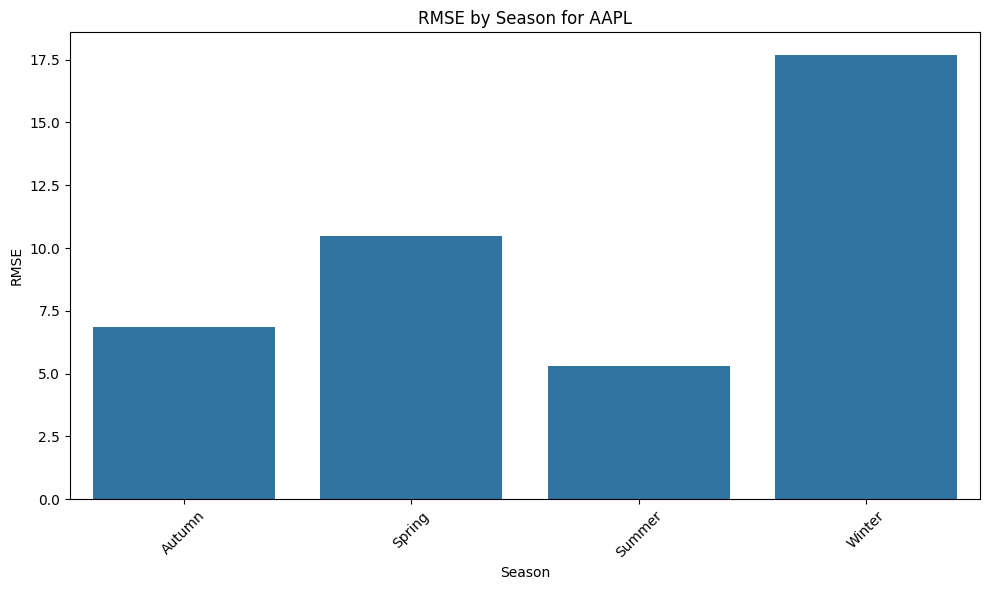

 - Plotting MAE by Season for AAPL


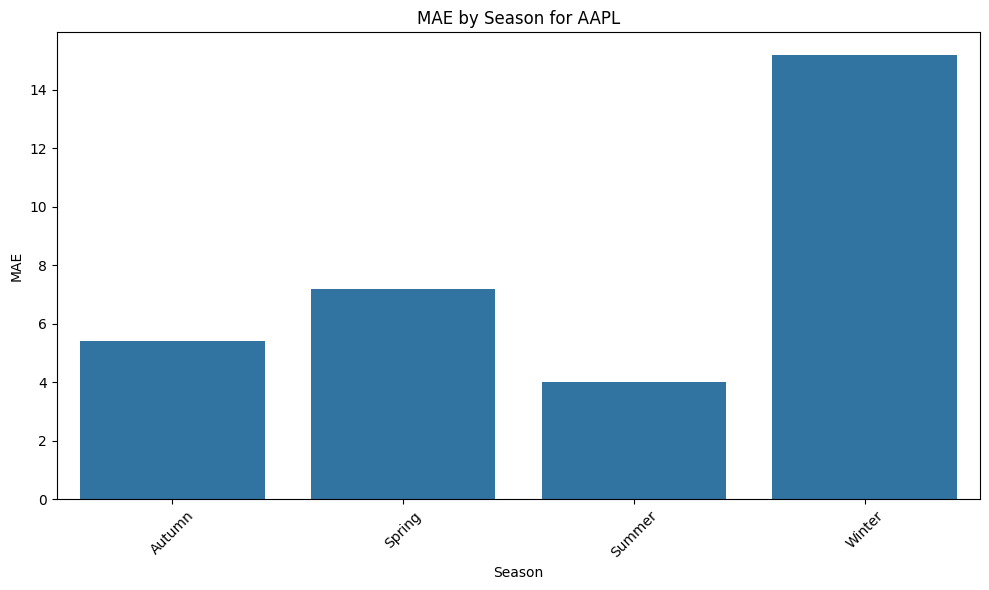

 - Plotting R2 by Season for AAPL


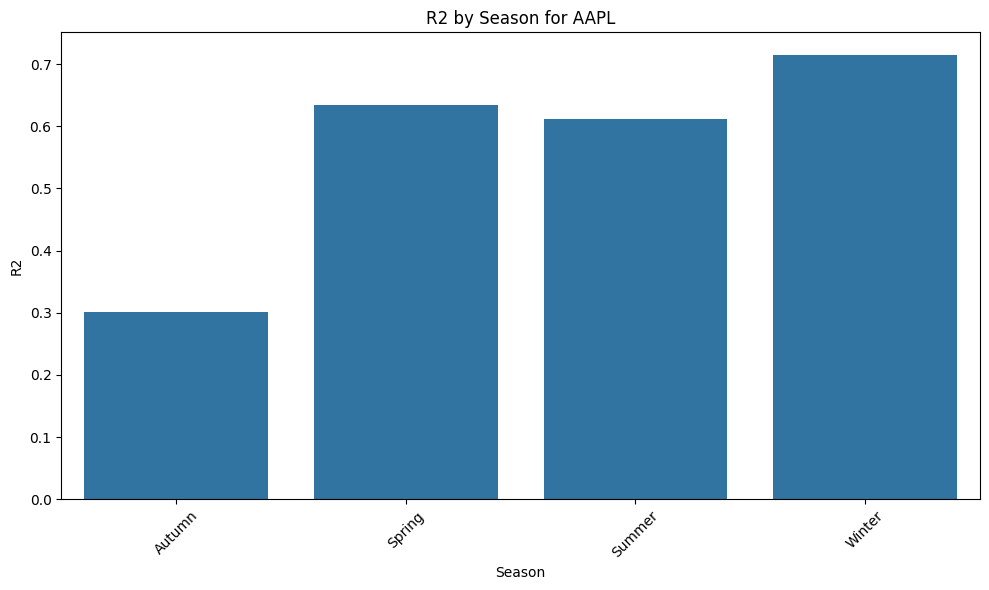

 - Plotting MAPE by Season for AAPL


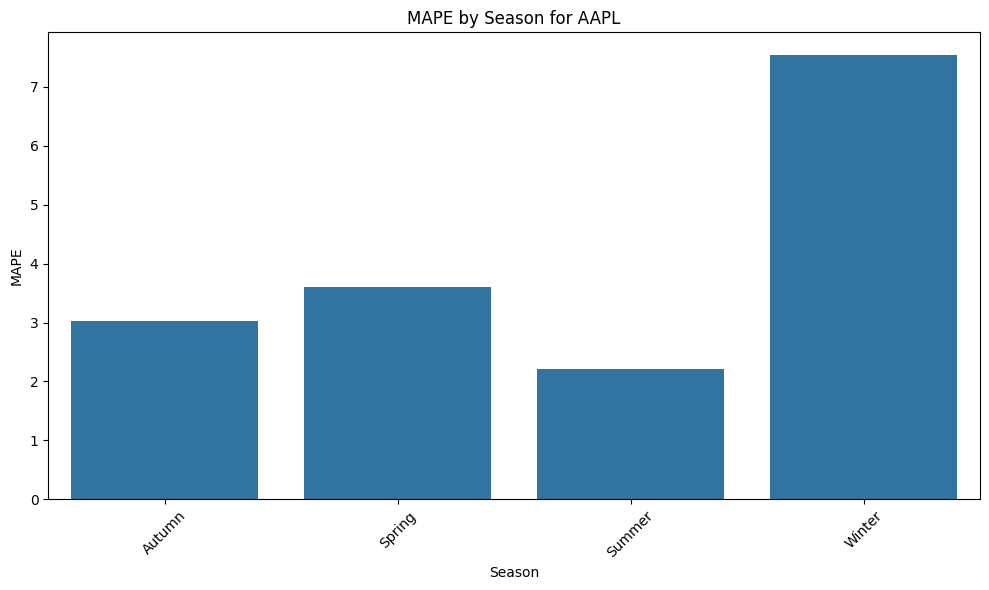

Evaluation and plotting completed for AAPL.


Evaluating and Plotting LSTM Model for MSFT
 - Loaded best model from ../models/lstm_models/lstm_MSFT_best.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 - No Date information found for MSFT. Creating dummy dates.
 - Overall Evaluation Metrics for MSFT:
    RMSE = 25.5322
    MAE = 20.7079
    R2 = 0.8169
    MAPE = 5.31%
 - Plotting RMSE by Season for MSFT


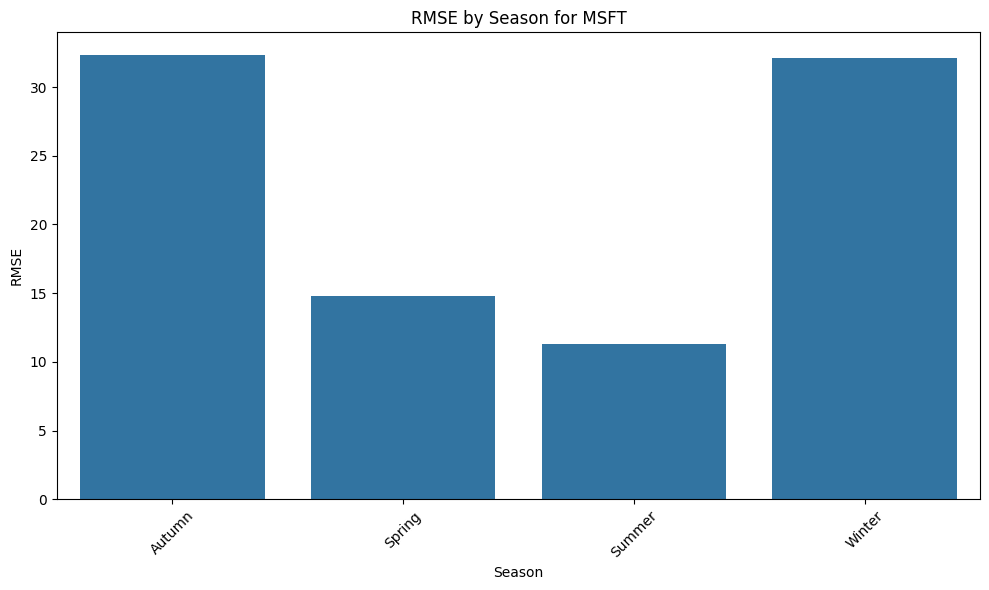

 - Plotting MAE by Season for MSFT


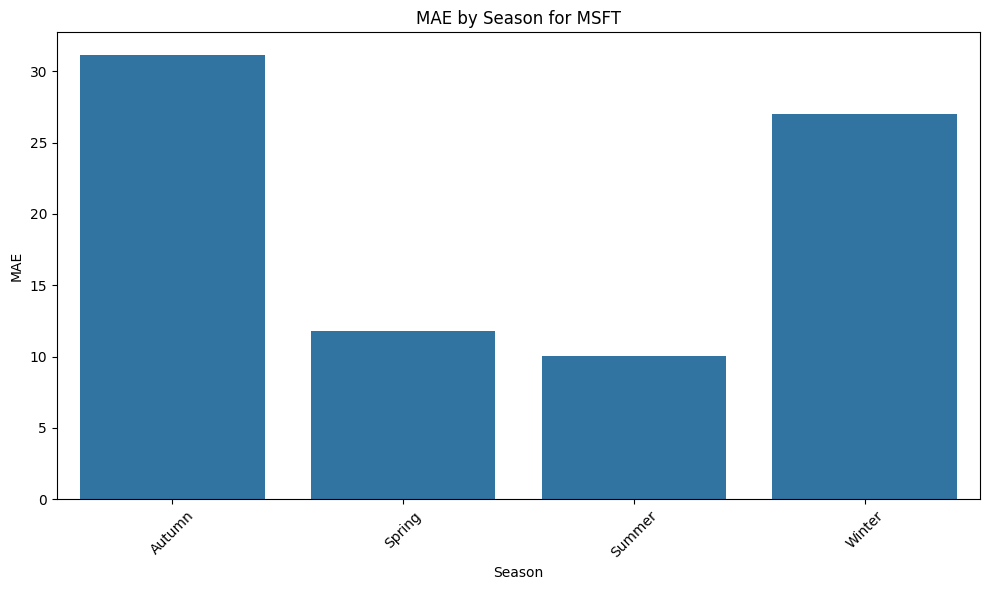

 - Plotting R2 by Season for MSFT


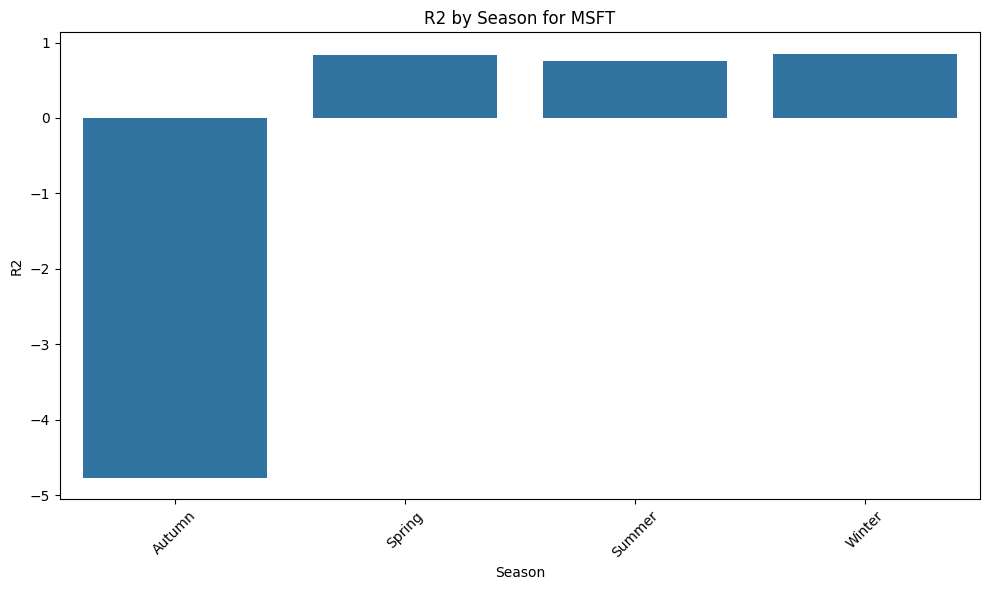

 - Plotting MAPE by Season for MSFT


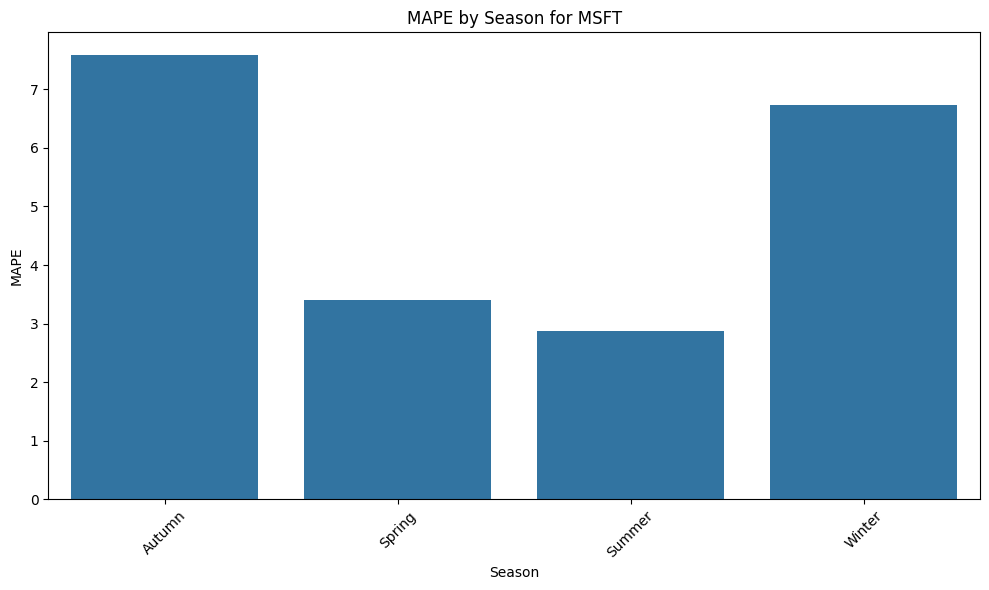

Evaluation and plotting completed for MSFT.


Evaluating and Plotting LSTM Model for GOOGL
 - Loaded best model from ../models/lstm_models/lstm_GOOGL_best.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 - No Date information found for GOOGL. Creating dummy dates.
 - Overall Evaluation Metrics for GOOGL:
    RMSE = 14.0543
    MAE = 10.6672
    R2 = 0.6881
    MAPE = 6.98%
 - Plotting RMSE by Season for GOOGL


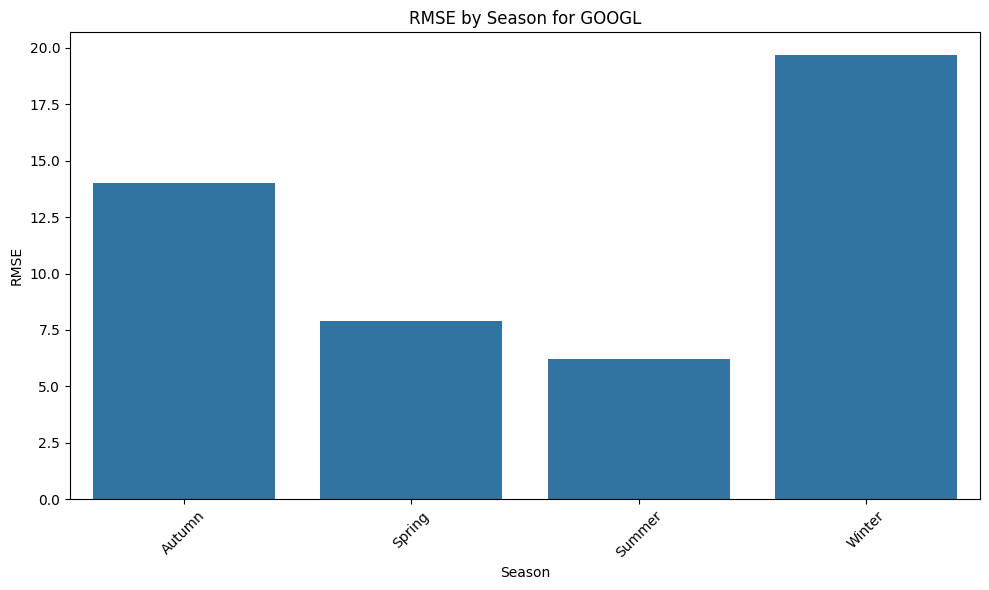

 - Plotting MAE by Season for GOOGL


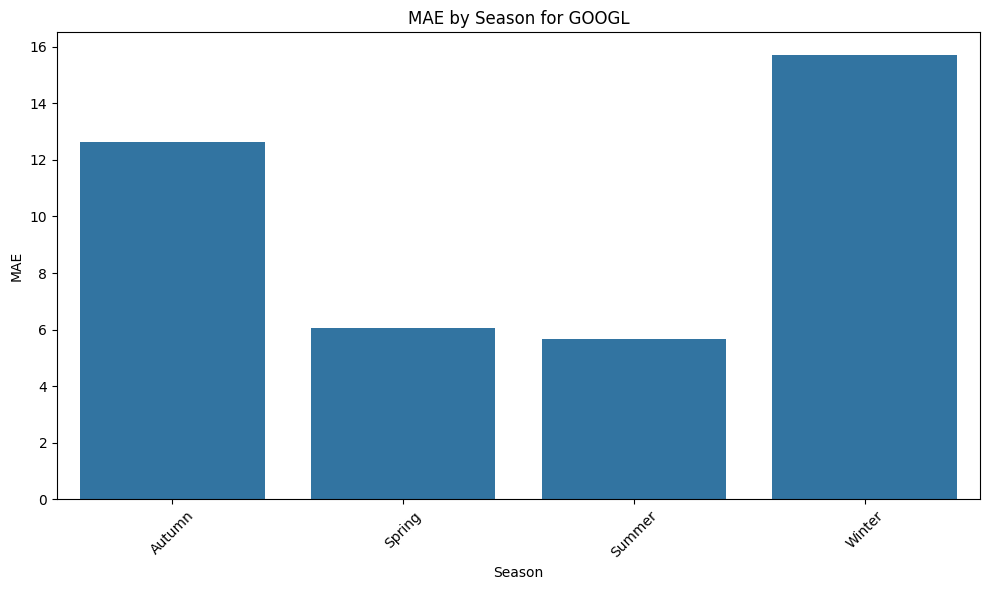

 - Plotting R2 by Season for GOOGL


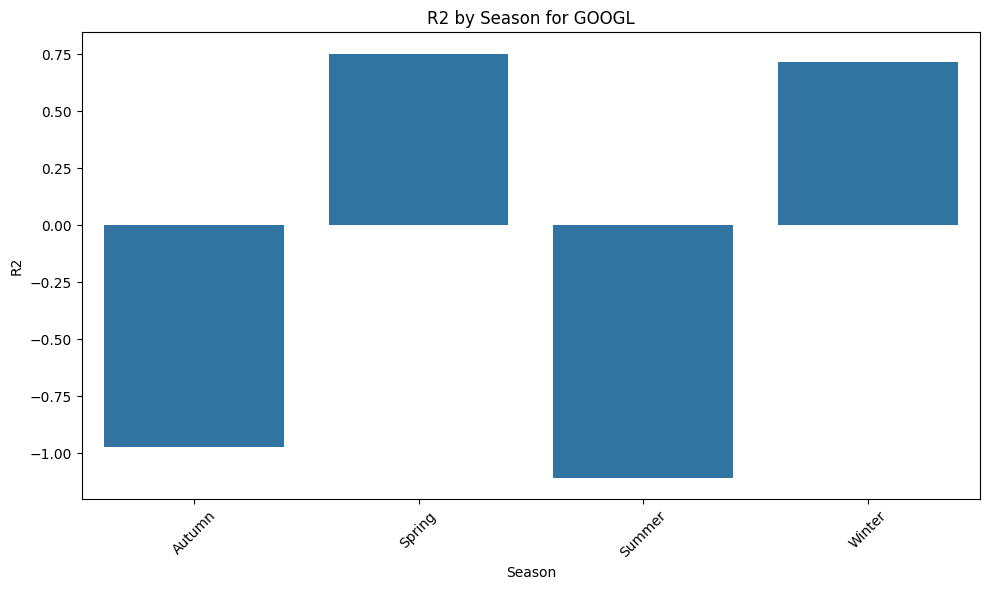

 - Plotting MAPE by Season for GOOGL


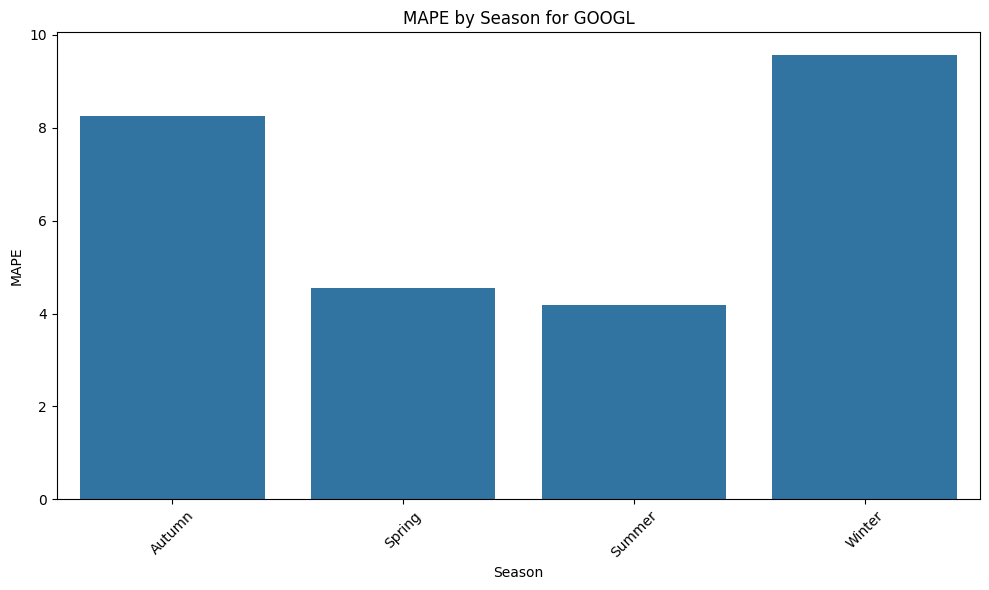

Evaluation and plotting completed for GOOGL.


Evaluating and Plotting LSTM Model for AMZN
 - Loaded best model from ../models/lstm_models/lstm_AMZN_best.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 - No Date information found for AMZN. Creating dummy dates.
 - Overall Evaluation Metrics for AMZN:
    RMSE = 13.6870
    MAE = 10.8810
    R2 = 0.8141
    MAPE = 6.69%
 - Plotting RMSE by Season for AMZN


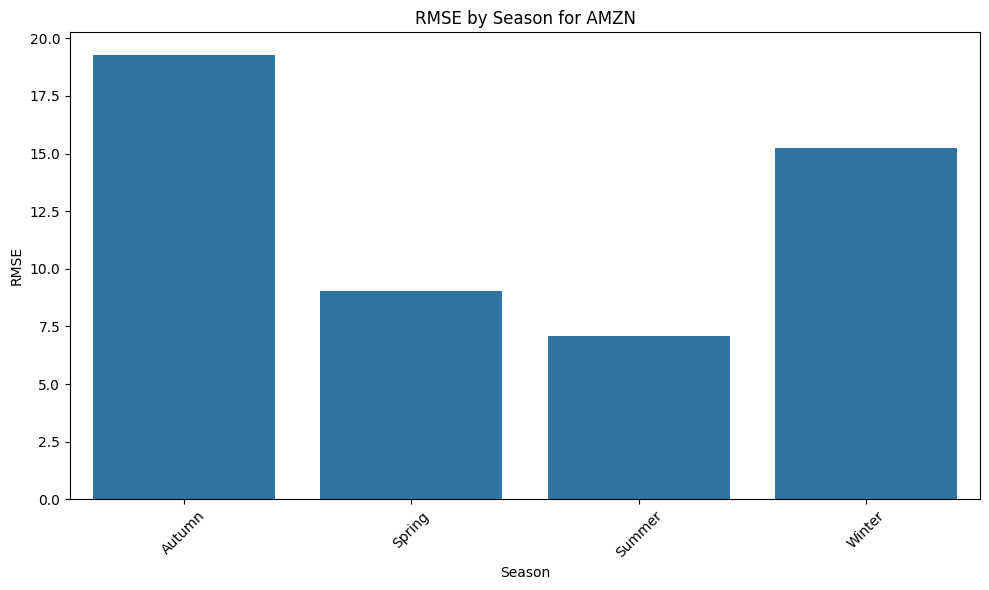

 - Plotting MAE by Season for AMZN


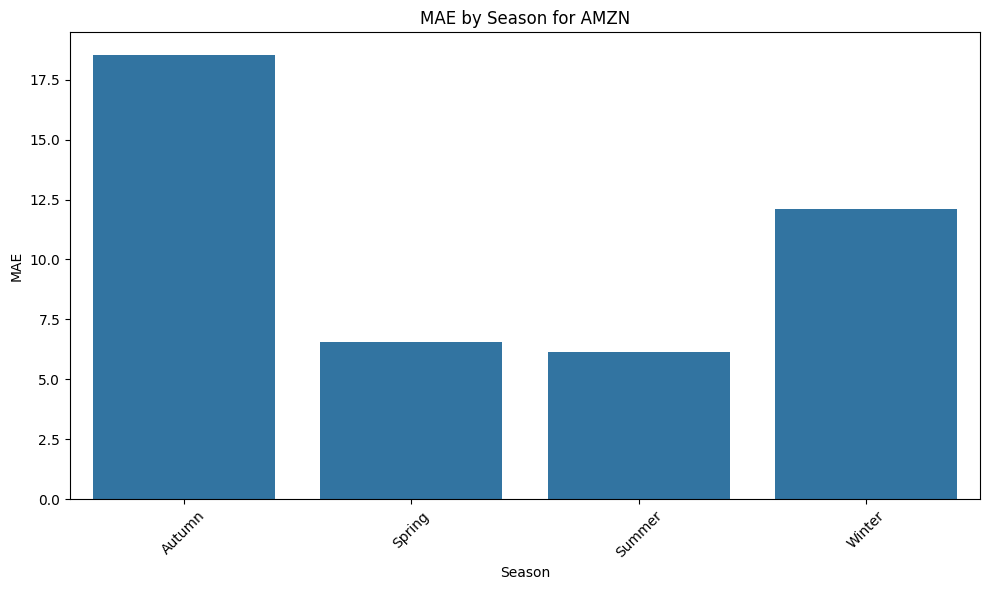

 - Plotting R2 by Season for AMZN


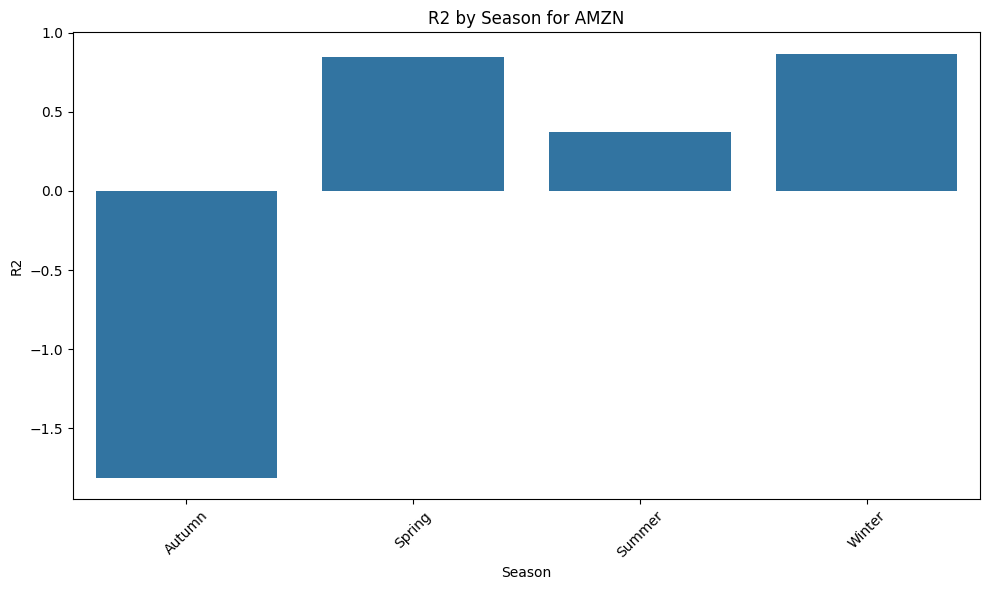

 - Plotting MAPE by Season for AMZN


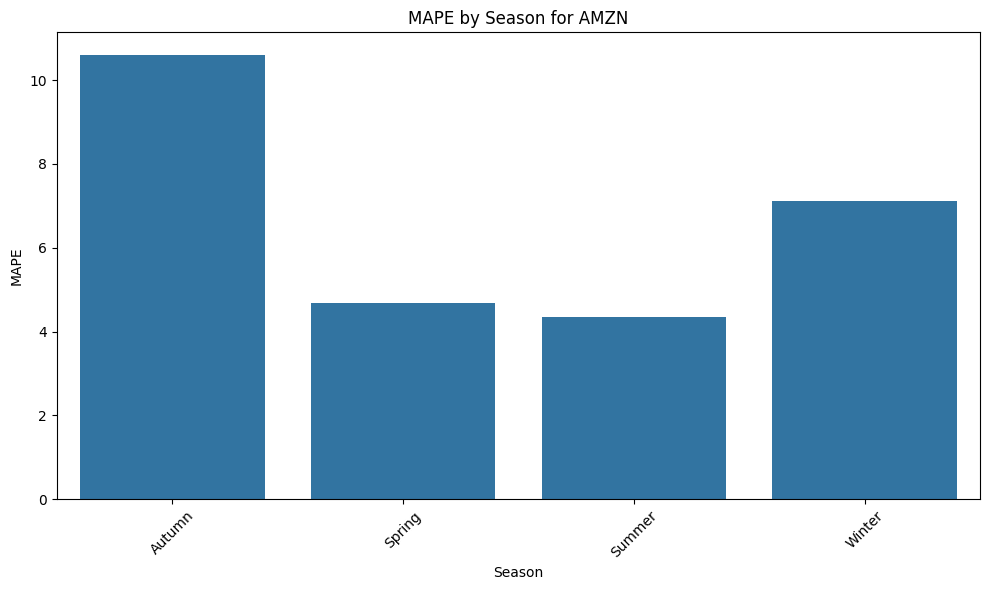

Evaluation and plotting completed for AMZN.


Overall Evaluation Metrics for All Stocks


,RMSE,MAE,R2,MAPE
AAPL,12.225840,8.905921,0.697431,4.548098
MSFT,25.532221,20.707898,0.816923,5.310216
GOOGL,14.054281,10.667250,0.688148,6.976893
AMZN,13.687011,10.881030,0.814091,6.685189



 - Overall Evaluation Metrics table saved as 'overall_evaluation_metrics.csv'.

Month Evaluation Metrics for AAPL


,Month,RMSE,MAE,R2,MAPE
0,1,17.260784,14.951704,0.795520,7.619740
1,2,18.812543,15.413074,0.696849,7.463959
2,3,14.368948,9.113616,0.689041,4.316874
3,4,6.740325,6.349453,-0.381727,3.431224
4,5,6.436778,5.403648,0.292327,2.826968
5,6,7.297285,5.299548,-0.873786,2.913243
6,7,4.667849,4.158135,0.227573,2.364331
7,8,3.147886,2.643374,-0.163912,1.363514
8,9,5.032277,3.773067,-0.768494,1.985822
9,10,5.410070,4.491687,-0.110415,2.573216


 - Month Evaluation Metrics table for AAPL saved as 'AAPL_Month_evaluation_metrics.csv'.

Month Evaluation Metrics for MSFT


,Month,RMSE,MAE,R2,MAPE
0,1,29.941798,23.881377,0.896241,6.104561
1,2,29.216639,23.399119,0.851265,6.066063
2,3,16.639902,12.765090,0.909622,3.512196
3,4,15.412401,13.733897,-4.623039,4.096486
4,5,10.933703,8.684432,0.071822,2.568154
5,6,10.954312,9.474202,-1.052584,2.939885
6,7,9.585140,8.107762,0.634248,2.338600
7,8,13.020970,12.517601,-12.758601,3.343080
8,9,24.511818,23.512719,-1.799911,5.876731
9,10,34.710031,34.077266,-16.458261,8.208062


 - Month Evaluation Metrics table for MSFT saved as 'MSFT_Month_evaluation_metrics.csv'.

Month Evaluation Metrics for GOOGL


,Month,RMSE,MAE,R2,MAPE
0,1,19.195421,14.368649,0.777480,8.724009
1,2,13.176705,10.237029,0.819110,6.923423
2,3,10.143468,7.339552,0.828171,5.138078
3,4,6.873672,6.582817,-8.518248,5.359182
4,5,4.808807,3.813968,-0.052497,2.976570
5,6,6.152050,5.564243,-3.334526,4.134225
6,7,6.316313,5.920420,-0.327612,4.436001
7,8,6.114676,5.471009,-2.322476,3.988350
8,9,9.621080,8.782080,-3.702494,6.011174
9,10,11.281798,10.467135,-2.255084,7.262434


 - Month Evaluation Metrics table for GOOGL saved as 'GOOGL_Month_evaluation_metrics.csv'.

Month Evaluation Metrics for AMZN


,Month,RMSE,MAE,R2,MAPE
0,1,14.914060,11.280671,0.884066,7.012422
1,2,12.162474,8.796180,0.911928,5.275525
2,3,12.155960,8.834543,0.884691,5.889823
3,4,6.699203,6.164292,-1.906606,4.920970
4,5,5.216675,3.842627,-0.542851,2.814350
5,6,4.959798,4.173730,0.211435,3.084962
6,7,5.659394,4.784826,0.335896,3.548206
7,8,9.606231,9.459920,-7.204892,6.356757
8,9,15.065819,13.904263,-2.084281,8.579092
9,10,20.851030,20.703104,-35.523408,11.783060


 - Month Evaluation Metrics table for AMZN saved as 'AMZN_Month_evaluation_metrics.csv'.

Quarter Evaluation Metrics for AAPL


,Quarter,RMSE,MAE,R2,MAPE
0,1,17.143262,13.592067,0.745506,6.702970
1,2,6.829852,5.681133,0.132668,3.054616
2,3,4.351852,3.522161,0.675257,1.903672
3,4,11.356709,9.278663,0.347794,4.898745


 - Quarter Evaluation Metrics table for AAPL saved as 'AAPL_Quarter_evaluation_metrics.csv'.

Quarter Evaluation Metrics for MSFT


,Quarter,RMSE,MAE,R2,MAPE
0,1,26.826891,20.810739,0.883518,5.414662
1,2,12.593428,10.609454,-0.706409,3.194548
2,3,16.852594,14.617042,0.588576,3.830805
3,4,37.270473,36.607462,-6.240851,8.699520


 - Quarter Evaluation Metrics table for MSFT saved as 'MSFT_Quarter_evaluation_metrics.csv'.

Quarter Evaluation Metrics for GOOGL


,Quarter,RMSE,MAE,R2,MAPE
0,1,15.172469,11.072224,0.800913,7.151074
1,2,5.994242,5.303789,-0.062030,4.143691
2,3,7.498400,6.702138,-0.291312,4.798806
3,4,21.011028,19.228819,-0.954227,11.652571


 - Quarter Evaluation Metrics table for GOOGL saved as 'GOOGL_Quarter_evaluation_metrics.csv'.

Quarter Evaluation Metrics for AMZN


,Quarter,RMSE,MAE,R2,MAPE
0,1,13.288160,9.762948,0.895890,6.104644
1,2,5.672366,4.717166,0.142744,3.598053
2,3,10.765751,9.333859,0.271001,6.135072
3,4,20.762168,20.481709,-12.637542,11.304842


 - Quarter Evaluation Metrics table for AMZN saved as 'AMZN_Quarter_evaluation_metrics.csv'.

Season Evaluation Metrics for AAPL


,Season,RMSE,MAE,R2,MAPE
0,Autumn,6.853177,5.418794,0.301723,3.032626
1,Spring,10.482975,7.191928,0.633462,3.610499
2,Summer,5.295762,4.019926,0.612338,2.206092
3,Winter,17.700548,15.195131,0.715248,7.547732


 - Season Evaluation Metrics table for AAPL saved as 'AAPL_Season_evaluation_metrics.csv'.

Season Evaluation Metrics for MSFT


,Season,RMSE,MAE,R2,MAPE
0,Autumn,32.367154,31.165589,-4.772376,7.594022
1,Spring,14.767260,11.819108,0.832302,3.398249
2,Summer,11.279043,10.039265,0.755508,2.873137
3,Winter,32.117077,27.010631,0.854142,6.732334


 - Season Evaluation Metrics table for MSFT saved as 'MSFT_Season_evaluation_metrics.csv'.

Season Evaluation Metrics for GOOGL


,Season,RMSE,MAE,R2,MAPE
0,Autumn,14.027543,12.616831,-0.970286,8.258018
1,Spring,7.916839,6.058046,0.754105,4.551927
2,Summer,6.195430,5.652843,-1.108061,4.186757
3,Winter,19.702245,15.724994,0.717163,9.576105


 - Season Evaluation Metrics table for GOOGL saved as 'GOOGL_Season_evaluation_metrics.csv'.

Season Evaluation Metrics for AMZN


,Season,RMSE,MAE,R2,MAPE
0,Autumn,19.292353,18.544437,-1.815294,10.609110
1,Spring,9.028667,6.554379,0.849631,4.682005
2,Summer,7.064569,6.160859,0.371315,4.343507
3,Winter,15.235973,12.097901,0.868600,7.116428


 - Season Evaluation Metrics table for AMZN saved as 'AMZN_Season_evaluation_metrics.csv'.

Comparative RMSE Across Month for All Stocks


,AAPL,MSFT,GOOGL,AMZN
Month,,,,
1,17.260784,29.941798,19.195421,14.914060
2,18.812543,29.216639,13.176705,12.162474
3,14.368948,16.639902,10.143468,12.155960
4,6.740325,15.412401,6.873672,6.699203
5,6.436778,10.933703,4.808807,5.216675
6,7.297285,10.954312,6.152050,4.959798
7,4.667849,9.585140,6.316313,5.659394
8,3.147886,13.020970,6.114676,9.606231
9,5.032277,24.511818,9.621080,15.065819


 - Comparative RMSE Across Month table saved as 'comparative_RMSE_across_Month.csv'.

Comparative MAE Across Month for All Stocks


,AAPL,MSFT,GOOGL,AMZN
Month,,,,
1,14.951704,23.881377,14.368649,11.280671
2,15.413074,23.399119,10.237029,8.796180
3,9.113616,12.765090,7.339552,8.834543
4,6.349453,13.733897,6.582817,6.164292
5,5.403648,8.684432,3.813968,3.842627
6,5.299548,9.474202,5.564243,4.173730
7,4.158135,8.107762,5.920420,4.784826
8,2.643374,12.517601,5.471009,9.459920
9,3.773067,23.512719,8.782080,13.904263


 - Comparative MAE Across Month table saved as 'comparative_MAE_across_Month.csv'.

Comparative R2 Across Month for All Stocks


,AAPL,MSFT,GOOGL,AMZN
Month,,,,
1,0.795520,0.896241,0.777480,0.884066
2,0.696849,0.851265,0.819110,0.911928
3,0.689041,0.909622,0.828171,0.884691
4,-0.381727,-4.623039,-8.518248,-1.906606
5,0.292327,0.071822,-0.052497,-0.542851
6,-0.873786,-1.052584,-3.334526,0.211435
7,0.227573,0.634248,-0.327612,0.335896
8,-0.163912,-12.758601,-2.322476,-7.204892
9,-0.768494,-1.799911,-3.702494,-2.084281


 - Comparative R2 Across Month table saved as 'comparative_R2_across_Month.csv'.

Comparative MAPE Across Month for All Stocks


,AAPL,MSFT,GOOGL,AMZN
Month,,,,
1,7.619740,6.104561,8.724009,7.012422
2,7.463959,6.066063,6.923423,5.275525
3,4.316874,3.512196,5.138078,5.889823
4,3.431224,4.096486,5.359182,4.920970
5,2.826968,2.568154,2.976570,2.814350
6,2.913243,2.939885,4.134225,3.084962
7,2.364331,2.338600,4.436001,3.548206
8,1.363514,3.343080,3.988350,6.356757
9,1.985822,5.876731,6.011174,8.579092


 - Comparative MAPE Across Month table saved as 'comparative_MAPE_across_Month.csv'.

Comparative RMSE Across Quarter for All Stocks


,AAPL,MSFT,GOOGL,AMZN
Quarter,,,,
1,17.143262,26.826891,15.172469,13.288160
2,6.829852,12.593428,5.994242,5.672366
3,4.351852,16.852594,7.498400,10.765751
4,11.356709,37.270473,21.011028,20.762168


 - Comparative RMSE Across Quarter table saved as 'comparative_RMSE_across_Quarter.csv'.

Comparative MAE Across Quarter for All Stocks


,AAPL,MSFT,GOOGL,AMZN
Quarter,,,,
1,13.592067,20.810739,11.072224,9.762948
2,5.681133,10.609454,5.303789,4.717166
3,3.522161,14.617042,6.702138,9.333859
4,9.278663,36.607462,19.228819,20.481709


 - Comparative MAE Across Quarter table saved as 'comparative_MAE_across_Quarter.csv'.

Comparative R2 Across Quarter for All Stocks


,AAPL,MSFT,GOOGL,AMZN
Quarter,,,,
1,0.745506,0.883518,0.800913,0.895890
2,0.132668,-0.706409,-0.062030,0.142744
3,0.675257,0.588576,-0.291312,0.271001
4,0.347794,-6.240851,-0.954227,-12.637542


 - Comparative R2 Across Quarter table saved as 'comparative_R2_across_Quarter.csv'.

Comparative MAPE Across Quarter for All Stocks


,AAPL,MSFT,GOOGL,AMZN
Quarter,,,,
1,6.702970,5.414662,7.151074,6.104644
2,3.054616,3.194548,4.143691,3.598053
3,1.903672,3.830805,4.798806,6.135072
4,4.898745,8.699520,11.652571,11.304842


 - Comparative MAPE Across Quarter table saved as 'comparative_MAPE_across_Quarter.csv'.

Comparative RMSE Across Season for All Stocks


,AAPL,MSFT,GOOGL,AMZN
Season,,,,
Autumn,6.853177,32.367154,14.027543,19.292353
Spring,10.482975,14.767260,7.916839,9.028667
Summer,5.295762,11.279043,6.195430,7.064569
Winter,17.700548,32.117077,19.702245,15.235973


 - Comparative RMSE Across Season table saved as 'comparative_RMSE_across_Season.csv'.

Comparative MAE Across Season for All Stocks


,AAPL,MSFT,GOOGL,AMZN
Season,,,,
Autumn,5.418794,31.165589,12.616831,18.544437
Spring,7.191928,11.819108,6.058046,6.554379
Summer,4.019926,10.039265,5.652843,6.160859
Winter,15.195131,27.010631,15.724994,12.097901


 - Comparative MAE Across Season table saved as 'comparative_MAE_across_Season.csv'.

Comparative R2 Across Season for All Stocks


,AAPL,MSFT,GOOGL,AMZN
Season,,,,
Autumn,0.301723,-4.772376,-0.970286,-1.815294
Spring,0.633462,0.832302,0.754105,0.849631
Summer,0.612338,0.755508,-1.108061,0.371315
Winter,0.715248,0.854142,0.717163,0.868600


 - Comparative R2 Across Season table saved as 'comparative_R2_across_Season.csv'.

Comparative MAPE Across Season for All Stocks


,AAPL,MSFT,GOOGL,AMZN
Season,,,,
Autumn,3.032626,7.594022,8.258018,10.609110
Spring,3.610499,3.398249,4.551927,4.682005
Summer,2.206092,2.873137,4.186757,4.343507
Winter,7.547732,6.732334,9.576105,7.116428


 - Comparative MAPE Across Season table saved as 'comparative_MAPE_across_Season.csv'.


In [8]:
# Cell 7: Evaluation and Plotting of LSTM Models with Numerical Metrics Tables

TIMESTEPS = 60
model_save_dir = '../models/lstm_models'

def create_sequences(X, y, timesteps):
    X_seq, y_seq = [], []
    for i in range(timesteps, len(X)):
        X_seq.append(X[i-timesteps:i].values)
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

def calculate_group_metrics(eval_df, group_by):
    grouped = eval_df.groupby(group_by).apply(lambda x: pd.Series({
        'RMSE': np.sqrt(mean_squared_error(x['Actual'], x['Predicted'])),
        'MAE': mean_absolute_error(x['Actual'], x['Predicted']),
        'R2': r2_score(x['Actual'], x['Predicted']),
        'MAPE': mean_absolute_percentage_error(x['Actual'], x['Predicted']) * 100
    }), include_groups=False)
    return grouped

def plot_metrics_by_group(grouped_metrics, stock, grouping, metric):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=grouped_metrics.index, y=grouped_metrics[metric])
    plt.title(f'{metric} by {grouping} for {stock}')
    plt.xlabel(grouping)
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_comparative_metrics(grouped_metrics, stocks, grouping, metric):
    plt.figure(figsize=(12, 8))
    for stock in stocks:
        sns.lineplot(data=grouped_metrics[stock][grouping], x=grouped_metrics[stock][grouping].index, y=metric, label=stock)
    plt.title(f'Comparison of {metric} across {grouping}')
    plt.xlabel(grouping)
    plt.ylabel(metric)
    plt.legend(title='Stock')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def add_time_features(eval_df):
    eval_df['Month'] = eval_df['Date'].dt.month
    eval_df['Quarter'] = eval_df['Date'].dt.quarter
    eval_df['Season'] = eval_df['Month'].apply(lambda month: 'Winter' if month in [12, 1, 2] else 'Spring' if month in [3,4,5] else 'Summer' if month in [6,7,8] else 'Autumn')
    return eval_df

overall_metrics = {}
grouped_metrics_all = {'Month': {}, 'Quarter': {}, 'Season': {}}

for stock in scaled_daily_data.keys():
    print(f"\n{'='*50}\nEvaluating and Plotting LSTM Model for {stock}\n{'='*50}")
    
    data = scaled_daily_data[stock]
    X_test_scaled = data['X_test_scaled']
    y_test_scaled = data['y_test_scaled']
    scaler_y = data['scaler_y']
    
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, TIMESTEPS)
    
    best_model_path = os.path.join(model_save_dir, f'lstm_{stock}_best.keras')
    if not os.path.exists(best_model_path):
        print(f" - Best model for {stock} not found at {best_model_path}. Skipping...")
        continue
    try:
        model = load_model(best_model_path)
    except Exception as e:
        print(f" - Failed to load model for {stock}: {e}. Skipping...")
        continue
    print(f" - Loaded best model from {best_model_path}")
    
    predictions_scaled = model.predict(X_test_seq).flatten()
    
    try:
        predictions = scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1)).flatten()
        y_test = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()
    except Exception as e:
        print(f" - Failed to inverse transform predictions or actuals for {stock}: {e}. Skipping...")
        continue
    
    if isinstance(X_test_scaled, pd.DataFrame) and isinstance(X_test_scaled.index, pd.DatetimeIndex):
        dates = X_test_scaled.index[TIMESTEPS:]
    elif isinstance(X_test_scaled, pd.DataFrame) and 'Date' in X_test_scaled.columns:
        dates = pd.to_datetime(X_test_scaled['Date'].iloc[TIMESTEPS:])
    else:
        print(f" - No Date information found for {stock}. Creating dummy dates.")
        dates = pd.date_range(start='2020-01-01', periods=len(y_test), freq='D')
    
    eval_df = pd.DataFrame({
        'Date': dates,
        'Actual': y_test,
        'Predicted': predictions
    })
    
    eval_df = add_time_features(eval_df)
    
    rmse = np.sqrt(mean_squared_error(eval_df['Actual'], eval_df['Predicted']))
    mae = mean_absolute_error(eval_df['Actual'], eval_df['Predicted'])
    r2 = r2_score(eval_df['Actual'], eval_df['Predicted'])
    mape = mean_absolute_percentage_error(eval_df['Actual'], eval_df['Predicted']) * 100
    
    overall_metrics[stock] = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape
    }
    
    print(f" - Overall Evaluation Metrics for {stock}:")
    print(f"    RMSE = {rmse:.4f}")
    print(f"    MAE = {mae:.4f}")
    print(f"    R2 = {r2:.4f}")
    print(f"    MAPE = {mape:.2f}%")
    
    grouped_metrics_month = calculate_group_metrics(eval_df, 'Month')
    grouped_metrics_quarter = calculate_group_metrics(eval_df, 'Quarter')
    grouped_metrics_season = calculate_group_metrics(eval_df, 'Season')
    
    grouped_metrics_all['Month'][stock] = grouped_metrics_month
    grouped_metrics_all['Quarter'][stock] = grouped_metrics_quarter
    grouped_metrics_all['Season'][stock] = grouped_metrics_season
    
    print(f" - Plotting RMSE by Season for {stock}")
    plot_metrics_by_group(grouped_metrics_season, stock, 'Season', 'RMSE')
    
    print(f" - Plotting MAE by Season for {stock}")
    plot_metrics_by_group(grouped_metrics_season, stock, 'Season', 'MAE')
    
    print(f" - Plotting R2 by Season for {stock}")
    plot_metrics_by_group(grouped_metrics_season, stock, 'Season', 'R2')
    
    print(f" - Plotting MAPE by Season for {stock}")
    plot_metrics_by_group(grouped_metrics_season, stock, 'Season', 'MAPE')
    
    print(f"Evaluation and plotting completed for {stock}.\n")

overall_metrics_df = pd.DataFrame(overall_metrics).T
print("\n" + "="*50)
print("Overall Evaluation Metrics for All Stocks")
print("="*50)
display(overall_metrics_df)
overall_metrics_df.to_csv('overall_evaluation_metrics.csv')
print("\n - Overall Evaluation Metrics table saved as 'overall_evaluation_metrics.csv'.")

def create_grouped_metrics_tables(grouped_metrics_all, grouping):
    grouped_metrics_tables = {}
    for stock, metrics in grouped_metrics_all[grouping].items():
        metrics_df = metrics.reset_index()
        metrics_df.columns = [grouping] + list(metrics_df.columns[1:])
        grouped_metrics_tables[stock] = metrics_df
    return grouped_metrics_tables

for grouping in ['Month', 'Quarter', 'Season']:
    grouped_tables = create_grouped_metrics_tables(grouped_metrics_all, grouping)
    for stock, table in grouped_tables.items():
        print(f"\n{'='*50}\n{grouping} Evaluation Metrics for {stock}\n{'='*50}")
        display(table)
        filename = f'{stock}_{grouping}_evaluation_metrics.csv'
        table.to_csv(filename, index=False)
        print(f" - {grouping} Evaluation Metrics table for {stock} saved as '{filename}'.")

for grouping in ['Month', 'Quarter', 'Season']:
    for metric in ['RMSE', 'MAE', 'R2', 'MAPE']:
        comparative_df = pd.DataFrame({stock: grouped_metrics_all[grouping][stock][metric] for stock in grouped_metrics_all[grouping].keys()})
        comparative_df.index.name = grouping
        print(f"\n{'='*50}\nComparative {metric} Across {grouping} for All Stocks\n{'='*50}")
        display(comparative_df)
        filename = f'comparative_{metric}_across_{grouping}.csv'
        comparative_df.to_csv(filename)
        print(f" - Comparative {metric} Across {grouping} table saved as '{filename}'.")


In [9]:
# Cell 8: Training and Evaluating GRU Models for Daily Data

import os
import random
import numpy as np
import pandas as pd
import joblib
import logging
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GRU, Dropout, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

# Define Parameters
TIMESTEPS = 60  # Number of past days to use for prediction
BATCH_SIZE = 32
EPOCHS = 100
VALIDATION_SPLIT = 0.1
SEED = 42

# Set random seeds for reproducibility
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Function to Create Sequences (Already Defined in Cell 6)
def create_sequences(X, y, timesteps):
    X_seq, y_seq = [], []
    for i in range(timesteps, len(X)):
        X_seq.append(X[i-timesteps:i].values)
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# Function to Build GRU Model
def build_gru_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(GRU(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=25, activation='relu'))
    model.add(Dense(units=1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Initialize a dictionary to store GRU model performance
gru_model_performance = {}

# Define Directory to Save GRU Models
gru_model_save_dir = '../models/gru_models'
os.makedirs(gru_model_save_dir, exist_ok=True)

# Iterate Through Each Stock
for stock in scaled_daily_data.keys():
    print(f"\n{'='*50}\nTraining GRU Model for {stock}\n{'='*50}")
    
    # Retrieve Scaled Data
    data = scaled_daily_data[stock]
    X_train_scaled = data['X_train_scaled']
    X_test_scaled = data['X_test_scaled']
    y_train_scaled = data['y_train_scaled']
    y_test_scaled = data['y_test_scaled']
    scaler_y = data['scaler_y']
    
    # Create Sequences
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, TIMESTEPS)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, TIMESTEPS)
    
    print(f" - Training sequences: {X_train_seq.shape}, Training targets: {y_train_seq.shape}")
    print(f" - Testing sequences: {X_test_seq.shape}, Testing targets: {y_test_seq.shape}")
    
    # Build the GRU Model
    model = build_gru_model(input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]))
    model.summary()
    
    # Define Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    checkpoint = ModelCheckpoint(
        filepath=os.path.join(gru_model_save_dir, f'gru_{stock}_best.keras'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
    
    # Train the GRU Model
    history = model.fit(
        X_train_seq, y_train_seq,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_split=VALIDATION_SPLIT,
        callbacks=[early_stop, checkpoint],
        verbose=1
    )
    
    # Load the Best Model
    best_model_path = os.path.join(gru_model_save_dir, f'gru_{stock}_best.keras')
    if os.path.exists(best_model_path):
        model = load_model(best_model_path)
        print(f" - Loaded best model from {best_model_path}")
    else:
        print(f" - Best GRU model for {stock} not found at {best_model_path}.")
        continue  # Skip evaluation if model not saved
    
    # Predict on Test Data
    predictions_scaled = model.predict(X_test_seq).flatten()
    
    # Inverse Transform Predictions and Targets
    predictions = scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1)).flatten()
    y_test = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()
    
    # Ensure Consistent Lengths
    print(f" - Length of y_test: {len(y_test)}")
    print(f" - Length of predictions: {len(predictions)}")
    
    # Evaluation Metrics
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    gru_model_performance[stock] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}
    
    print(f" - Evaluation Metrics for GRU {stock}: RMSE = {rmse:.4f}, MAE = {mae:.4f}, R2 = {r2:.4f}")
    
    print(f"GRU model training and evaluation completed for {stock}.\n")

# Summary of GRU Model Performance
print(f"\n{'='*50}\nSummary of GRU Model Performance\n{'='*50}")
for stock, metrics in gru_model_performance.items():
    print(f"{stock}: RMSE = {metrics['RMSE']:.4f}, MAE = {metrics['MAE']:.4f}, R2 = {metrics['R2']:.4f}")



Training GRU Model for AAPL
 - Training sequences: (1924, 60, 51), Training targets: (1924,)
 - Testing sequences: (436, 60, 51), Testing targets: (436,)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 60, 50)         │        15,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,051 (125.20 KB)

 Trainable params: 32,051 (125.20 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0918
Epoch 1: val_loss improved from inf to 0.00417, saving model to ../models/gru_models/gru_AAPL_best.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0875 - val_loss: 0.0042
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0041
Epoch 2: val_loss did not improve from 0.00417
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0041 - val_loss: 0.0153
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0034
Epoch 3: val_loss improved from 0.00417 to 0.00242, saving model to ../models/gru_models/gru_AAPL_best.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0034 - val_loss: 0.0024
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0027
Epoch 4: val_loss improved from 0.00242 to 0.00235, saving model to ../models/gru_models/gru_AAPL_best.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0021

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 60, 50)         │        15,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,051 (125.20 KB)

 Trainable params: 32,051 (125.20 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0398
Epoch 1: val_loss improved from inf to 0.00333, saving model to ../models/gru_models/gru_MSFT_best.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0394 - val_loss: 0.0033
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0060
Epoch 2: val_loss improved from 0.00333 to 0.00290, saving model to ../models/gru_models/gru_MSFT_best.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0060 - val_loss: 0.0029
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0040
Epoch 3: val_loss improved from 0.00290 to 0.00237, saving model to ../models/gru_models/gru_MSFT_best.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0040 - val_loss: 0.0024
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0034
Epoch 4: val_loss improved from 0.00237 to 0.00219, saving model to ../models/gru_models/gru_MSFT_best.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0034 - val_loss: 0.0022
Epoc

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 60, 50)         │        15,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,051 (125.20 KB)

 Trainable params: 32,051 (125.20 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1047
Epoch 1: val_loss improved from inf to 0.01532, saving model to ../models/gru_models/gru_GOOGL_best.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.1036 - val_loss: 0.0153
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0070
Epoch 2: val_loss improved from 0.01532 to 0.00455, saving model to ../models/gru_models/gru_GOOGL_best.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0070 - val_loss: 0.0045
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0054
Epoch 3: val_loss did not improve from 0.00455
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0054 - val_loss: 0.0133
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0038
Epoch 4: val_loss improved from 0.00455 to 0.00326, saving model to ../models/gru_models/gru_GOOGL_best.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_6 (GRU)                     │ (None, 60, 50)         │        15,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,051 (125.20 KB)

 Trainable params: 32,051 (125.20 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0992
Epoch 1: val_loss improved from inf to 0.01196, saving model to ../models/gru_models/gru_AMZN_best.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0981 - val_loss: 0.0120
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0069
Epoch 2: val_loss improved from 0.01196 to 0.01175, saving model to ../models/gru_models/gru_AMZN_best.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0068 - val_loss: 0.0117
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0048
Epoch 3: val_loss improved from 0.01175 to 0.00801, saving model to ../models/gru_models/gru_AMZN_best.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0047 - val_loss: 0.0080
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0038
Epoch 4: val_loss improved from 0.00801 to 0.00501, saving model to ../models/gru_models/gru_AMZN_best.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0038 - val_loss: 0.0050
Epoc


Training and Evaluating XGBoost Model for AAPL
 - XGBoost model trained for AAPL
 - No Date information found for AAPL. Creating dummy dates.
 - Overall Evaluation Metrics for AAPL:
    RMSE = 18.9813
    MAE = 10.8949
    R2 = 0.4379
    MAPE = 5.22%


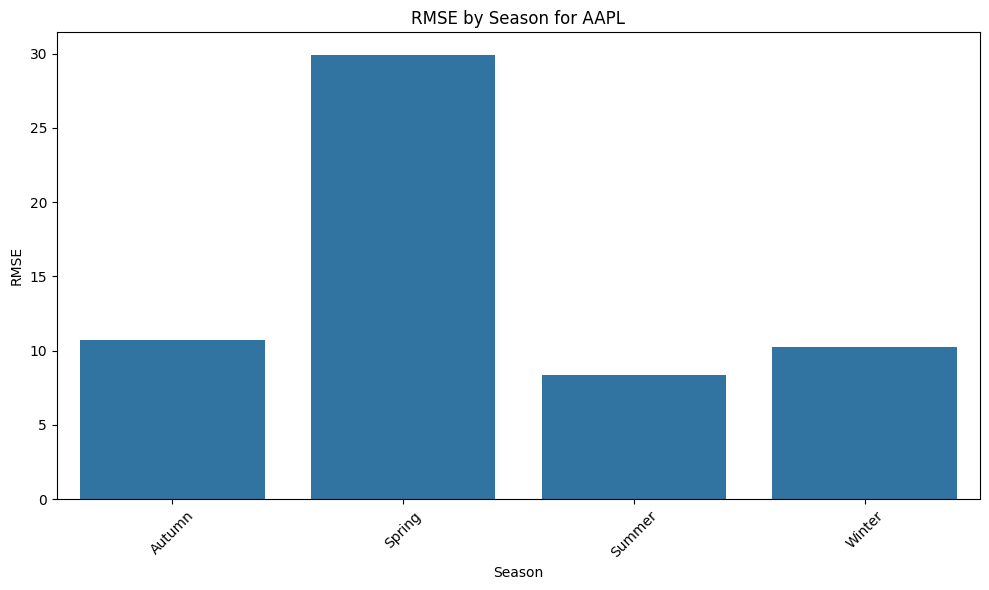

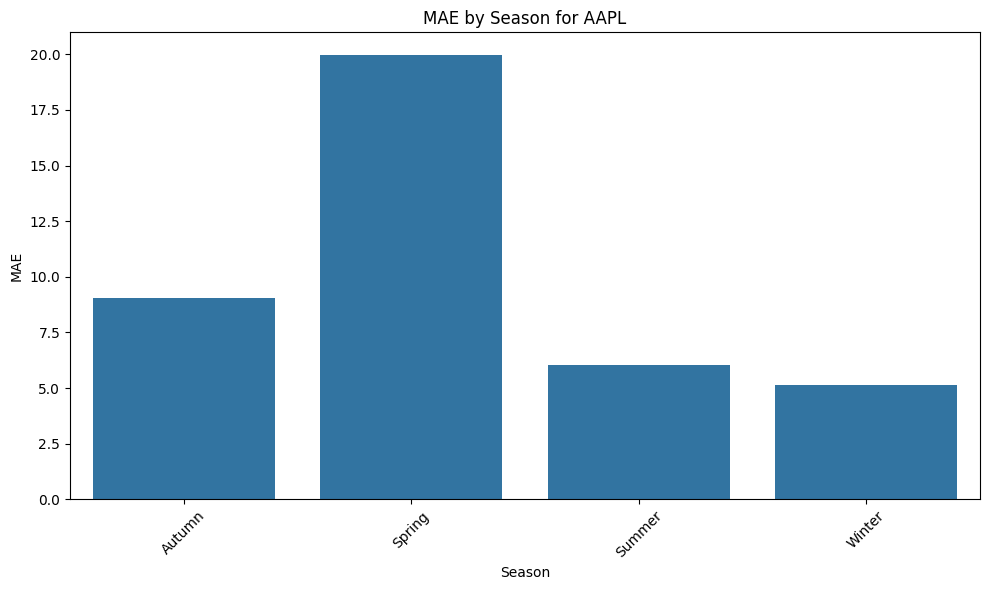

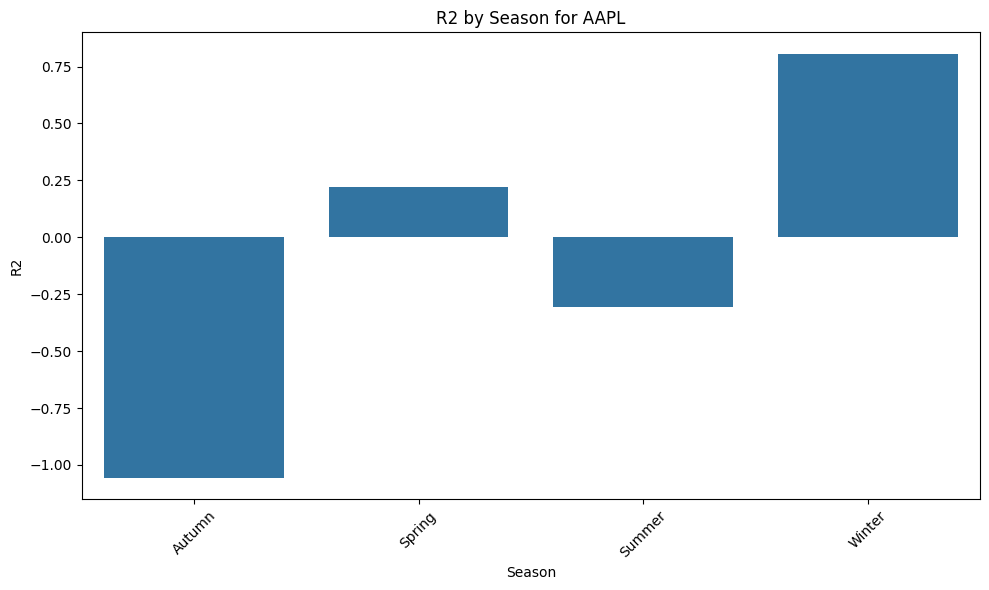

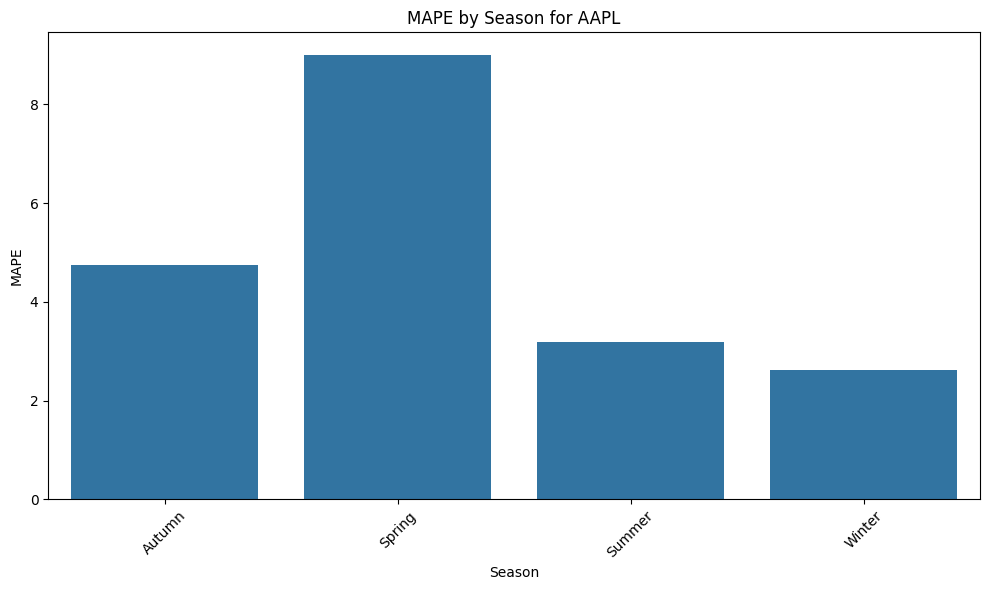

 - XGBoost model saved for AAPL at ../models/xgb_models/xgb_AAPL_model.json
Training and evaluation completed for AAPL.


Training and Evaluating XGBoost Model for MSFT
 - XGBoost model trained for MSFT
 - No Date information found for MSFT. Creating dummy dates.
 - Overall Evaluation Metrics for MSFT:
    RMSE = 51.3189
    MAE = 34.1369
    R2 = 0.4428
    MAPE = 8.27%


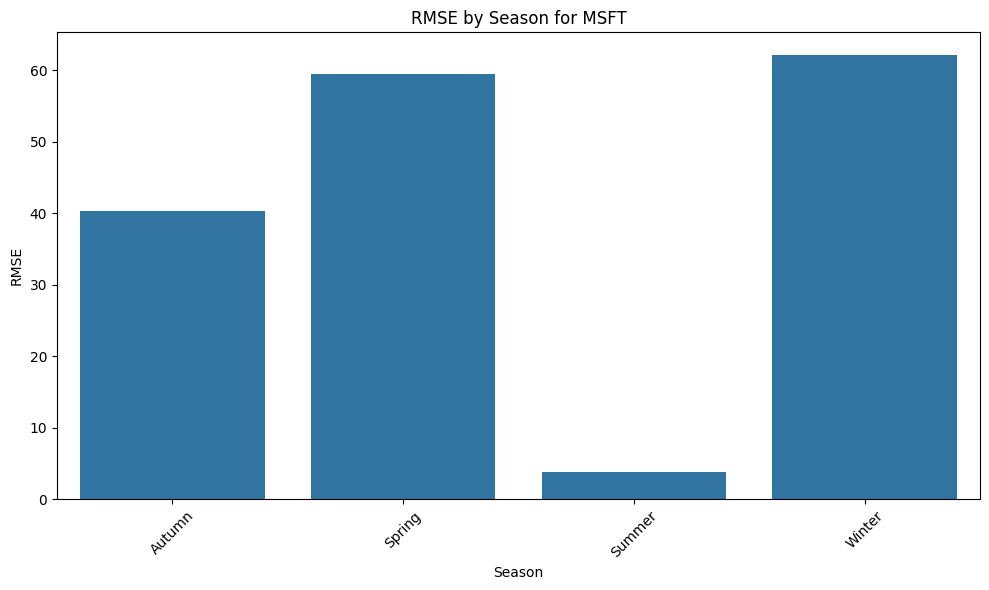

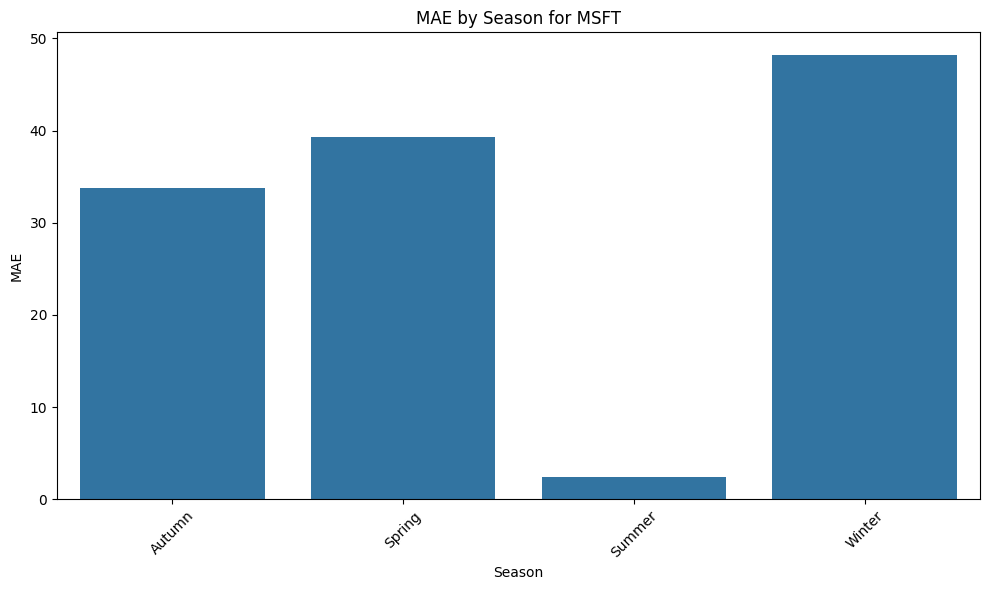

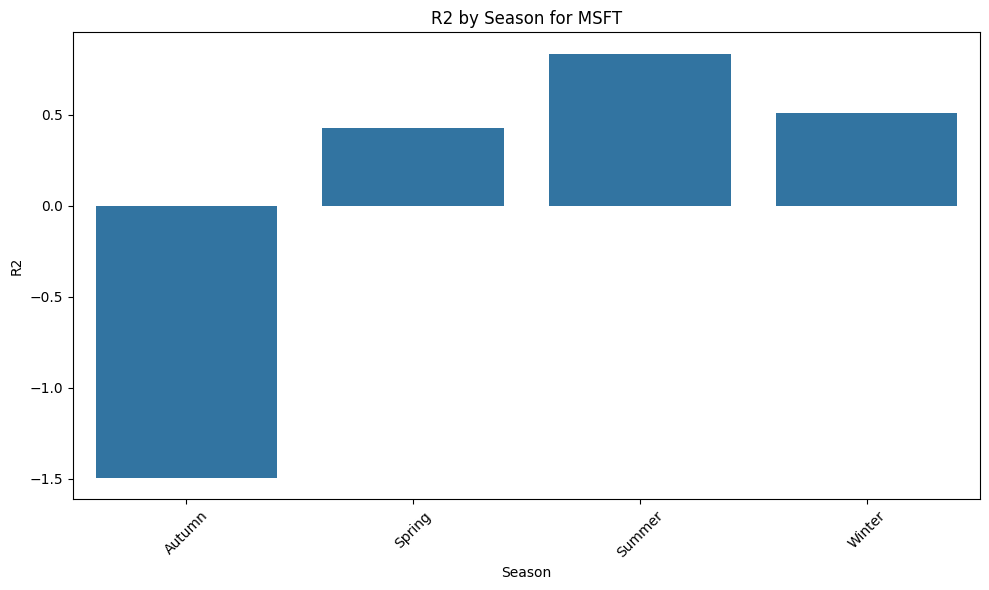

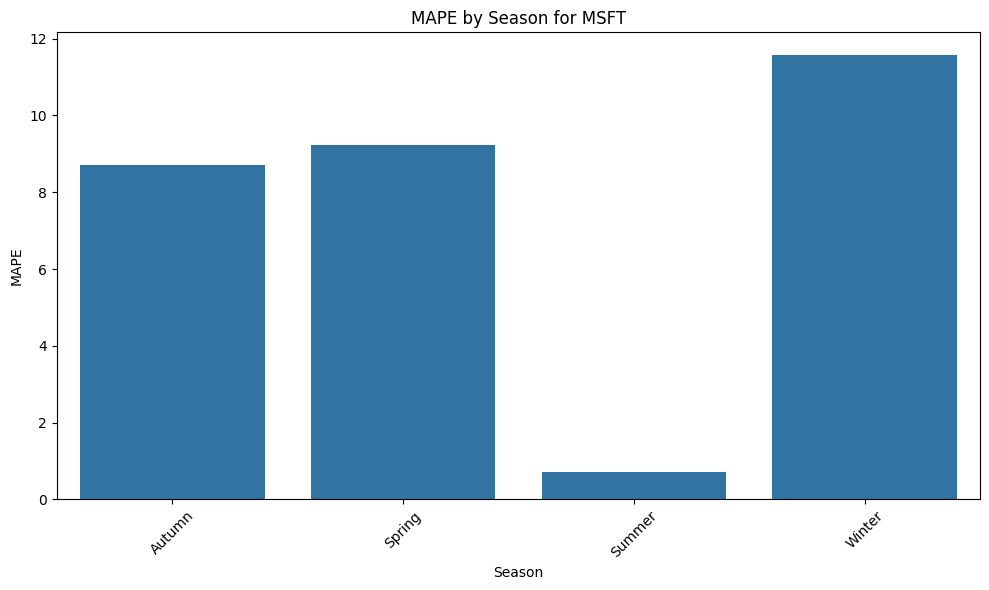

 - XGBoost model saved for MSFT at ../models/xgb_models/xgb_MSFT_model.json
Training and evaluation completed for MSFT.


Training and Evaluating XGBoost Model for GOOGL
 - XGBoost model trained for GOOGL
 - No Date information found for GOOGL. Creating dummy dates.
 - Overall Evaluation Metrics for GOOGL:
    RMSE = 11.6327
    MAE = 5.9582
    R2 = 0.8233
    MAPE = 3.63%


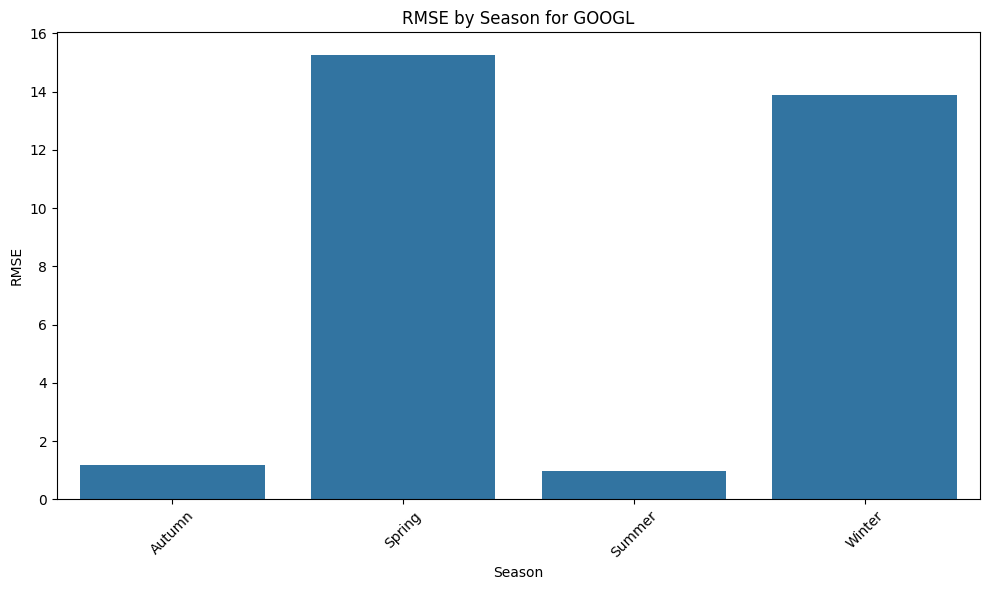

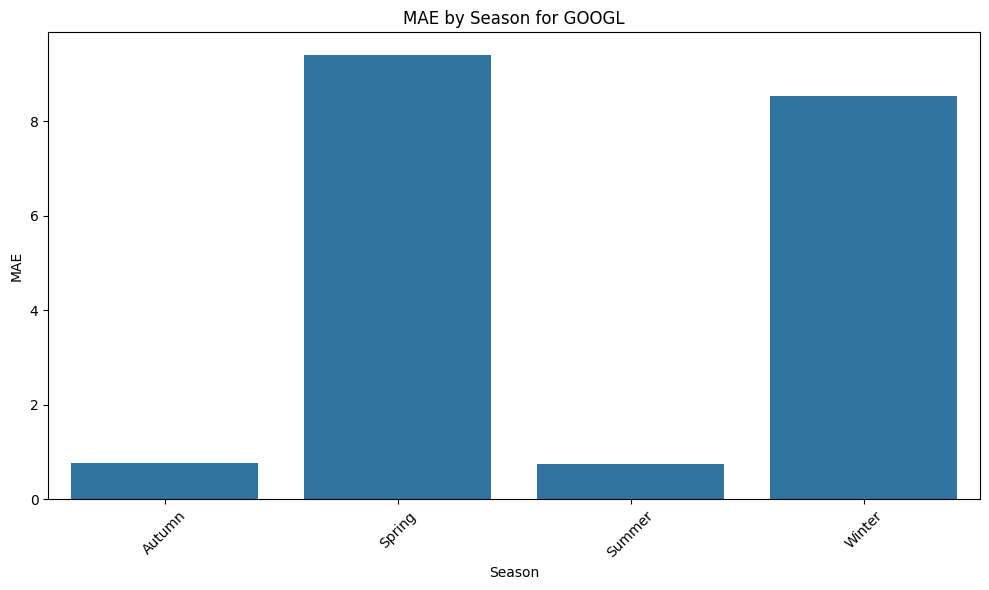

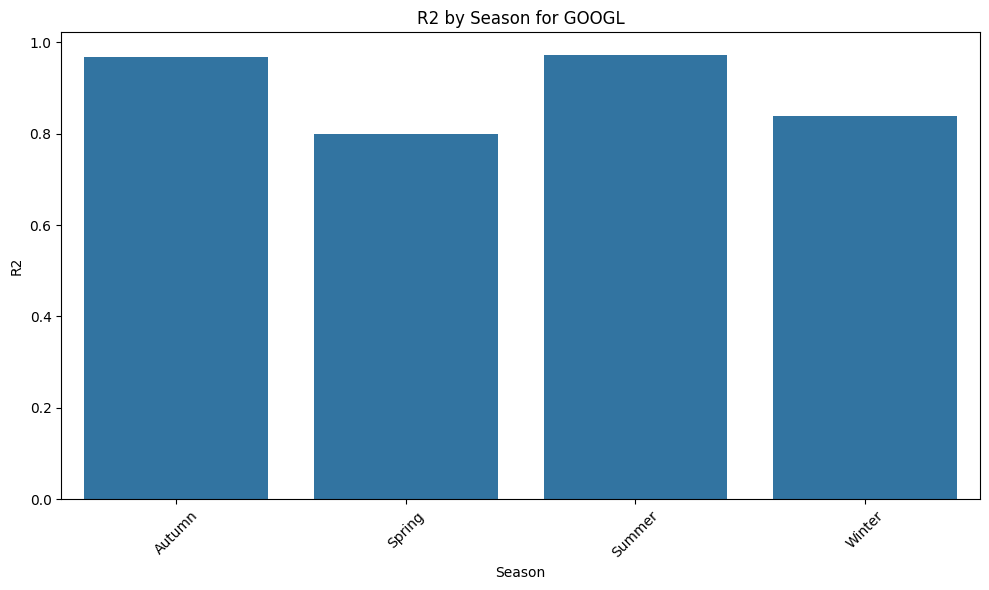

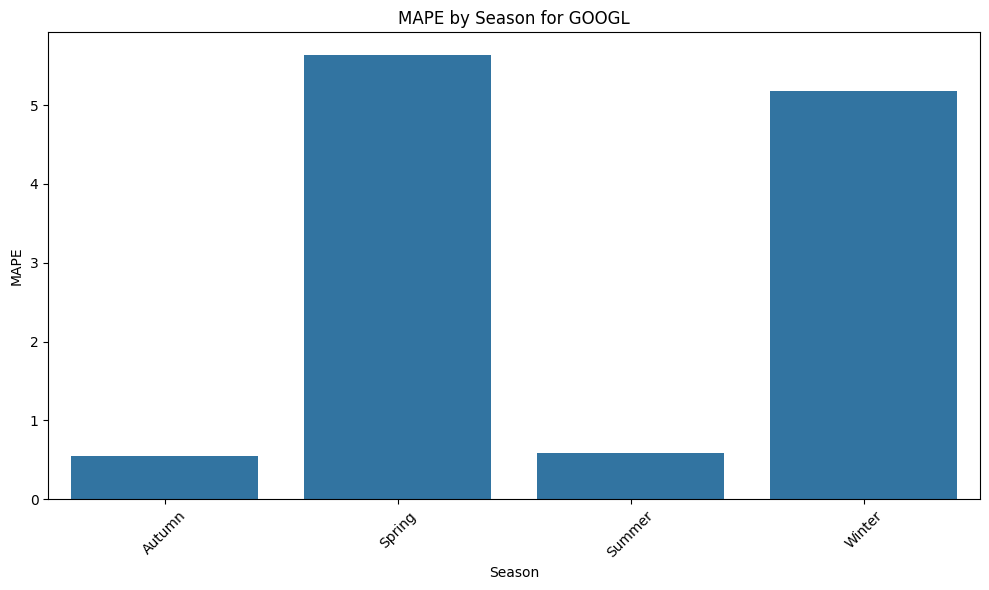

 - XGBoost model saved for GOOGL at ../models/xgb_models/xgb_GOOGL_model.json
Training and evaluation completed for GOOGL.


Training and Evaluating XGBoost Model for AMZN
 - XGBoost model trained for AMZN
 - No Date information found for AMZN. Creating dummy dates.
 - Overall Evaluation Metrics for AMZN:
    RMSE = 2.8855
    MAE = 1.5122
    R2 = 0.9930
    MAPE = 0.96%


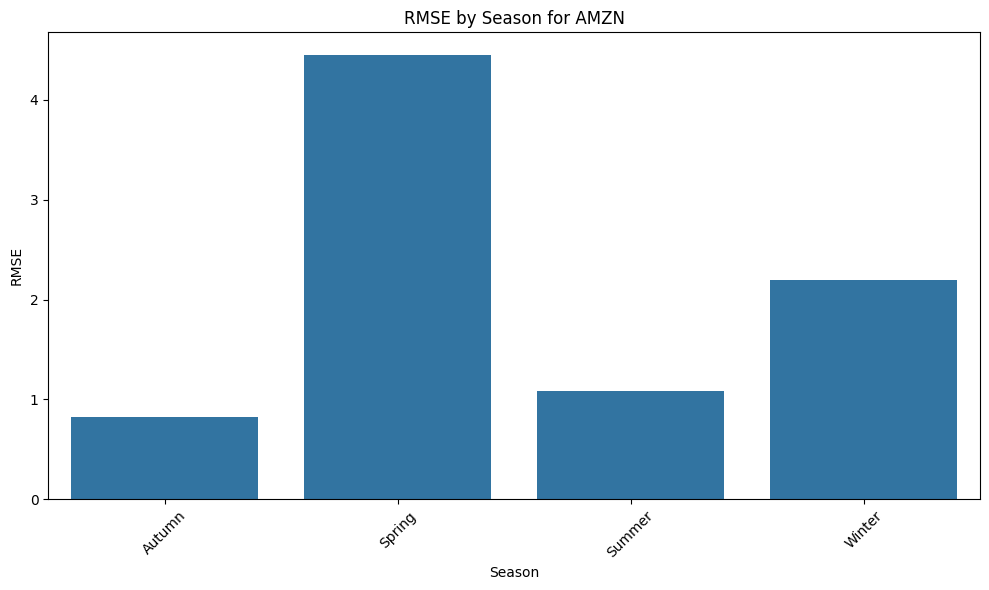

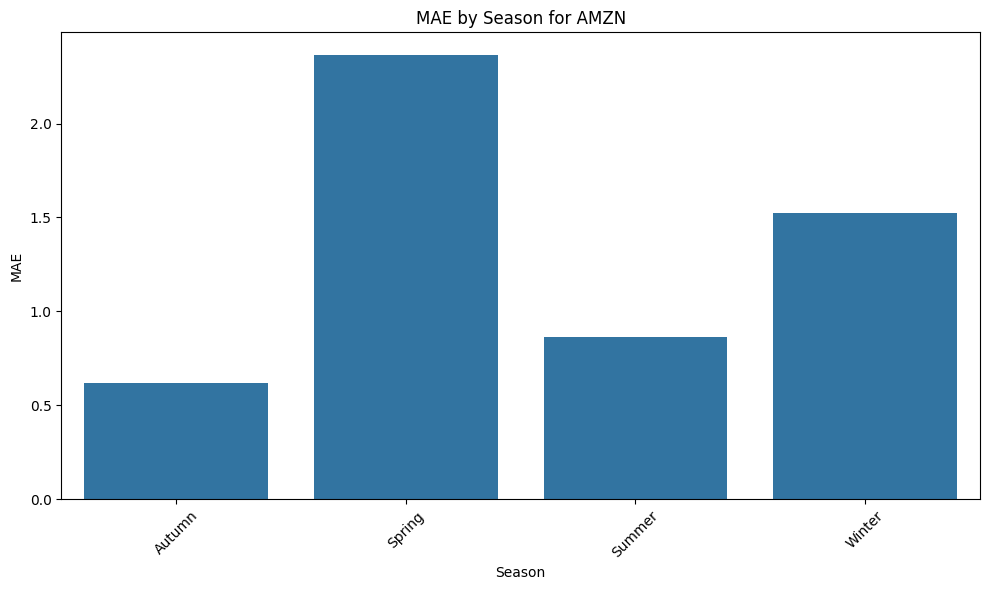

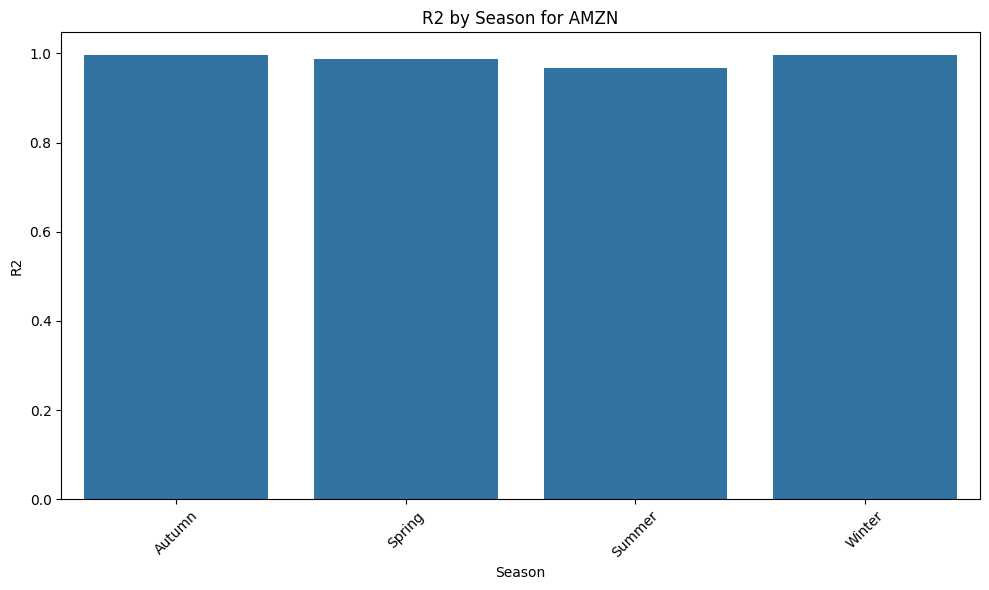

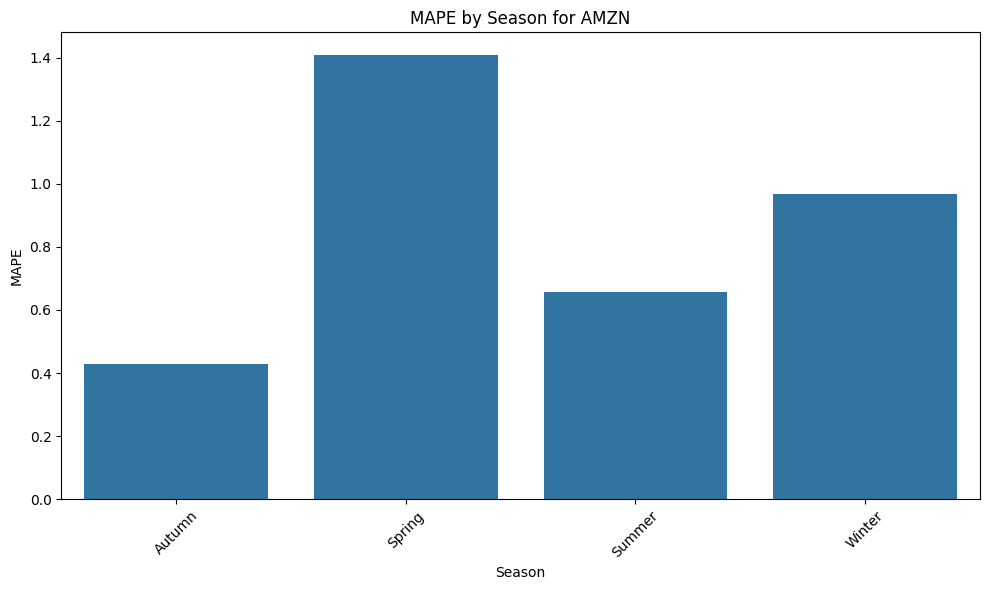

 - XGBoost model saved for AMZN at ../models/xgb_models/xgb_AMZN_model.json
Training and evaluation completed for AMZN.


Overall Evaluation Metrics for All Stocks - XGBoost


,RMSE,MAE,R2,MAPE
AAPL,18.981325,10.894937,0.437936,5.216034
MSFT,51.318905,34.136934,0.442845,8.270176
GOOGL,11.632747,5.958170,0.823297,3.629046
AMZN,2.885549,1.512229,0.992996,0.956724



 - Overall Evaluation Metrics table for XGBoost saved as 'overall_evaluation_metrics_xgb.csv'.

Month Evaluation Metrics for AAPL - XGBoost


,Month,RMSE,MAE,R2,MAPE
0,1,2.816993,1.566125,0.965352,0.906934
1,2,16.252713,10.683196,0.757183,5.319458
2,3,30.845709,21.848923,0.345401,9.909473
3,4,32.360054,23.263275,0.095894,10.467954
4,5,24.289133,12.384223,0.057895,5.516387
5,6,7.728637,6.185378,-1.082588,3.288165
6,7,11.459359,9.350836,-1.141160,4.872149
7,8,4.267251,2.596183,0.357544,1.411494
8,9,3.969583,2.612251,0.525556,1.425208
9,10,14.666966,14.368991,-19.483663,7.439751


 - Month Evaluation Metrics table for AAPL saved as 'AAPL_Month_evaluation_metrics_xgb.csv'.

Month Evaluation Metrics for MSFT - XGBoost


,Month,RMSE,MAE,R2,MAPE
0,1,51.863928,37.239635,0.651644,9.177222
1,2,64.884778,45.955971,0.539694,10.754681
2,3,70.553267,49.471486,0.432274,11.362077
3,4,57.110207,40.844359,0.429165,9.815199
4,5,41.897468,21.512408,0.381348,5.161018
5,6,2.240631,1.546285,0.825174,0.460506
6,7,5.914069,3.953347,0.736233,1.154907
7,8,2.120880,1.687924,0.923267,0.523234
8,9,14.875896,9.598652,0.158485,2.654867
9,10,34.041888,33.925973,-91.681289,9.070100


 - Month Evaluation Metrics table for MSFT saved as 'MSFT_Month_evaluation_metrics_xgb.csv'.

Month Evaluation Metrics for GOOGL - XGBoost


,Month,RMSE,MAE,R2,MAPE
0,1,10.429763,7.094874,0.903436,4.557038
1,2,19.669993,14.159408,0.785711,8.246639
2,3,21.810455,15.142327,0.717495,8.666334
3,4,9.795477,6.898438,0.899743,4.442956
4,5,8.186608,4.429533,0.882500,2.814060
5,6,0.969781,0.807879,0.843935,0.660320
6,7,1.194297,0.949336,0.923737,0.743452
7,8,0.633581,0.485452,0.948753,0.364906
8,9,0.868528,0.695766,0.975867,0.527830
9,10,0.732198,0.608074,0.953444,0.449815


 - Month Evaluation Metrics table for GOOGL saved as 'GOOGL_Month_evaluation_metrics_xgb.csv'.

Month Evaluation Metrics for AMZN - XGBoost


,Month,RMSE,MAE,R2,MAPE
0,1,2.425448,1.728554,0.996646,1.116018
1,2,2.412557,1.725914,0.997467,1.110685
2,3,6.483402,3.859578,0.978544,2.153467
3,4,2.151749,1.194329,0.997254,0.768194
4,5,2.925049,1.826406,0.992809,1.222489
5,6,0.927300,0.759501,0.932900,0.602846
6,7,1.169792,0.940655,0.916048,0.705446
7,8,1.136964,0.893801,0.962231,0.663485
8,9,0.933078,0.698197,0.982475,0.525526
9,10,0.848965,0.633197,0.929049,0.429324


 - Month Evaluation Metrics table for AMZN saved as 'AMZN_Month_evaluation_metrics_xgb.csv'.

Comparative RMSE Across Month for All Stocks - XGBoost


,AAPL,MSFT,GOOGL,AMZN
Month,,,,
1,2.816993,51.863928,10.429763,2.425448
2,16.252713,64.884778,19.669993,2.412557
3,30.845709,70.553267,21.810455,6.483402
4,32.360054,57.110207,9.795477,2.151749
5,24.289133,41.897468,8.186608,2.925049
6,7.728637,2.240631,0.969781,0.927300
7,11.459359,5.914069,1.194297,1.169792
8,4.267251,2.120880,0.633581,1.136964
9,3.969583,14.875896,0.868528,0.933078


 - Comparative RMSE Across Month table for XGBoost saved as 'comparative_RMSE_across_Month_xgb.csv'.

Comparative MAE Across Month for All Stocks - XGBoost


,AAPL,MSFT,GOOGL,AMZN
Month,,,,
1,1.566125,37.239635,7.094874,1.728554
2,10.683196,45.955971,14.159408,1.725914
3,21.848923,49.471486,15.142327,3.859578
4,23.263275,40.844359,6.898438,1.194329
5,12.384223,21.512408,4.429533,1.826406
6,6.185378,1.546285,0.807879,0.759501
7,9.350836,3.953347,0.949336,0.940655
8,2.596183,1.687924,0.485452,0.893801
9,2.612251,9.598652,0.695766,0.698197


 - Comparative MAE Across Month table for XGBoost saved as 'comparative_MAE_across_Month_xgb.csv'.

Comparative R2 Across Month for All Stocks - XGBoost


,AAPL,MSFT,GOOGL,AMZN
Month,,,,
1,0.965352,0.651644,0.903436,0.996646
2,0.757183,0.539694,0.785711,0.997467
3,0.345401,0.432274,0.717495,0.978544
4,0.095894,0.429165,0.899743,0.997254
5,0.057895,0.381348,0.882500,0.992809
6,-1.082588,0.825174,0.843935,0.932900
7,-1.141160,0.736233,0.923737,0.916048
8,0.357544,0.923267,0.948753,0.962231
9,0.525556,0.158485,0.975867,0.982475


 - Comparative R2 Across Month table for XGBoost saved as 'comparative_R2_across_Month_xgb.csv'.

Comparative MAPE Across Month for All Stocks - XGBoost


,AAPL,MSFT,GOOGL,AMZN
Month,,,,
1,0.906934,9.177222,4.557038,1.116018
2,5.319458,10.754681,8.246639,1.110685
3,9.909473,11.362077,8.666334,2.153467
4,10.467954,9.815199,4.442956,0.768194
5,5.516387,5.161018,2.814060,1.222489
6,3.288165,0.460506,0.660320,0.602846
7,4.872149,1.154907,0.743452,0.705446
8,1.411494,0.523234,0.364906,0.663485
9,1.425208,2.654867,0.527830,0.525526


 - Comparative MAPE Across Month table for XGBoost saved as 'comparative_MAPE_across_Month_xgb.csv'.

Quarter Evaluation Metrics for AAPL - XGBoost


,Quarter,RMSE,MAE,R2,MAPE
0,1,20.293287,11.384946,0.595786,5.380256
1,2,26.037375,15.947412,0.088105,7.274000
2,3,7.451323,4.877447,0.039829,2.582056
3,4,10.553380,8.754103,-0.581271,4.596559


 - Quarter Evaluation Metrics table for AAPL saved as 'AAPL_Quarter_evaluation_metrics_xgb.csv'.

Quarter Evaluation Metrics for MSFT - XGBoost


,Quarter,RMSE,MAE,R2,MAPE
0,1,62.867266,44.174474,0.540331,10.422394
1,2,45.215048,25.794342,0.423912,6.216251
2,3,9.244548,5.030859,0.587522,1.431178
3,4,58.536175,55.374364,-8.185846,13.799528


 - Quarter Evaluation Metrics table for MSFT saved as 'MSFT_Quarter_evaluation_metrics_xgb.csv'.

Quarter Evaluation Metrics for GOOGL - XGBoost


,Quarter,RMSE,MAE,R2,MAPE
0,1,17.945790,12.076203,0.791228,7.126561
1,2,8.070840,4.730943,0.896508,3.066896
2,3,0.928364,0.710342,0.970061,0.545587
3,4,1.530082,0.916898,0.939227,0.631978


 - Quarter Evaluation Metrics table for GOOGL saved as 'GOOGL_Quarter_evaluation_metrics_xgb.csv'.

Quarter Evaluation Metrics for AMZN - XGBoost


,Quarter,RMSE,MAE,R2,MAPE
0,1,4.271606,2.457686,0.990904,1.469708
1,2,2.235027,1.292576,0.995772,0.872512
2,3,1.086544,0.845805,0.964505,0.632638
3,4,0.835696,0.631334,0.995532,0.391479


 - Quarter Evaluation Metrics table for AMZN saved as 'AMZN_Quarter_evaluation_metrics_xgb.csv'.

Comparative RMSE Across Quarter for All Stocks - XGBoost


,AAPL,MSFT,GOOGL,AMZN
Quarter,,,,
1,20.293287,62.867266,17.945790,4.271606
2,26.037375,45.215048,8.070840,2.235027
3,7.451323,9.244548,0.928364,1.086544
4,10.553380,58.536175,1.530082,0.835696


 - Comparative RMSE Across Quarter table for XGBoost saved as 'comparative_RMSE_across_Quarter_xgb.csv'.

Comparative MAE Across Quarter for All Stocks - XGBoost


,AAPL,MSFT,GOOGL,AMZN
Quarter,,,,
1,11.384946,44.174474,12.076203,2.457686
2,15.947412,25.794342,4.730943,1.292576
3,4.877447,5.030859,0.710342,0.845805
4,8.754103,55.374364,0.916898,0.631334


 - Comparative MAE Across Quarter table for XGBoost saved as 'comparative_MAE_across_Quarter_xgb.csv'.

Comparative R2 Across Quarter for All Stocks - XGBoost


,AAPL,MSFT,GOOGL,AMZN
Quarter,,,,
1,0.595786,0.540331,0.791228,0.990904
2,0.088105,0.423912,0.896508,0.995772
3,0.039829,0.587522,0.970061,0.964505
4,-0.581271,-8.185846,0.939227,0.995532


 - Comparative R2 Across Quarter table for XGBoost saved as 'comparative_R2_across_Quarter_xgb.csv'.

Comparative MAPE Across Quarter for All Stocks - XGBoost


,AAPL,MSFT,GOOGL,AMZN
Quarter,,,,
1,5.380256,10.422394,7.126561,1.469708
2,7.274000,6.216251,3.066896,0.872512
3,2.582056,1.431178,0.545587,0.632638
4,4.596559,13.799528,0.631978,0.391479


 - Comparative MAPE Across Quarter table for XGBoost saved as 'comparative_MAPE_across_Quarter_xgb.csv'.

Season Evaluation Metrics for AAPL - XGBoost


,Season,RMSE,MAE,R2,MAPE
0,Autumn,10.733234,9.037106,-1.057676,4.741425
1,Spring,29.929283,19.988852,0.218844,9.010040
2,Summer,8.358328,6.042597,-0.306177,3.189542
3,Winter,10.258101,5.116069,0.806946,2.624060


 - Season Evaluation Metrics table for AAPL saved as 'AAPL_Season_evaluation_metrics_xgb.csv'.

Season Evaluation Metrics for MSFT - XGBoost


,Season,RMSE,MAE,R2,MAPE
0,Autumn,40.353068,33.775999,-1.496075,8.715114
1,Spring,59.460106,39.263205,0.428272,9.232898
2,Summer,3.865001,2.405087,0.837212,0.715625
3,Winter,62.205965,48.247552,0.509411,11.587545


 - Season Evaluation Metrics table for MSFT saved as 'MSFT_Season_evaluation_metrics_xgb.csv'.

Season Evaluation Metrics for GOOGL - XGBoost


,Season,RMSE,MAE,R2,MAPE
0,Autumn,1.177077,0.772298,0.968616,0.553670
1,Spring,15.268170,9.413137,0.799219,5.639672
2,Summer,0.960498,0.746900,0.973021,0.588790
3,Winter,13.882863,8.546112,0.837861,5.174585


 - Season Evaluation Metrics table for GOOGL saved as 'GOOGL_Season_evaluation_metrics_xgb.csv'.

Season Evaluation Metrics for AMZN - XGBoost


,Season,RMSE,MAE,R2,MAPE
0,Autumn,0.821795,0.619801,0.995700,0.428540
1,Spring,4.454772,2.367093,0.988330,1.409378
2,Summer,1.084930,0.865796,0.966691,0.657851
3,Winter,2.199109,1.521161,0.997366,0.968579


 - Season Evaluation Metrics table for AMZN saved as 'AMZN_Season_evaluation_metrics_xgb.csv'.

Comparative RMSE Across Season for All Stocks - XGBoost


,AAPL,MSFT,GOOGL,AMZN
Season,,,,
Autumn,10.733234,40.353068,1.177077,0.821795
Spring,29.929283,59.460106,15.268170,4.454772
Summer,8.358328,3.865001,0.960498,1.084930
Winter,10.258101,62.205965,13.882863,2.199109


 - Comparative RMSE Across Season table for XGBoost saved as 'comparative_RMSE_across_Season_xgb.csv'.

Comparative MAE Across Season for All Stocks - XGBoost


,AAPL,MSFT,GOOGL,AMZN
Season,,,,
Autumn,9.037106,33.775999,0.772298,0.619801
Spring,19.988852,39.263205,9.413137,2.367093
Summer,6.042597,2.405087,0.746900,0.865796
Winter,5.116069,48.247552,8.546112,1.521161


 - Comparative MAE Across Season table for XGBoost saved as 'comparative_MAE_across_Season_xgb.csv'.

Comparative R2 Across Season for All Stocks - XGBoost


,AAPL,MSFT,GOOGL,AMZN
Season,,,,
Autumn,-1.057676,-1.496075,0.968616,0.995700
Spring,0.218844,0.428272,0.799219,0.988330
Summer,-0.306177,0.837212,0.973021,0.966691
Winter,0.806946,0.509411,0.837861,0.997366


 - Comparative R2 Across Season table for XGBoost saved as 'comparative_R2_across_Season_xgb.csv'.

Comparative MAPE Across Season for All Stocks - XGBoost


,AAPL,MSFT,GOOGL,AMZN
Season,,,,
Autumn,4.741425,8.715114,0.553670,0.428540
Spring,9.010040,9.232898,5.639672,1.409378
Summer,3.189542,0.715625,0.588790,0.657851
Winter,2.624060,11.587545,5.174585,0.968579


 - Comparative MAPE Across Season table for XGBoost saved as 'comparative_MAPE_across_Season_xgb.csv'.


In [10]:
# Cell 9: Training and Evaluating XGBoost Models

# Define Parameters
TIMESTEPS = 60  # Ensure consistency with LSTM
model_save_dir = '../models/xgb_models'
os.makedirs(model_save_dir, exist_ok=True)

# Initialize dictionaries to store metrics
overall_metrics_xgb = {}
grouped_metrics_all_xgb = {'Month': {}, 'Quarter': {}, 'Season': {}}

# Function to Add Time Features
def add_time_features_xgb(eval_df):
    eval_df['Month'] = eval_df['Date'].dt.month
    eval_df['Quarter'] = eval_df['Date'].dt.quarter
    eval_df['Season'] = eval_df['Month'].apply(
        lambda month: 'Winter' if month in [12, 1, 2] else
                      'Spring' if month in [3, 4, 5] else
                      'Summer' if month in [6, 7, 8] else
                      'Autumn'
    )
    return eval_df

# Iterate Through Each Stock for Evaluation and Plotting
for stock in scaled_daily_data.keys():
    print(f"\n{'='*50}\nTraining and Evaluating XGBoost Model for {stock}\n{'='*50}")
    
    # Retrieve Scaled Data
    data = scaled_daily_data[stock]
    X_train_scaled = data['X_train_scaled']
    y_train_scaled = data['y_train_scaled']
    X_test_scaled = data['X_test_scaled']
    y_test_scaled = data['y_test_scaled']
    scaler_y = data['scaler_y']

    # Initialize and Train XGBoost Regressor
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    
    xgb_model.fit(X_train_scaled, y_train_scaled)
    print(f" - XGBoost model trained for {stock}")
    
    # Predict on Test Data
    predictions_scaled = xgb_model.predict(X_test_scaled)
    
    # Inverse Transform Predictions and Targets
    predictions = scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1)).flatten()
    y_test = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
    
    # Create Evaluation DataFrame
    if isinstance(X_test_scaled, pd.DataFrame) and isinstance(X_test_scaled.index, pd.DatetimeIndex):
        dates = X_test_scaled.index
    elif isinstance(X_test_scaled, pd.DataFrame) and 'Date' in X_test_scaled.columns:
        dates = pd.to_datetime(X_test_scaled['Date'])
    else:
        print(f" - No Date information found for {stock}. Creating dummy dates.")
        dates = pd.date_range(start='2020-01-01', periods=len(y_test), freq='D')
    
    eval_df = pd.DataFrame({
        'Date': dates,
        'Actual': y_test,
        'Predicted': predictions
    })
    
    # Add Time Features
    eval_df = add_time_features_xgb(eval_df)
    
    # Calculate Overall Metrics
    rmse = np.sqrt(mean_squared_error(eval_df['Actual'], eval_df['Predicted']))
    mae = mean_absolute_error(eval_df['Actual'], eval_df['Predicted'])
    r2 = r2_score(eval_df['Actual'], eval_df['Predicted'])
    mape = mean_absolute_percentage_error(eval_df['Actual'], eval_df['Predicted']) * 100
    
    overall_metrics_xgb[stock] = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape
    }
    
    print(f" - Overall Evaluation Metrics for {stock}:")
    print(f"    RMSE = {rmse:.4f}")
    print(f"    MAE = {mae:.4f}")
    print(f"    R2 = {r2:.4f}")
    print(f"    MAPE = {mape:.2f}%")
    
    # Calculate Grouped Metrics
    grouped_metrics_month = eval_df.groupby('Month').apply(lambda x: pd.Series({
        'RMSE': np.sqrt(mean_squared_error(x['Actual'], x['Predicted'])),
        'MAE': mean_absolute_error(x['Actual'], x['Predicted']),
        'R2': r2_score(x['Actual'], x['Predicted']),
        'MAPE': mean_absolute_percentage_error(x['Actual'], x['Predicted']) * 100
    }), include_groups=False)
    
    grouped_metrics_quarter = eval_df.groupby('Quarter').apply(lambda x: pd.Series({
        'RMSE': np.sqrt(mean_squared_error(x['Actual'], x['Predicted'])),
        'MAE': mean_absolute_error(x['Actual'], x['Predicted']),
        'R2': r2_score(x['Actual'], x['Predicted']),
        'MAPE': mean_absolute_percentage_error(x['Actual'], x['Predicted']) * 100
    }), include_groups=False)
    
    grouped_metrics_season = eval_df.groupby('Season').apply(lambda x: pd.Series({
        'RMSE': np.sqrt(mean_squared_error(x['Actual'], x['Predicted'])),
        'MAE': mean_absolute_error(x['Actual'], x['Predicted']),
        'R2': r2_score(x['Actual'], x['Predicted']),
        'MAPE': mean_absolute_percentage_error(x['Actual'], x['Predicted']) * 100
    }), include_groups=False)
    
    grouped_metrics_all_xgb['Month'][stock] = grouped_metrics_month
    grouped_metrics_all_xgb['Quarter'][stock] = grouped_metrics_quarter
    grouped_metrics_all_xgb['Season'][stock] = grouped_metrics_season
    
    # Plot Metrics by Season
    plot_metrics_by_group(grouped_metrics_season, stock, 'Season', 'RMSE')
    plot_metrics_by_group(grouped_metrics_season, stock, 'Season', 'MAE')
    plot_metrics_by_group(grouped_metrics_season, stock, 'Season', 'R2')
    plot_metrics_by_group(grouped_metrics_season, stock, 'Season', 'MAPE')
    
    # Save the trained model
    model_save_path = os.path.join(model_save_dir, f'xgb_{stock}_model.json')
    xgb_model.save_model(model_save_path)
    print(f" - XGBoost model saved for {stock} at {model_save_path}")
    
    print(f"Training and evaluation completed for {stock}.\n")

# Create Overall Metrics Table
overall_metrics_xgb_df = pd.DataFrame(overall_metrics_xgb).T
print("\n" + "="*50)
print("Overall Evaluation Metrics for All Stocks - XGBoost")
print("="*50)
display(overall_metrics_xgb_df)
overall_metrics_xgb_df.to_csv('overall_evaluation_metrics_xgb.csv')
print("\n - Overall Evaluation Metrics table for XGBoost saved as 'overall_evaluation_metrics_xgb.csv'.")

# Function to Create Grouped Metrics Tables
def create_grouped_metrics_tables_xgb(grouped_metrics_all_xgb, grouping):
    grouped_metrics_tables_xgb = {}
    for stock, metrics in grouped_metrics_all_xgb[grouping].items():
        metrics_df = metrics.reset_index()
        metrics_df.columns = [grouping] + list(metrics_df.columns[1:])
        grouped_metrics_tables_xgb[stock] = metrics_df
    return grouped_metrics_tables_xgb

# Create and Save Grouped Metrics Tables
for grouping in ['Month', 'Quarter', 'Season']:
    grouped_tables_xgb = create_grouped_metrics_tables_xgb(grouped_metrics_all_xgb, grouping)
    for stock, table in grouped_tables_xgb.items():
        print(f"\n{'='*50}\n{grouping} Evaluation Metrics for {stock} - XGBoost\n{'='*50}")
        display(table)
        filename = f'{stock}_{grouping}_evaluation_metrics_xgb.csv'
        table.to_csv(filename, index=False)
        print(f" - {grouping} Evaluation Metrics table for {stock} saved as '{filename}'.")
    
    # Create Comparative Metrics Tables Across Stocks
    for metric in ['RMSE', 'MAE', 'R2', 'MAPE']:
        comparative_df_xgb = pd.DataFrame({stock: grouped_metrics_all_xgb[grouping][stock][metric] for stock in grouped_metrics_all_xgb[grouping].keys()})
        comparative_df_xgb.index.name = grouping
        print(f"\n{'='*50}\nComparative {metric} Across {grouping} for All Stocks - XGBoost\n{'='*50}")
        display(comparative_df_xgb)
        filename = f'comparative_{metric}_across_{grouping}_xgb.csv'
        comparative_df_xgb.to_csv(filename)
        print(f" - Comparative {metric} Across {grouping} table for XGBoost saved as '{filename}'.")



Training and Evaluating Random Forest Model for AAPL
 - Random Forest model trained for AAPL
 - No Date information found for AAPL. Creating dummy dates.
 - Overall Evaluation Metrics for AAPL:
    RMSE = 18.7394
    MAE = 10.6838
    R2 = 0.4522
    MAPE = 5.12%


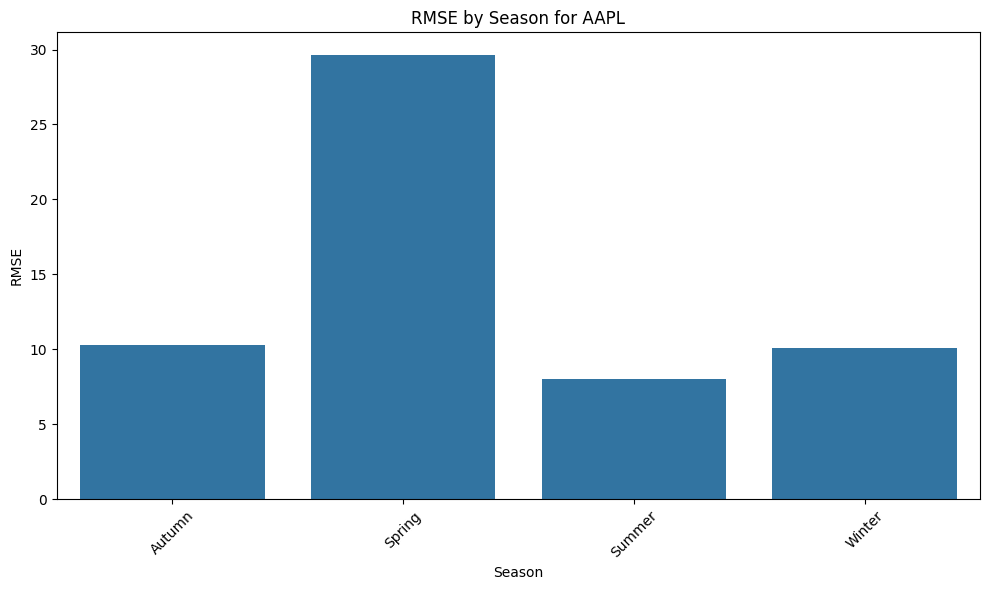

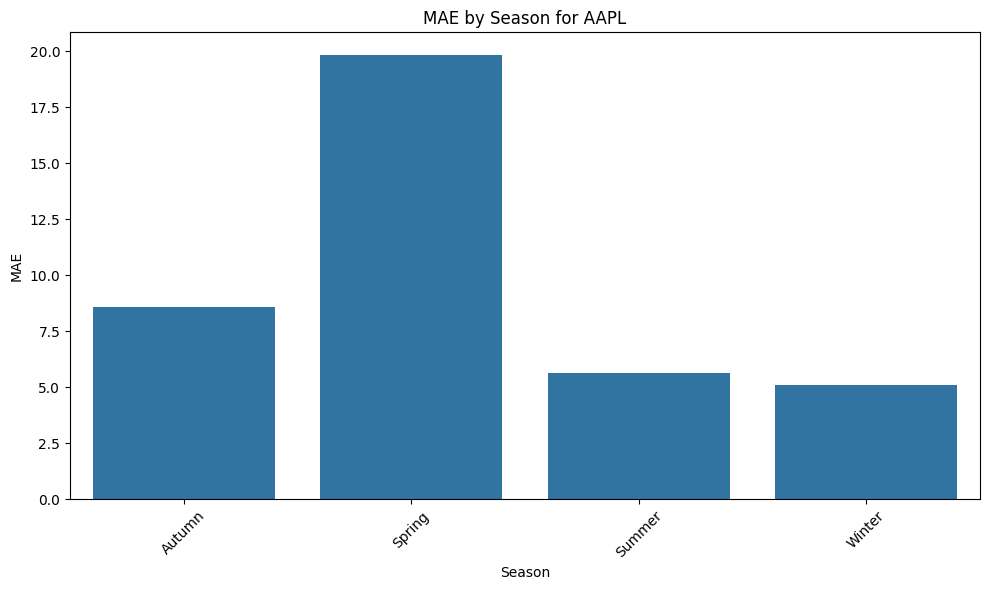

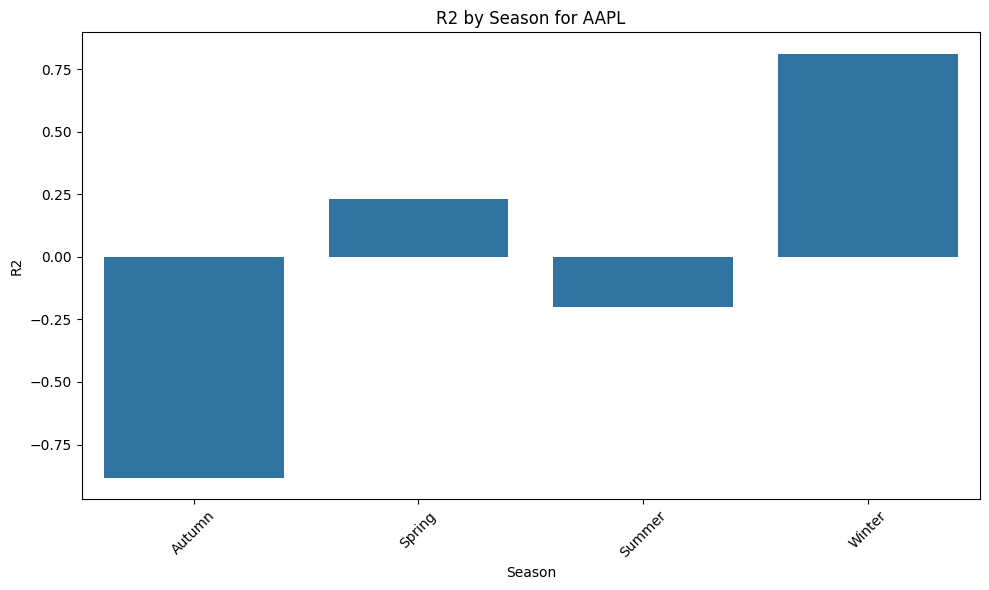

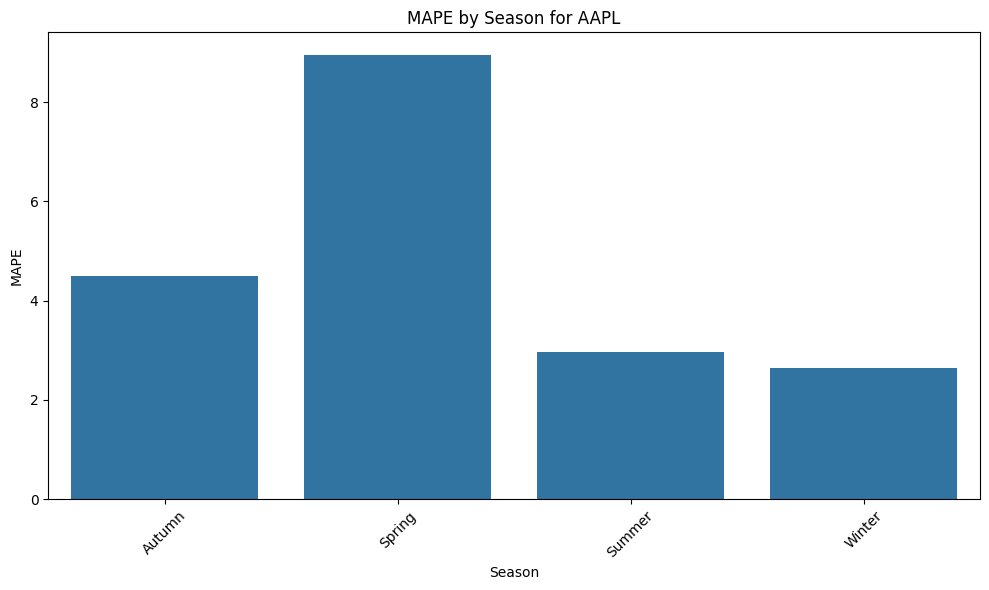

 - Random Forest model saved for AAPL at ../models/random_forest_models/rf_AAPL_model.pkl
Training and evaluation completed for AAPL.


Training and Evaluating Random Forest Model for MSFT
 - Random Forest model trained for MSFT
 - No Date information found for MSFT. Creating dummy dates.
 - Overall Evaluation Metrics for MSFT:
    RMSE = 50.7126
    MAE = 33.7040
    R2 = 0.4559
    MAPE = 8.17%


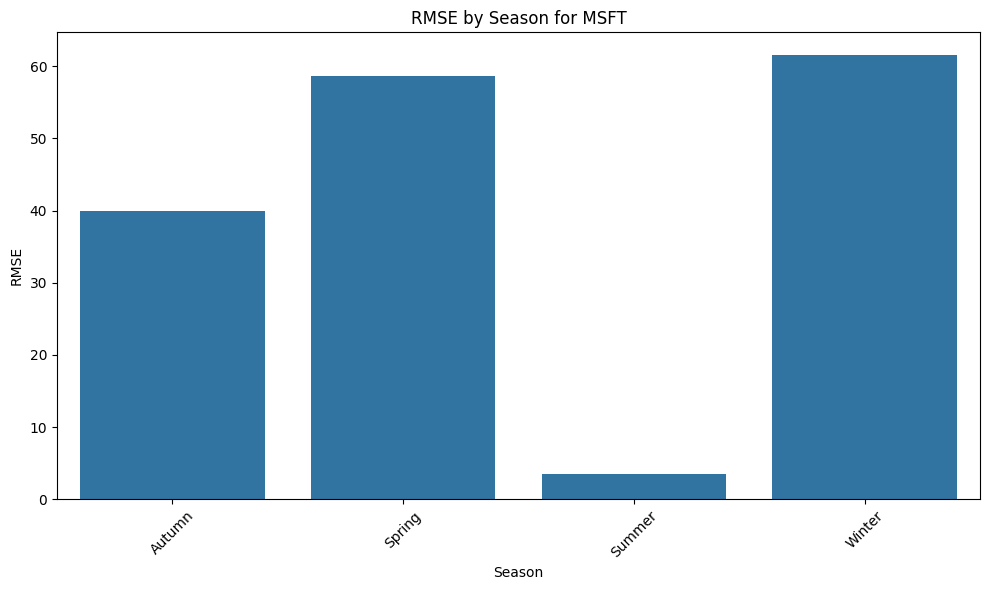

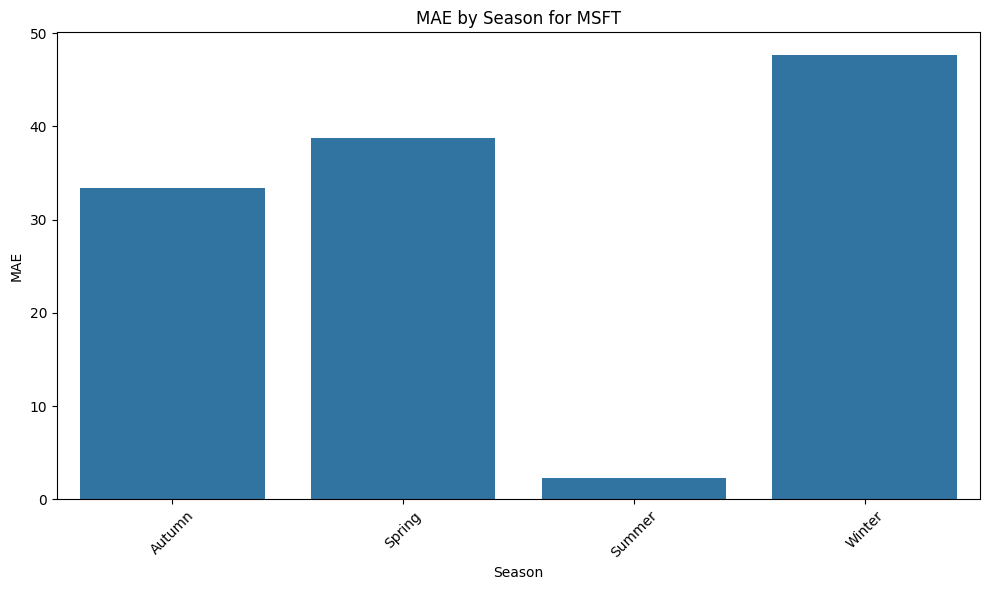

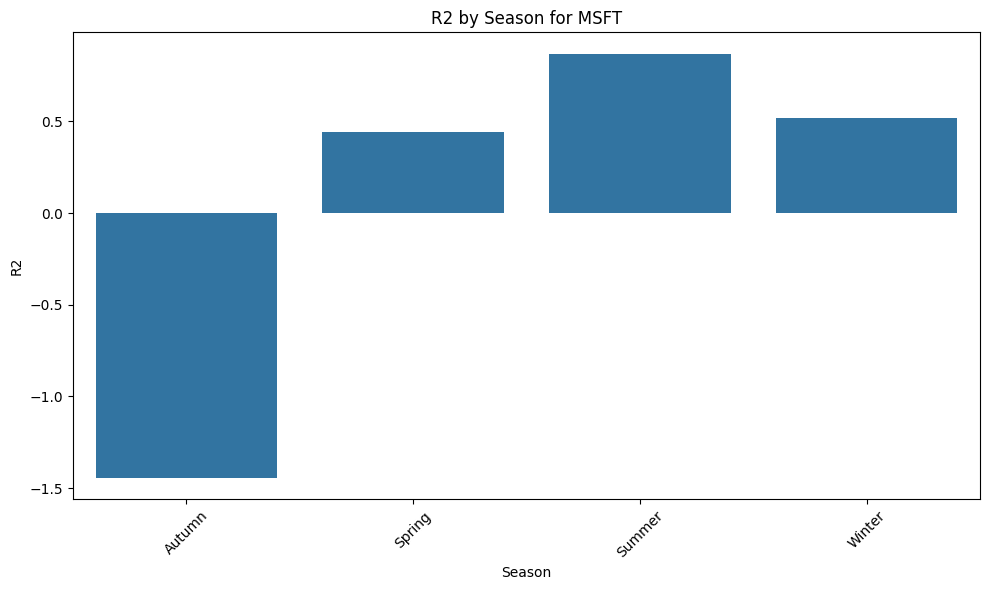

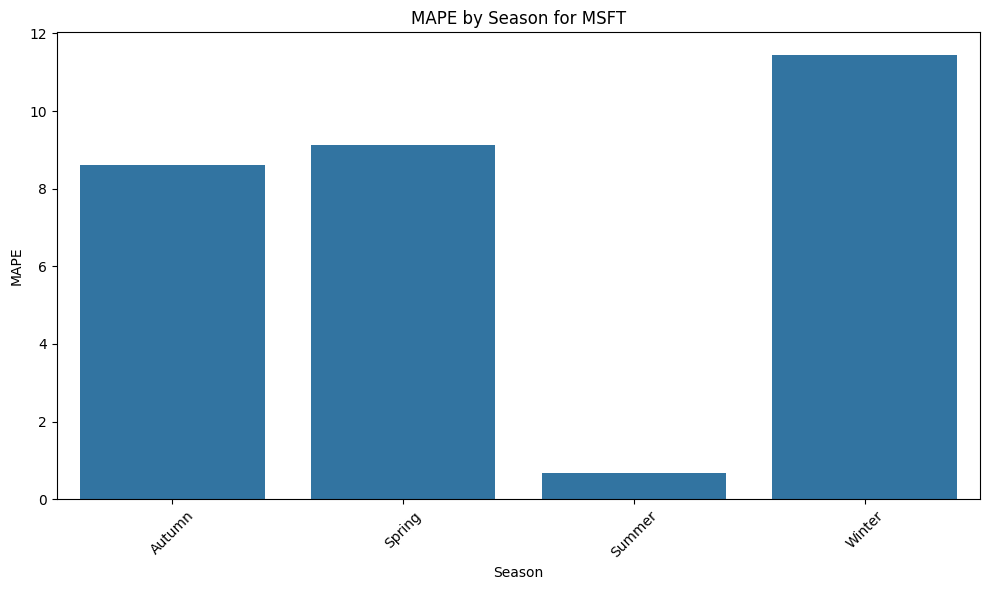

 - Random Forest model saved for MSFT at ../models/random_forest_models/rf_MSFT_model.pkl
Training and evaluation completed for MSFT.


Training and Evaluating Random Forest Model for GOOGL
 - Random Forest model trained for GOOGL
 - No Date information found for GOOGL. Creating dummy dates.
 - Overall Evaluation Metrics for GOOGL:
    RMSE = 11.4038
    MAE = 5.9725
    R2 = 0.8302
    MAPE = 3.71%


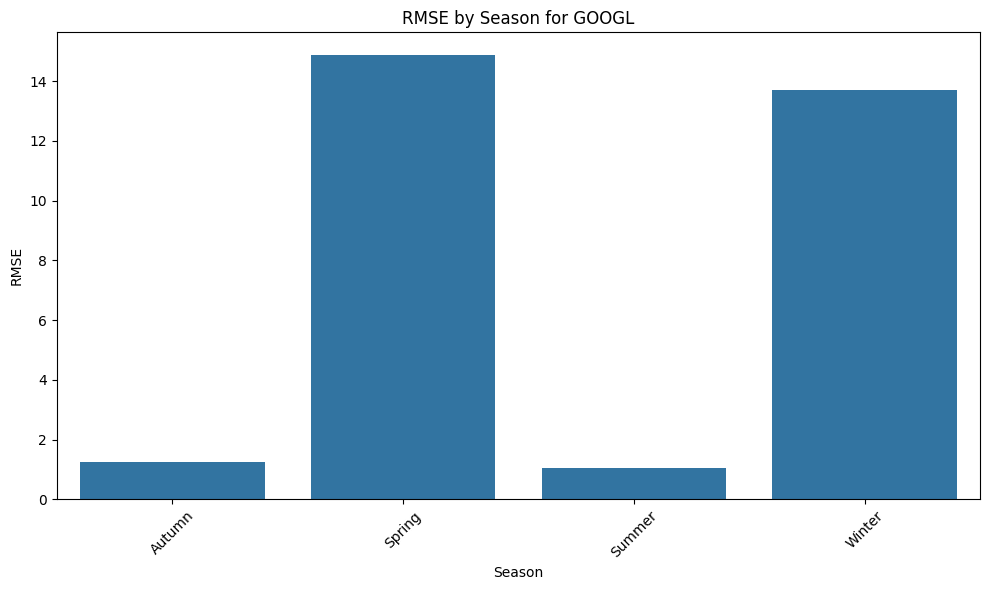

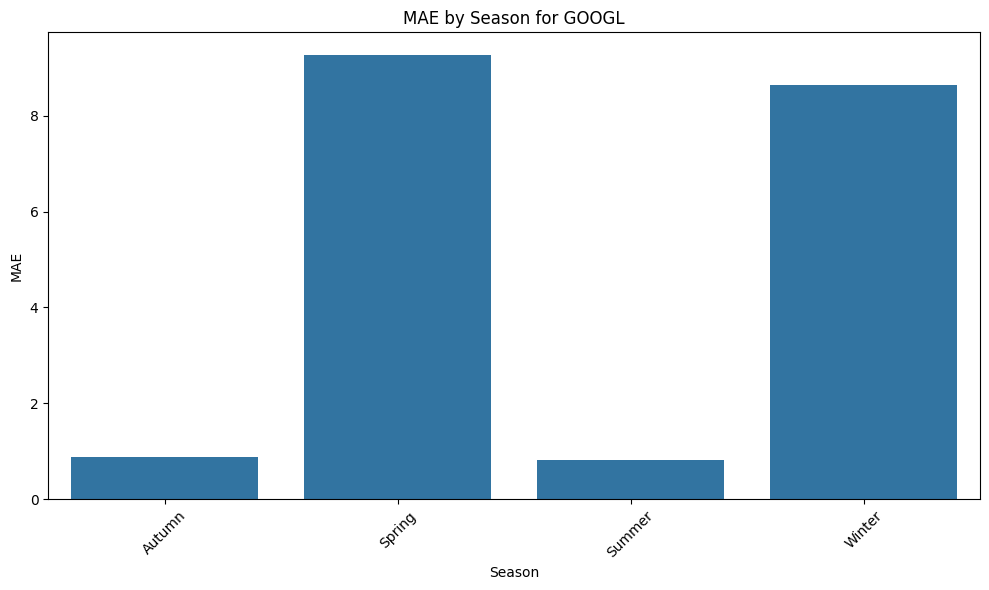

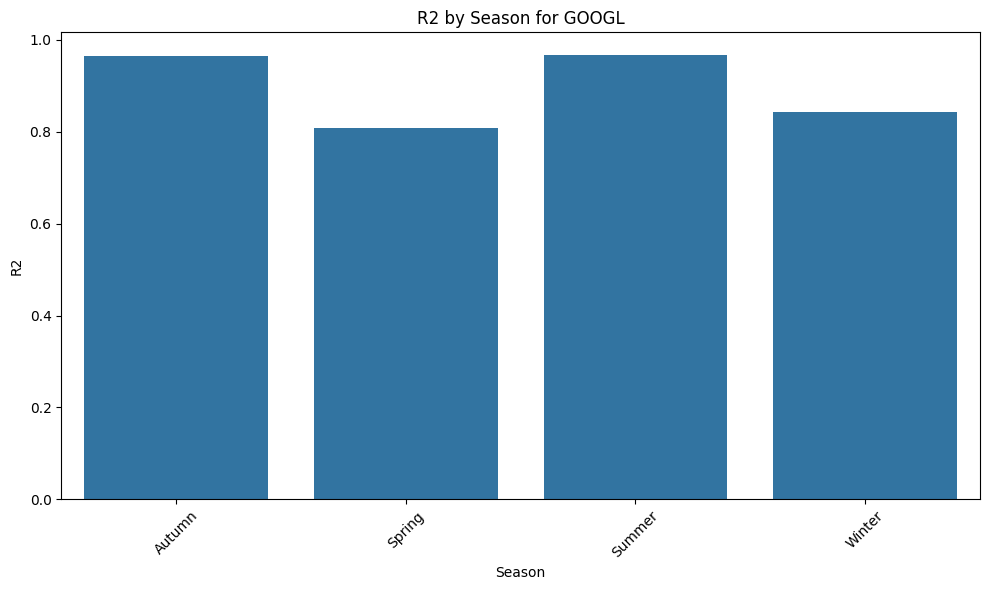

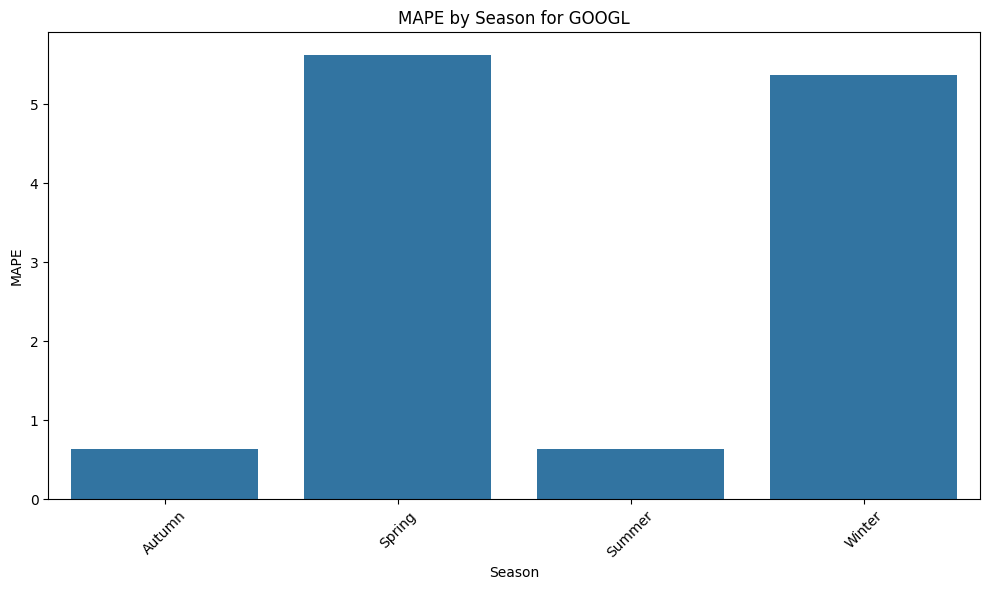

 - Random Forest model saved for GOOGL at ../models/random_forest_models/rf_GOOGL_model.pkl
Training and evaluation completed for GOOGL.


Training and Evaluating Random Forest Model for AMZN
 - Random Forest model trained for AMZN
 - No Date information found for AMZN. Creating dummy dates.
 - Overall Evaluation Metrics for AMZN:
    RMSE = 2.9358
    MAE = 1.5728
    R2 = 0.9927
    MAPE = 1.01%


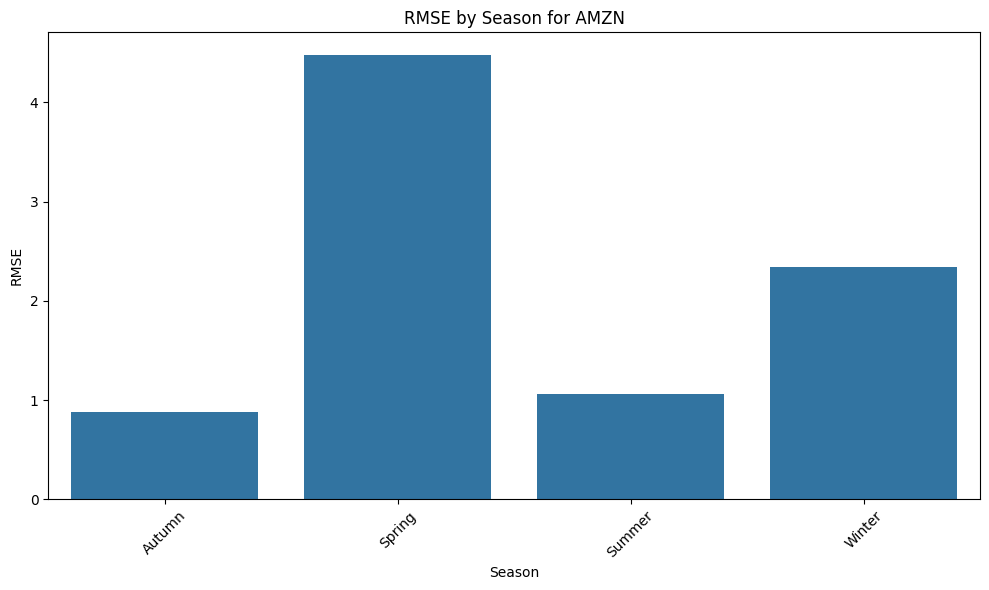

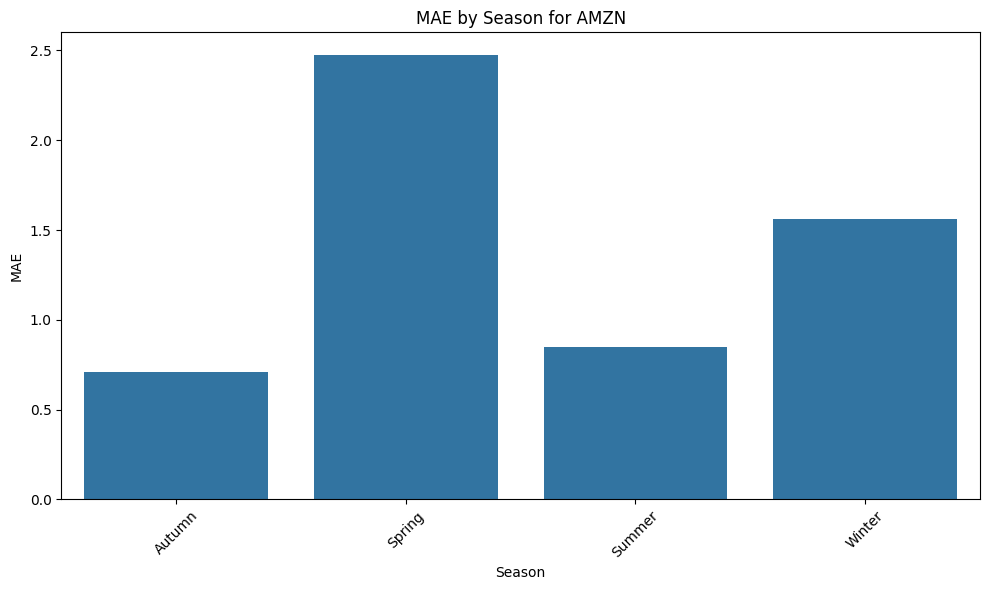

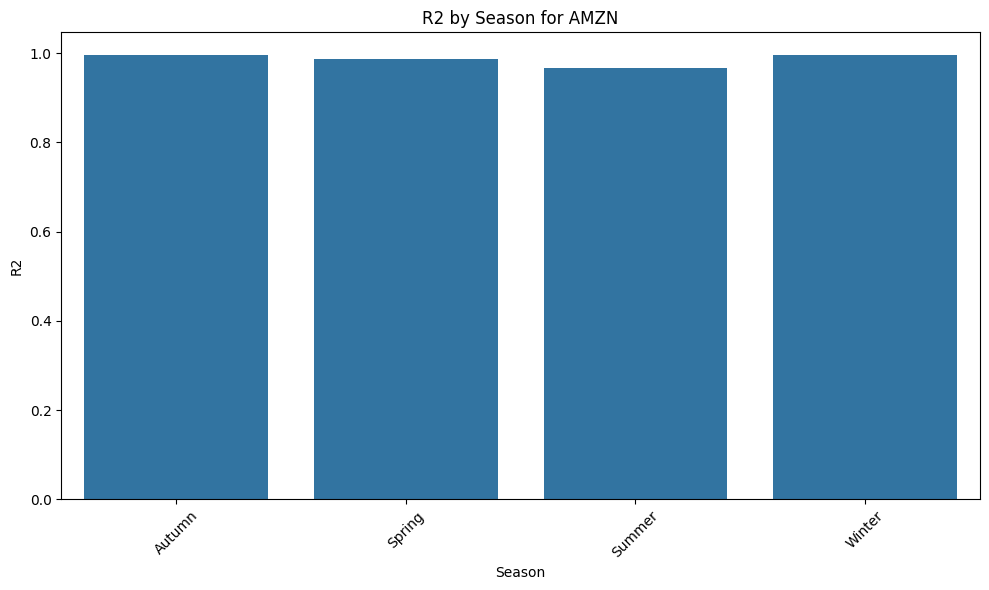

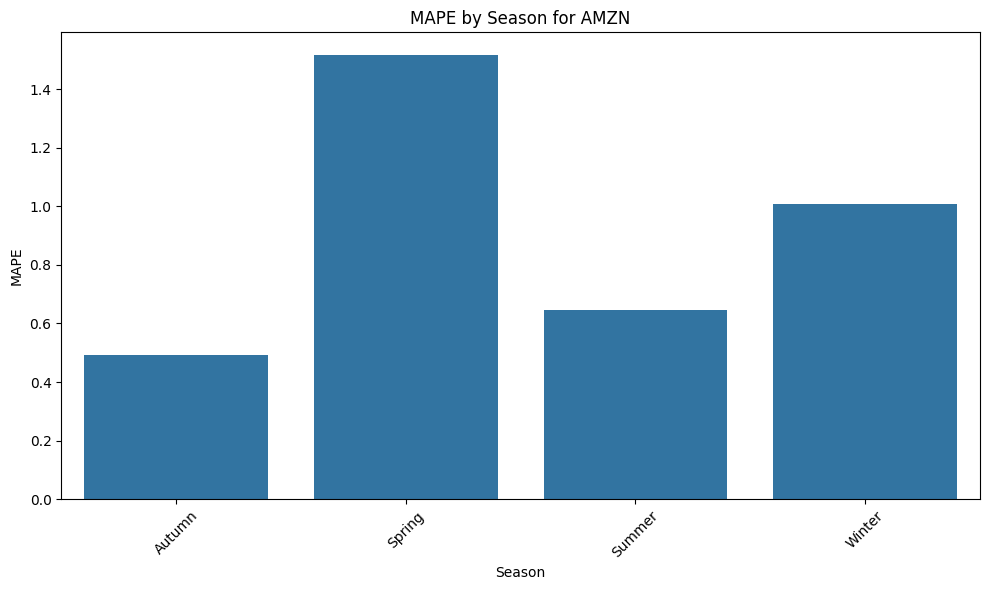

 - Random Forest model saved for AMZN at ../models/random_forest_models/rf_AMZN_model.pkl
Training and evaluation completed for AMZN.


Overall Evaluation Metrics for All Stocks - Random Forest


,RMSE,MAE,R2,MAPE
AAPL,18.739384,10.683804,0.452174,5.118285
MSFT,50.712634,33.704045,0.455932,8.168107
GOOGL,11.403793,5.972464,0.830184,3.709976
AMZN,2.935752,1.572785,0.992750,1.013254



 - Overall Evaluation Metrics table for Random Forest saved as 'overall_evaluation_metrics_rf.csv'.

Month Evaluation Metrics for AAPL - Random Forest


,Month,RMSE,MAE,R2,MAPE
0,1,2.707943,1.722608,0.967982,1.018254
1,2,16.008907,10.614724,0.764413,5.326963
2,3,30.513935,21.714263,0.359407,9.872764
3,4,32.161359,23.111708,0.106962,10.399049
4,5,24.012581,12.259595,0.079226,5.464763
5,6,7.411206,5.884096,-0.915029,3.127023
6,7,11.030009,8.701523,-0.983719,4.520580
7,8,3.977632,2.338615,0.441792,1.269958
8,9,3.824073,2.529883,0.559701,1.381783
9,10,14.091268,13.713623,-17.907201,7.096342


 - Month Evaluation Metrics table for AAPL saved as 'AAPL_Month_evaluation_metrics_rf.csv'.

Month Evaluation Metrics for MSFT - Random Forest


,Month,RMSE,MAE,R2,MAPE
0,1,51.011534,36.572280,0.663001,9.016595
1,2,64.497430,45.619594,0.545174,10.669050
2,3,69.637457,48.903703,0.446917,11.256993
3,4,56.226790,40.220007,0.446688,9.670524
4,5,41.245965,21.326946,0.400438,5.130843
5,6,1.991587,1.502719,0.861878,0.448787
6,7,5.092851,3.247100,0.804399,0.947416
7,8,2.399415,1.984899,0.901788,0.612429
8,9,14.253897,9.294328,0.227386,2.575857
9,10,33.570995,33.415131,-89.134947,8.932086


 - Month Evaluation Metrics table for MSFT saved as 'MSFT_Month_evaluation_metrics_rf.csv'.

Month Evaluation Metrics for GOOGL - Random Forest


,Month,RMSE,MAE,R2,MAPE
0,1,10.204830,7.097576,0.907556,4.695459
1,2,19.456458,14.419792,0.790338,8.641691
2,3,21.328601,15.007084,0.729840,8.720254
3,4,9.412029,6.669701,0.907438,4.338735
4,5,7.973831,4.417683,0.888529,2.843344
5,6,0.957063,0.740005,0.848002,0.604433
6,7,1.235002,1.000695,0.918450,0.781009
7,8,0.910356,0.687589,0.894199,0.519674
8,9,0.958182,0.727624,0.970628,0.550507
9,10,0.893940,0.715137,0.930603,0.529317


 - Month Evaluation Metrics table for GOOGL saved as 'GOOGL_Month_evaluation_metrics_rf.csv'.

Month Evaluation Metrics for AMZN - Random Forest


,Month,RMSE,MAE,R2,MAPE
0,1,2.682689,1.892217,0.995897,1.240705
1,2,2.489526,1.672645,0.997303,1.088090
2,3,6.507573,3.995959,0.978384,2.304277
3,4,2.199973,1.334430,0.997129,0.887512
4,5,2.962927,1.853377,0.992622,1.250442
5,6,1.048304,0.834078,0.914246,0.664004
6,7,0.978351,0.838890,0.941278,0.625345
7,8,1.156493,0.871913,0.960922,0.649804
8,9,1.048904,0.782845,0.977854,0.596458
9,10,0.896754,0.772892,0.920837,0.523047


 - Month Evaluation Metrics table for AMZN saved as 'AMZN_Month_evaluation_metrics_rf.csv'.

Comparative RMSE Across Month for All Stocks - Random Forest


,AAPL,MSFT,GOOGL,AMZN
Month,,,,
1,2.707943,51.011534,10.204830,2.682689
2,16.008907,64.497430,19.456458,2.489526
3,30.513935,69.637457,21.328601,6.507573
4,32.161359,56.226790,9.412029,2.199973
5,24.012581,41.245965,7.973831,2.962927
6,7.411206,1.991587,0.957063,1.048304
7,11.030009,5.092851,1.235002,0.978351
8,3.977632,2.399415,0.910356,1.156493
9,3.824073,14.253897,0.958182,1.048904


 - Comparative RMSE Across Month table for Random Forest saved as 'comparative_RMSE_across_Month_rf.csv'.

Comparative MAE Across Month for All Stocks - Random Forest


,AAPL,MSFT,GOOGL,AMZN
Month,,,,
1,1.722608,36.572280,7.097576,1.892217
2,10.614724,45.619594,14.419792,1.672645
3,21.714263,48.903703,15.007084,3.995959
4,23.111708,40.220007,6.669701,1.334430
5,12.259595,21.326946,4.417683,1.853377
6,5.884096,1.502719,0.740005,0.834078
7,8.701523,3.247100,1.000695,0.838890
8,2.338615,1.984899,0.687589,0.871913
9,2.529883,9.294328,0.727624,0.782845


 - Comparative MAE Across Month table for Random Forest saved as 'comparative_MAE_across_Month_rf.csv'.

Comparative R2 Across Month for All Stocks - Random Forest


,AAPL,MSFT,GOOGL,AMZN
Month,,,,
1,0.967982,0.663001,0.907556,0.995897
2,0.764413,0.545174,0.790338,0.997303
3,0.359407,0.446917,0.729840,0.978384
4,0.106962,0.446688,0.907438,0.997129
5,0.079226,0.400438,0.888529,0.992622
6,-0.915029,0.861878,0.848002,0.914246
7,-0.983719,0.804399,0.918450,0.941278
8,0.441792,0.901788,0.894199,0.960922
9,0.559701,0.227386,0.970628,0.977854


 - Comparative R2 Across Month table for Random Forest saved as 'comparative_R2_across_Month_rf.csv'.

Comparative MAPE Across Month for All Stocks - Random Forest


,AAPL,MSFT,GOOGL,AMZN
Month,,,,
1,1.018254,9.016595,4.695459,1.240705
2,5.326963,10.669050,8.641691,1.088090
3,9.872764,11.256993,8.720254,2.304277
4,10.399049,9.670524,4.338735,0.887512
5,5.464763,5.130843,2.843344,1.250442
6,3.127023,0.448787,0.604433,0.664004
7,4.520580,0.947416,0.781009,0.625345
8,1.269958,0.612429,0.519674,0.649804
9,1.381783,2.575857,0.550507,0.596458


 - Comparative MAPE Across Month table for Random Forest saved as 'comparative_MAPE_across_Month_rf.csv'.

Quarter Evaluation Metrics for AAPL - Random Forest


,Quarter,RMSE,MAE,R2,MAPE
0,1,20.053948,11.370858,0.605265,5.408177
1,2,25.822312,15.769990,0.103107,7.189381
2,3,7.148022,4.545008,0.116405,2.401741
3,4,10.073693,8.228608,-0.440789,4.315440


 - Quarter Evaluation Metrics table for AAPL saved as 'AAPL_Quarter_evaluation_metrics_rf.csv'.

Quarter Evaluation Metrics for MSFT - Random Forest


,Quarter,RMSE,MAE,R2,MAPE
0,1,62.148973,43.645458,0.550775,10.304411
1,2,44.512330,25.440357,0.441680,6.137860
2,3,8.771081,4.793716,0.628691,1.365553
3,4,58.034164,54.822500,-8.028965,13.658613


 - Quarter Evaluation Metrics table for MSFT saved as 'MSFT_Quarter_evaluation_metrics_rf.csv'.

Quarter Evaluation Metrics for GOOGL - Random Forest


,Quarter,RMSE,MAE,R2,MAPE
0,1,17.626971,12.112801,0.798580,7.316854
1,2,7.789951,4.606925,0.903586,3.015528
2,3,1.045262,0.806147,0.962046,0.617787
3,4,1.526953,1.002743,0.939475,0.694859


 - Quarter Evaluation Metrics table for GOOGL saved as 'GOOGL_Quarter_evaluation_metrics_rf.csv'.

Quarter Evaluation Metrics for AMZN - Random Forest


,Quarter,RMSE,MAE,R2,MAPE
0,1,4.350069,2.543689,0.990567,1.556961
1,2,2.283859,1.382264,0.995585,0.949915
2,3,1.063935,0.831742,0.965967,0.624167
3,4,0.823073,0.674965,0.995666,0.422843


 - Quarter Evaluation Metrics table for AMZN saved as 'AMZN_Quarter_evaluation_metrics_rf.csv'.

Comparative RMSE Across Quarter for All Stocks - Random Forest


,AAPL,MSFT,GOOGL,AMZN
Quarter,,,,
1,20.053948,62.148973,17.626971,4.350069
2,25.822312,44.512330,7.789951,2.283859
3,7.148022,8.771081,1.045262,1.063935
4,10.073693,58.034164,1.526953,0.823073


 - Comparative RMSE Across Quarter table for Random Forest saved as 'comparative_RMSE_across_Quarter_rf.csv'.

Comparative MAE Across Quarter for All Stocks - Random Forest


,AAPL,MSFT,GOOGL,AMZN
Quarter,,,,
1,11.370858,43.645458,12.112801,2.543689
2,15.769990,25.440357,4.606925,1.382264
3,4.545008,4.793716,0.806147,0.831742
4,8.228608,54.822500,1.002743,0.674965


 - Comparative MAE Across Quarter table for Random Forest saved as 'comparative_MAE_across_Quarter_rf.csv'.

Comparative R2 Across Quarter for All Stocks - Random Forest


,AAPL,MSFT,GOOGL,AMZN
Quarter,,,,
1,0.605265,0.550775,0.798580,0.990567
2,0.103107,0.441680,0.903586,0.995585
3,0.116405,0.628691,0.962046,0.965967
4,-0.440789,-8.028965,0.939475,0.995666


 - Comparative R2 Across Quarter table for Random Forest saved as 'comparative_R2_across_Quarter_rf.csv'.

Comparative MAPE Across Quarter for All Stocks - Random Forest


,AAPL,MSFT,GOOGL,AMZN
Quarter,,,,
1,5.408177,10.304411,7.316854,1.556961
2,7.189381,6.137860,3.015528,0.949915
3,2.401741,1.365553,0.617787,0.624167
4,4.315440,13.658613,0.694859,0.422843


 - Comparative MAPE Across Quarter table for Random Forest saved as 'comparative_MAPE_across_Quarter_rf.csv'.

Season Evaluation Metrics for AAPL - Random Forest


,Season,RMSE,MAE,R2,MAPE
0,Autumn,10.270797,8.575297,-0.884188,4.496710
1,Spring,29.663776,19.850492,0.232642,8.957728
2,Summer,8.014757,5.638774,-0.201003,2.970841
3,Winter,10.079078,5.096116,0.813626,2.640280


 - Season Evaluation Metrics table for AAPL saved as 'AAPL_Season_evaluation_metrics_rf.csv'.

Season Evaluation Metrics for MSFT - Random Forest


,Season,RMSE,MAE,R2,MAPE
0,Autumn,39.942105,33.351392,-1.445493,8.603838
1,Spring,58.619016,38.770766,0.444333,9.132084
2,Summer,3.460203,2.252973,0.869525,0.671944
3,Winter,61.601915,47.702142,0.518893,11.453890


 - Season Evaluation Metrics table for MSFT saved as 'MSFT_Season_evaluation_metrics_rf.csv'.

Season Evaluation Metrics for GOOGL - Random Forest


,Season,RMSE,MAE,R2,MAPE
0,Autumn,1.256201,0.889215,0.964255,0.638087
1,Spring,14.887391,9.274517,0.809109,5.629184
2,Summer,1.044928,0.810184,0.968069,0.635371
3,Winter,13.694915,8.634269,0.842221,5.373808


 - Season Evaluation Metrics table for GOOGL saved as 'GOOGL_Season_evaluation_metrics_rf.csv'.

Season Evaluation Metrics for AMZN - Random Forest


,Season,RMSE,MAE,R2,MAPE
0,Autumn,0.877846,0.706948,0.995093,0.491987
1,Spring,4.483054,2.477324,0.988182,1.517693
2,Summer,1.063742,0.848448,0.967979,0.646193
3,Winter,2.344752,1.559388,0.997006,1.006462


 - Season Evaluation Metrics table for AMZN saved as 'AMZN_Season_evaluation_metrics_rf.csv'.

Comparative RMSE Across Season for All Stocks - Random Forest


,AAPL,MSFT,GOOGL,AMZN
Season,,,,
Autumn,10.270797,39.942105,1.256201,0.877846
Spring,29.663776,58.619016,14.887391,4.483054
Summer,8.014757,3.460203,1.044928,1.063742
Winter,10.079078,61.601915,13.694915,2.344752


 - Comparative RMSE Across Season table for Random Forest saved as 'comparative_RMSE_across_Season_rf.csv'.

Comparative MAE Across Season for All Stocks - Random Forest


,AAPL,MSFT,GOOGL,AMZN
Season,,,,
Autumn,8.575297,33.351392,0.889215,0.706948
Spring,19.850492,38.770766,9.274517,2.477324
Summer,5.638774,2.252973,0.810184,0.848448
Winter,5.096116,47.702142,8.634269,1.559388


 - Comparative MAE Across Season table for Random Forest saved as 'comparative_MAE_across_Season_rf.csv'.

Comparative R2 Across Season for All Stocks - Random Forest


,AAPL,MSFT,GOOGL,AMZN
Season,,,,
Autumn,-0.884188,-1.445493,0.964255,0.995093
Spring,0.232642,0.444333,0.809109,0.988182
Summer,-0.201003,0.869525,0.968069,0.967979
Winter,0.813626,0.518893,0.842221,0.997006


 - Comparative R2 Across Season table for Random Forest saved as 'comparative_R2_across_Season_rf.csv'.

Comparative MAPE Across Season for All Stocks - Random Forest


,AAPL,MSFT,GOOGL,AMZN
Season,,,,
Autumn,4.496710,8.603838,0.638087,0.491987
Spring,8.957728,9.132084,5.629184,1.517693
Summer,2.970841,0.671944,0.635371,0.646193
Winter,2.640280,11.453890,5.373808,1.006462


 - Comparative MAPE Across Season table for Random Forest saved as 'comparative_MAPE_across_Season_rf.csv'.


In [11]:
# Cell 10: Training and Evaluating Random Forest Models

# Define Parameters
model_save_dir = '../models/random_forest_models'
os.makedirs(model_save_dir, exist_ok=True)

# Initialize dictionaries to store metrics
overall_metrics_rf = {}
grouped_metrics_all_rf = {'Month': {}, 'Quarter': {}, 'Season': {}}

# Function to Add Time Features (if not already added)
def add_time_features_rf(eval_df):
    eval_df['Month'] = eval_df['Date'].dt.month
    eval_df['Quarter'] = eval_df['Date'].dt.quarter
    eval_df['Season'] = eval_df['Month'].apply(
        lambda month: 'Winter' if month in [12, 1, 2] else
                      'Spring' if month in [3, 4, 5] else
                      'Summer' if month in [6, 7, 8] else
                      'Autumn'
    )
    return eval_df

# Iterate Through Each Stock for Evaluation and Plotting
for stock in scaled_daily_data.keys():
    print(f"\n{'='*50}\nTraining and Evaluating Random Forest Model for {stock}\n{'='*50}")
    
    # Retrieve Scaled Data
    data = scaled_daily_data[stock]
    X_train_scaled = data['X_train_scaled']
    y_train_scaled = data['y_train_scaled']
    X_test_scaled = data['X_test_scaled']
    y_test_scaled = data['y_test_scaled']
    scaler_y = data['scaler_y']
    
    # Initialize and Train Random Forest Regressor
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
    )
    
    rf_model.fit(X_train_scaled, y_train_scaled)
    print(f" - Random Forest model trained for {stock}")
    
    # Predict on Test Data
    predictions_scaled = rf_model.predict(X_test_scaled)
    
    # Inverse Transform Predictions and Targets
    predictions = scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1)).flatten()
    y_test = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
    
    # Create Evaluation DataFrame
    if isinstance(X_test_scaled, pd.DataFrame) and isinstance(X_test_scaled.index, pd.DatetimeIndex):
        dates = X_test_scaled.index
    elif isinstance(X_test_scaled, pd.DataFrame) and 'Date' in X_test_scaled.columns:
        dates = pd.to_datetime(X_test_scaled['Date'])
    else:
        print(f" - No Date information found for {stock}. Creating dummy dates.")
        dates = pd.date_range(start='2020-01-01', periods=len(y_test), freq='D')
    
    eval_df = pd.DataFrame({
        'Date': dates,
        'Actual': y_test,
        'Predicted': predictions
    })
    
    # Add Time Features
    eval_df = add_time_features_rf(eval_df)
    
    # Calculate Overall Metrics
    rmse = np.sqrt(mean_squared_error(eval_df['Actual'], eval_df['Predicted']))
    mae = mean_absolute_error(eval_df['Actual'], eval_df['Predicted'])
    r2 = r2_score(eval_df['Actual'], eval_df['Predicted'])
    mape = mean_absolute_percentage_error(eval_df['Actual'], eval_df['Predicted']) * 100
    
    overall_metrics_rf[stock] = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape
    }
    
    print(f" - Overall Evaluation Metrics for {stock}:")
    print(f"    RMSE = {rmse:.4f}")
    print(f"    MAE = {mae:.4f}")
    print(f"    R2 = {r2:.4f}")
    print(f"    MAPE = {mape:.2f}%")
    
    # Calculate Grouped Metrics
    grouped_metrics_month = eval_df.groupby('Month').apply(lambda x: pd.Series({
        'RMSE': np.sqrt(mean_squared_error(x['Actual'], x['Predicted'])),
        'MAE': mean_absolute_error(x['Actual'], x['Predicted']),
        'R2': r2_score(x['Actual'], x['Predicted']),
        'MAPE': mean_absolute_percentage_error(x['Actual'], x['Predicted']) * 100
    }), include_groups=False)
    
    grouped_metrics_quarter = eval_df.groupby('Quarter').apply(lambda x: pd.Series({
        'RMSE': np.sqrt(mean_squared_error(x['Actual'], x['Predicted'])),
        'MAE': mean_absolute_error(x['Actual'], x['Predicted']),
        'R2': r2_score(x['Actual'], x['Predicted']),
        'MAPE': mean_absolute_percentage_error(x['Actual'], x['Predicted']) * 100
    }), include_groups=False)
    
    grouped_metrics_season = eval_df.groupby('Season').apply(lambda x: pd.Series({
        'RMSE': np.sqrt(mean_squared_error(x['Actual'], x['Predicted'])),
        'MAE': mean_absolute_error(x['Actual'], x['Predicted']),
        'R2': r2_score(x['Actual'], x['Predicted']),
        'MAPE': mean_absolute_percentage_error(x['Actual'], x['Predicted']) * 100
    }), include_groups=False)
    
    grouped_metrics_all_rf['Month'][stock] = grouped_metrics_month
    grouped_metrics_all_rf['Quarter'][stock] = grouped_metrics_quarter
    grouped_metrics_all_rf['Season'][stock] = grouped_metrics_season
    
    # Plot Metrics by Season
    plot_metrics_by_group(grouped_metrics_season, stock, 'Season', 'RMSE')
    plot_metrics_by_group(grouped_metrics_season, stock, 'Season', 'MAE')
    plot_metrics_by_group(grouped_metrics_season, stock, 'Season', 'R2')
    plot_metrics_by_group(grouped_metrics_season, stock, 'Season', 'MAPE')
    
    # Save the trained model
    model_save_path = os.path.join(model_save_dir, f'rf_{stock}_model.pkl')
    joblib.dump(rf_model, model_save_path)
    print(f" - Random Forest model saved for {stock} at {model_save_path}")
    
    print(f"Training and evaluation completed for {stock}.\n")

# Create Overall Metrics Table
overall_metrics_rf_df = pd.DataFrame(overall_metrics_rf).T
print("\n" + "="*50)
print("Overall Evaluation Metrics for All Stocks - Random Forest")
print("="*50)
display(overall_metrics_rf_df)
overall_metrics_rf_df.to_csv('overall_evaluation_metrics_rf.csv')
print("\n - Overall Evaluation Metrics table for Random Forest saved as 'overall_evaluation_metrics_rf.csv'.")

# Function to Create Grouped Metrics Tables
def create_grouped_metrics_tables_rf(grouped_metrics_all_rf, grouping):
    grouped_metrics_tables_rf = {}
    for stock, metrics in grouped_metrics_all_rf[grouping].items():
        metrics_df = metrics.reset_index()
        metrics_df.columns = [grouping] + list(metrics_df.columns[1:])
        grouped_metrics_tables_rf[stock] = metrics_df
    return grouped_metrics_tables_rf

# Create and Save Grouped Metrics Tables
for grouping in ['Month', 'Quarter', 'Season']:
    grouped_tables_rf = create_grouped_metrics_tables_rf(grouped_metrics_all_rf, grouping)
    for stock, table in grouped_tables_rf.items():
        print(f"\n{'='*50}\n{grouping} Evaluation Metrics for {stock} - Random Forest\n{'='*50}")
        display(table)
        filename = f'{stock}_{grouping}_evaluation_metrics_rf.csv'
        table.to_csv(filename, index=False)
        print(f" - {grouping} Evaluation Metrics table for {stock} saved as '{filename}'.")
    
    # Create Comparative Metrics Tables Across Stocks
    for metric in ['RMSE', 'MAE', 'R2', 'MAPE']:
        comparative_df_rf = pd.DataFrame({stock: grouped_metrics_all_rf[grouping][stock][metric] for stock in grouped_metrics_all_rf[grouping].keys()})
        comparative_df_rf.index.name = grouping
        print(f"\n{'='*50}\nComparative {metric} Across {grouping} for All Stocks - Random Forest\n{'='*50}")
        display(comparative_df_rf)
        filename = f'comparative_{metric}_across_{grouping}_rf.csv'
        comparative_df_rf.to_csv(filename)
        print(f" - Comparative {metric} Across {grouping} table for Random Forest saved as '{filename}'.")


In [12]:
# Cell 11: Developing a Stacking Meta-Model

# Define Paths for Models
xgb_model_dir = '../models/xgb_models'
rf_model_dir = '../models/random_forest_models'
lstm_model_dir = '../models/lstm_models'
gru_model_dir = '../models/gru_models'
meta_model_dir = '../models/meta_model'
os.makedirs(meta_model_dir, exist_ok=True)

# Initialize Dictionaries to Store Meta-Features and Targets
meta_features_train_dict = {}
meta_features_test_dict = {}
y_train_dict = {}
y_test_dict = {}

# Function to Create Sequences (Reused from Cell 6)
def create_sequences(X, y, timesteps):
    X_seq, y_seq = [], []
    for i in range(timesteps, len(X)):
        X_seq.append(X[i-timesteps:i].values)
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# Iterate Through Each Stock to Populate Meta-Features
for stock in stocks:
    print(f"\n{'='*50}\nProcessing Stock: {stock}\n{'='*50}")
    
    # ----- Load Base Models -----
    # Load XGBoost Model
    xgb_model_path = os.path.join(xgb_model_dir, f'xgb_{stock}_model.json')
    if not os.path.exists(xgb_model_path):
        print(f" - XGBoost model for {stock} not found at {xgb_model_path}. Skipping.")
        continue
    xgb_model = xgb.XGBRegressor()
    xgb_model.load_model(xgb_model_path)
    print(f" - Loaded XGBoost model for {stock}.")
    
    # Load Random Forest Model
    rf_model_path = os.path.join(rf_model_dir, f'rf_{stock}_model.pkl')
    if not os.path.exists(rf_model_path):
        print(f" - Random Forest model for {stock} not found at {rf_model_path}. Skipping.")
        continue
    rf_model = joblib.load(rf_model_path)
    print(f" - Loaded Random Forest model for {stock}.")
    
    # Load LSTM Model
    lstm_model_path = os.path.join(lstm_model_dir, f'lstm_{stock}_best.keras')
    if not os.path.exists(lstm_model_path):
        print(f" - LSTM model for {stock} not found at {lstm_model_path}. Skipping.")
        continue
    lstm_model = load_model(lstm_model_path)
    print(f" - Loaded LSTM model for {stock}.")
    
    # Load GRU Model
    gru_model_path = os.path.join(gru_model_dir, f'gru_{stock}_best.keras')
    if not os.path.exists(gru_model_path):
        print(f" - GRU model for {stock} not found at {gru_model_path}. Skipping.")
        continue
    gru_model = load_model(gru_model_path)
    print(f" - Loaded GRU model for {stock}.")
    
    # ----- Retrieve Scaled Data -----
    data = scaled_daily_data.get(stock)
    if data is None:
        print(f" - No scaled data found for {stock}. Skipping.")
        continue
    
    X_train_scaled = data['X_train_scaled']
    X_test_scaled = data['X_test_scaled']
    y_train_scaled = data['y_train_scaled']
    y_test_scaled = data['y_test_scaled']
    scaler_y = data['scaler_y']
    
    # ----- Create Sequences for LSTM and GRU Models -----
    TIMESTEPS = 60  # Ensure consistency
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, TIMESTEPS)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, TIMESTEPS)
    
    print(f" - Training sequences: {X_train_seq.shape}, Training targets: {y_train_seq.shape}")
    print(f" - Testing sequences: {X_test_seq.shape}, Testing targets: {y_test_seq.shape}")
    
    # ----- Generate Predictions from Base Models -----
    # XGBoost Predictions
    xgb_pred_train_scaled = xgb_model.predict(X_train_scaled.iloc[TIMESTEPS:])
    xgb_pred_test_scaled = xgb_model.predict(X_test_scaled.iloc[TIMESTEPS:])
    xgb_pred_train = scaler_y.inverse_transform(xgb_pred_train_scaled.reshape(-1, 1)).flatten()
    xgb_pred_test = scaler_y.inverse_transform(xgb_pred_test_scaled.reshape(-1, 1)).flatten()
    
    # Random Forest Predictions
    rf_pred_train_scaled = rf_model.predict(X_train_scaled.iloc[TIMESTEPS:])
    rf_pred_test_scaled = rf_model.predict(X_test_scaled.iloc[TIMESTEPS:])
    rf_pred_train = scaler_y.inverse_transform(rf_pred_train_scaled.reshape(-1, 1)).flatten()
    rf_pred_test = scaler_y.inverse_transform(rf_pred_test_scaled.reshape(-1, 1)).flatten()
    
    # LSTM Predictions
    lstm_pred_train_scaled = lstm_model.predict(X_train_seq).flatten()
    lstm_pred_test_scaled = lstm_model.predict(X_test_seq).flatten()
    lstm_pred_train = scaler_y.inverse_transform(lstm_pred_train_scaled.reshape(-1, 1)).flatten()
    lstm_pred_test = scaler_y.inverse_transform(lstm_pred_test_scaled.reshape(-1, 1)).flatten()
    
    # GRU Predictions
    gru_pred_train_scaled = gru_model.predict(X_train_seq).flatten()
    gru_pred_test_scaled = gru_model.predict(X_test_seq).flatten()
    gru_pred_train = scaler_y.inverse_transform(gru_pred_train_scaled.reshape(-1, 1)).flatten()
    gru_pred_test = scaler_y.inverse_transform(gru_pred_test_scaled.reshape(-1, 1)).flatten()
    
    # ----- Align Predictions -----
    min_length_train = min(len(xgb_pred_train), len(rf_pred_train), len(lstm_pred_train), len(gru_pred_train))
    min_length_test = min(len(xgb_pred_test), len(rf_pred_test), len(lstm_pred_test), len(gru_pred_test))
    
    xgb_pred_train = xgb_pred_train[:min_length_train]
    rf_pred_train = rf_pred_train[:min_length_train]
    lstm_pred_train = lstm_pred_train[:min_length_train]
    gru_pred_train = gru_pred_train[:min_length_train]
    y_train = scaler_y.inverse_transform(y_train_seq.reshape(-1, 1)).flatten()[:min_length_train]
    
    xgb_pred_test = xgb_pred_test[:min_length_test]
    rf_pred_test = rf_pred_test[:min_length_test]
    lstm_pred_test = lstm_pred_test[:min_length_test]
    gru_pred_test = gru_pred_test[:min_length_test]
    y_test = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()[:min_length_test]
    
    # ----- Populate Meta-Features for Training Data -----
    meta_features_train = pd.DataFrame({
        'XGB_Pred': xgb_pred_train,
        'RF_Pred': rf_pred_train,
        'LSTM_Pred': lstm_pred_train,
        'GRU_Pred': gru_pred_train
    })
    meta_features_train_dict[stock] = meta_features_train
    print(f" - Meta-features for training data populated for {stock}.")
    
    # ----- Populate Meta-Features for Test Data -----
    meta_features_test = pd.DataFrame({
        'XGB_Pred': xgb_pred_test,
        'RF_Pred': rf_pred_test,
        'LSTM_Pred': lstm_pred_test,
        'GRU_Pred': gru_pred_test
    })
    meta_features_test_dict[stock] = meta_features_test
    print(f" - Meta-features for testing data populated for {stock}.")
    
    # ----- Store Target Variables -----
    y_train_dict[stock] = y_train
    y_test_dict[stock] = y_test
    print(f" - Target variables stored for {stock}.")

# ----- Check Meta-Features DataFrames -----
print("\n" + "="*50 + "\nMeta-Features DataFrame Shapes\n" + "="*50)
for stock in meta_features_train_dict.keys():
    print(f" - {stock}: meta_features_train shape: {meta_features_train_dict[stock].shape}, meta_features_test shape: {meta_features_test_dict[stock].shape}, y_train shape: {y_train_dict[stock].shape}, y_test shape: {y_test_dict[stock].shape}")

# ----- Train Meta-Models for Each Stock -----
print("\n" + "="*50 + "\nTraining Meta-Models for Each Stock\n" + "="*50)

meta_model_per_stock = {}

for stock in meta_features_train_dict.keys():
    print(f"\nTraining Meta-Model for {stock}")
    
    meta_features_train = meta_features_train_dict[stock]
    meta_features_test = meta_features_test_dict[stock]
    y_train = y_train_dict[stock]
    y_test = y_test_dict[stock]
    
    # Check if meta_features_train and y_train are non-empty
    if meta_features_train.empty or len(y_train) == 0:
        print(f" - Empty meta-features or target variables for {stock}. Skipping.")
        continue
    
    # Train Meta-Model (Ridge Regression with Cross-Validation)
    meta_model = RidgeCV()
    meta_model.fit(meta_features_train, y_train)
    print(f" - Meta-Model (Ridge Regression) trained successfully for {stock}.")
    
    # Save Meta-Model
    meta_model_path = os.path.join(meta_model_dir, f'stacking_meta_model_{stock}.pkl')
    joblib.dump(meta_model, meta_model_path)
    print(f" - Meta-Model saved at '{meta_model_path}'")
    
    # ----- Generate Meta-Predictions on Test Data -----
    meta_pred_test = meta_model.predict(meta_features_test)
    
    # ----- Evaluate Meta-Model -----
    rmse_meta = np.sqrt(mean_squared_error(y_test, meta_pred_test))
    mae_meta = mean_absolute_error(y_test, meta_pred_test)
    r2_meta = r2_score(y_test, meta_pred_test)
    mape_meta = mean_absolute_percentage_error(y_test, meta_pred_test) * 100
    
    print(f"\nMeta-Model Evaluation Metrics for {stock}:")
    print(f"    RMSE = {rmse_meta:.4f}")
    print(f"    MAE = {mae_meta:.4f}")
    print(f"    R2 = {r2_meta:.4f}")
    print(f"    MAPE = {mape_meta:.2f}%")
    
    # ----- Create Evaluation DataFrame for Meta-Model -----
    # Assuming 'Date' is aligned with the test data's index
    X_test_scaled = scaled_daily_data[stock]['X_test_scaled']
    if isinstance(X_test_scaled, pd.DataFrame) and isinstance(X_test_scaled.index, pd.DatetimeIndex):
        dates = X_test_scaled.index
    elif isinstance(X_test_scaled, pd.DataFrame) and 'Date' in X_test_scaled.columns:
        dates = pd.to_datetime(X_test_scaled['Date'], errors='coerce')
    else:
        print(f" - No Date information found for {stock}. Creating dummy dates.")
        if len(meta_pred_test) > 0:
            last_date = X_test_scaled.index[-1] if isinstance(X_test_scaled.index, pd.DatetimeIndex) else pd.Timestamp('2020-01-01')
            dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=len(meta_pred_test), freq='D')
        else:
            dates = pd.date_range(start='2020-01-01', periods=len(meta_pred_test), freq='D')
    
    eval_df_meta = pd.DataFrame({
        'Date': dates,
        'Actual': y_test,
        'Meta_Predicted': meta_pred_test
    })
    
    # ----- Add Time Features -----
    def add_time_features_meta(eval_df):
        # Ensure 'Date' is in datetime format
        if 'Date' not in eval_df.columns:
            raise KeyError("The DataFrame does not contain a 'Date' column.")
        
        if not pd.api.types.is_datetime64_any_dtype(eval_df['Date']):
            eval_df['Date'] = pd.to_datetime(eval_df['Date'], errors='coerce')
        
        # Check for any NaT values after conversion
        if eval_df['Date'].isnull().any():
            print("Warning: Some 'Date' entries could not be converted to datetime and will be dropped.")
            eval_df = eval_df.dropna(subset=['Date'])
        
        eval_df['Month'] = eval_df['Date'].dt.month
        eval_df['Quarter'] = eval_df['Date'].dt.quarter
        eval_df['Season'] = eval_df['Month'].apply(
            lambda month: 'Winter' if month in [12, 1, 2] else
                          'Spring' if month in [3, 4, 5] else
                          'Summer' if month in [6, 7, 8] else
                          'Autumn'
        )
        return eval_df
    
    try:
        eval_df_meta = add_time_features_meta(eval_df_meta)
        print(f" - Time features added to the meta-model evaluation DataFrame for {stock}.")
    except KeyError as e:
        print(f"Error: {e}")
    
    # ----- Save Meta-Model Predictions (Optional) -----
    meta_pred_save_path = os.path.join(meta_model_dir, f'meta_predictions_{stock}.csv')
    eval_df_meta.to_csv(meta_pred_save_path, index=False)
    print(f" - Meta-Model predictions saved at '{meta_pred_save_path}'")
    
    # ----- Store Meta-Model Performance -----
    meta_model_per_stock[stock] = {
        'RMSE': rmse_meta,
        'MAE': mae_meta,
        'R2': r2_meta,
        'MAPE': mape_meta
    }

# ----- Create Overall Metrics Table -----
overall_metrics_meta_df = pd.DataFrame(meta_model_per_stock).T
print("\n" + "="*50)
print("Overall Evaluation Metrics for All Stocks - Meta Stacked Model")
print("="*50)
display(overall_metrics_meta_df)
overall_metrics_meta_df.to_csv('overall_evaluation_metrics_meta_stacked.csv')
print("\n - Overall Evaluation Metrics table for Meta Stacked Model saved as 'overall_evaluation_metrics_meta_stacked.csv'.")



Processing Stock: AAPL
 - Loaded XGBoost model for AAPL.
 - Loaded Random Forest model for AAPL.
 - Loaded LSTM model for AAPL.
 - Loaded GRU model for AAPL.
 - Training sequences: (1924, 60, 51), Training targets: (1924,)
 - Testing sequences: (436, 60, 51), Testing targets: (436,)
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
 - Meta-features for training data populated for AAPL.
 - Meta-features for testing data populated for AAPL.
 - Target variables stored for AAPL.

Processing Stock: MSFT
 - Loaded XGBoost model for MSFT.
 - Loaded Random Forest model for MSFT.
 - Loaded LSTM model for MSFT.
 - Loaded GRU model for MSFT.
 - Training sequences: (1924, 60, 51), Training targets: (1924,)
 - Testing sequences: (436, 60, 51), Testing targets: (436,)
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
14/14 ━━━━━

,RMSE,MAE,R2,MAPE
AAPL,20.222155,12.237181,0.172208,5.833808
MSFT,54.745993,38.521703,0.158294,9.286399
GOOGL,12.315208,6.572219,0.760550,3.941652
AMZN,3.045937,1.559924,0.990793,0.942835



 - Overall Evaluation Metrics table for Meta Stacked Model saved as 'overall_evaluation_metrics_meta_stacked.csv'.


In [20]:
# Cell 12A: Define Essential Functions

# Suppress specific warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

def load_models(stock):
    """
    Load base models and meta-model for a given stock.
    """
    try:
        # Define model directories
        xgb_model_dir = '../models/xgb_models'
        rf_model_dir = '../models/random_forest_models'
        lstm_model_dir = '../models/lstm_models'
        gru_model_dir = '../models/gru_models'
        meta_model_dir = '../models/meta_model'
        scalers_dir = '../models/scalers'
        
        # Load XGBoost Model
        xgb_model_path = os.path.join(xgb_model_dir, f'xgb_{stock}_model.json')
        xgb_model = xgb.XGBRegressor()
        xgb_model.load_model(xgb_model_path)
        print(f" - Loaded XGBoost model from '{xgb_model_path}'")
        
        # Load Random Forest Model
        rf_model_path = os.path.join(rf_model_dir, f'rf_{stock}_model.pkl')
        rf_model = joblib.load(rf_model_path)
        print(f" - Loaded Random Forest model from '{rf_model_path}'")
        
        # Load LSTM Model
        lstm_model_path = os.path.join(lstm_model_dir, f'lstm_{stock}_best.keras')
        lstm_model = load_model(lstm_model_path)
        print(f" - Loaded LSTM model from '{lstm_model_path}'")
        
        # Load GRU Model
        gru_model_path = os.path.join(gru_model_dir, f'gru_{stock}_best.keras')
        gru_model = load_model(gru_model_path)
        print(f" - Loaded GRU model from '{gru_model_path}'")
        
        # Load Meta-Model
        meta_model_path = os.path.join(meta_model_dir, f'stacking_meta_model_{stock}.pkl')
        meta_model = joblib.load(meta_model_path)
        print(f" - Loaded Meta-Model from '{meta_model_path}'")
        
        # Load Scalers
        scaler_X_path = os.path.join(scalers_dir, f'minmax_scaler_X_{stock}.joblib')
        scaler_y_path = os.path.join(scalers_dir, f'minmax_scaler_y_{stock}.joblib')
        scaler_X = joblib.load(scaler_X_path)
        scaler_y = joblib.load(scaler_y_path)
        print(f" - Loaded Scalers from '{scaler_X_path}' and '{scaler_y_path}'")
        
        return xgb_model, rf_model, lstm_model, gru_model, meta_model, scaler_X, scaler_y
    except Exception as e:
        print(f" - Error loading models or scalers for {stock}: {e}")
        return None

def calculate_vwap(df):
    """Calculate Volume Weighted Average Price (VWAP)."""
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    vwap = (typical_price * df['Volume']).cumsum() / df['Volume'].cumsum()
    return vwap

def add_basic_technical_indicators(df):
    """
    Add basic technical indicators to the DataFrame.
    """
    # Simple and Exponential Moving Averages
    df['SMA_20'] = ta.trend.SMAIndicator(close=df['Close'], window=20, fillna=False).sma_indicator()
    df['EMA_20'] = ta.trend.EMAIndicator(close=df['Close'], window=20, fillna=False).ema_indicator()

    # Relative Strength Index
    df['RSI_14'] = ta.momentum.RSIIndicator(close=df['Close'], window=14, fillna=False).rsi()

    # Moving Average Convergence Divergence
    macd = ta.trend.MACD(close=df['Close'], window_slow=26, window_fast=12, window_sign=9, fillna=False)
    df['MACD'] = macd.macd()
    df['MACD_signal'] = macd.macd_signal()
    df['MACD_diff'] = macd.macd_diff()

    # Average True Range
    df['ATR_14'] = ta.volatility.AverageTrueRange(
        high=df['High'], low=df['Low'], close=df['Close'], window=14, fillna=False
    ).average_true_range()

    # Bollinger Bands
    bollinger = ta.volatility.BollingerBands(close=df['Close'], window=20, window_dev=2, fillna=False)
    df['Bollinger_High'] = bollinger.bollinger_hband()
    df['Bollinger_Low'] = bollinger.bollinger_lband()
    df['Bollinger_Width'] = bollinger.bollinger_wband()
    
    # On-Balance Volume
    df['OBV'] = ta.volume.OnBalanceVolumeIndicator(close=df['Close'], volume=df['Volume'], fillna=False).on_balance_volume()
    
    # Stochastic Oscillator
    stoch = ta.momentum.StochasticOscillator(
        high=df['High'], low=df['Low'], close=df['Close'], window=14, smooth_window=3, fillna=False
    )
    df['Stoch_%K'] = stoch.stoch()
    df['Stoch_%D'] = stoch.stoch_signal()

    # Rate of Change
    df['ROC_10'] = ta.momentum.ROCIndicator(close=df['Close'], window=10, fillna=False).roc()
    
    # Daily Returns
    df['Daily_Return'] = df['Close'].pct_change()
    
    # Close-Open Percent
    df['Close_Open_Percent'] = (df['Close'] - df['Open']) / df['Open'] * 100
    
    # High-Low Percent
    df['High_Low_Percent'] = (df['High'] - df['Low']) / df['Low'] * 100

    # Fill any NaN values
    df.fillna(method='bfill', inplace=True)
    df.fillna(method='ffill', inplace=True)

    return df

def add_advanced_features_daily(df):
    """
    Add advanced features to the DataFrame.
    """
    # a. Relative Strength Index (RSI_14)
    # Already added in basic indicators; skip if duplicate

    # b. Moving Average Convergence Divergence (MACD)
    # Already added in basic indicators; skip if duplicate

    # c. Average True Range (ATR_14)
    # Already added in basic indicators; skip if duplicate

    # d. Bollinger Bands Width (Bollinger_Width)
    # Already added in basic indicators; skip if duplicate

    # e. Keltner Channels
    keltner = ta.volatility.KeltnerChannel(
        high=df['High'], low=df['Low'], close=df['Close'], window=20, window_atr=10, fillna=False
    )
    df['Keltner_High'] = keltner.keltner_channel_hband()
    df['Keltner_Low'] = keltner.keltner_channel_lband()
    df['Keltner_Width'] = df['Keltner_High'] - df['Keltner_Low']

    # f. Chaikin Money Flow (CMF)
    cmf_indicator = ta.volume.ChaikinMoneyFlowIndicator(
        high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume'], window=20, fillna=False
    )
    df['CMF'] = cmf_indicator.chaikin_money_flow()

    # 2. Lag Features
    for lag in range(1, 4):
        df[f'Lag_Close_{lag}'] = df['Close'].shift(lag)

    # 3. Moving Averages and Standard Deviations
    df['MA_5'] = df['Close'].rolling(window=5, min_periods=5).mean()
    df['MA_Volume_10'] = df['Volume'].rolling(window=10, min_periods=10).mean()
    df['STD_Close_5'] = df['Close'].rolling(window=5, min_periods=5).std()
    df['MA_RSI_10'] = df['RSI_14'].rolling(window=10, min_periods=10).mean()
    df['MA_MACD_10'] = df['MACD'].rolling(window=10, min_periods=10).mean()
    df['MA_ATR_10'] = df['ATR_14'].rolling(window=10, min_periods=10).mean()
    df['MA_Bollinger_Width_10'] = df['Bollinger_Width'].rolling(window=10, min_periods=10).mean()

    # 4. VWAP and its Moving Average
    df['VWAP'] = calculate_vwap(df)
    df['MA_VWAP_10'] = df['VWAP'].rolling(window=10, min_periods=10).mean()

    # 5. Date Features
    if 'Date' not in df.columns:
        raise KeyError("Missing 'Date' column required for date-based feature engineering.")
    df['Day_of_Week'] = df['Date'].dt.dayofweek
    df['Month'] = df['Date'].dt.month

    # 6. Rolling Correlations and Momentum
    df['Rolling_Corr_Close_Volume_10'] = df['Close'].rolling(window=10, min_periods=10).corr(df['Volume'])
    df['Momentum_5'] = df['Close'].diff(5)
    df['Volatility_10'] = df['Close'].rolling(window=10, min_periods=10).std()

    # 7. Cyclical Encoding for Day of Week and Month
    df['Day_of_Week_sin'] = np.sin(2 * np.pi * df['Day_of_Week'] / 7)
    df['Day_of_Week_cos'] = np.cos(2 * np.pi * df['Day_of_Week'] / 7)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

    # Drop original Day_of_Week and Month
    df.drop(['Day_of_Week', 'Month'], axis=1, inplace=True)

    # 8. Interaction Features
    df['MACD_diff_RSI_14'] = df['MACD_diff'] * df['RSI_14']
    df['MACD_diff_ATR_14'] = df['MACD_diff'] * df['ATR_14']
    df['RSI_14_ATR_14'] = df['RSI_14'] * df['ATR_14']

    # 9. Trend and Seasonal Components
    df['Trend'] = df['Close'].rolling(window=30, min_periods=30).mean()
    df['Seasonal'] = df['Close'] - df['Trend']

    # 10. Rolling Skewness and Kurtosis
    df['Rolling_Skew_Close_10'] = df['Close'].rolling(window=10, min_periods=10).skew()
    df['Rolling_Kurt_Close_10'] = df['Close'].rolling(window=10, min_periods=10).kurt()

    # Fill any remaining NaN values
    df.fillna(method='bfill', inplace=True)
    df.fillna(method='ffill', inplace=True)

    return df

def generate_next_day_features(current_data, scaler_X, timesteps=60):
    """
    Generate features for the next day forecast.
    """
    if len(current_data) < timesteps:
        raise ValueError("Insufficient data to generate features.")
    
    latest_data = current_data.copy()
    if 'Close' not in latest_data.columns:
        raise KeyError("'Close' column is missing in current_data.")
    
    # Apply basic and advanced feature engineering
    latest_data = add_basic_technical_indicators(latest_data)
    latest_data = add_advanced_features_daily(latest_data)
    
    # Drop 'Close' and 'Date' to get feature columns
    if 'Date' in latest_data.columns:
        features_for_models = latest_data.drop(columns=['Close', 'Date'])
    else:
        features_for_models = latest_data.drop(columns=['Close'])
    
    # Ensure features are in the same order as during training
    expected_features = scaler_X.feature_names_in_
    features_for_models = features_for_models[expected_features]
    
    # Verify feature count matches scaler's expectation
    actual_features = features_for_models.shape[1]
    if actual_features != len(expected_features):
        raise ValueError(f"Feature count mismatch: expected {len(expected_features)}, got {actual_features}")
    
    # For XGBoost and Random Forest: use the latest timestep's features
    latest_timestep = features_for_models.iloc[-1:].copy()  # DataFrame with 1 row
    xgb_rf_features_scaled = scaler_X.transform(latest_timestep)
    
    # For LSTM and GRU: use the entire sequence of timesteps
    lstm_gru_features = features_for_models.tail(timesteps).copy()
    lstm_gru_features_scaled = scaler_X.transform(lstm_gru_features).reshape(1, timesteps, -1)
    
    # Return the scaled features and the latest features for appending
    latest_features = latest_timestep.iloc[0].copy()
    return xgb_rf_features_scaled, lstm_gru_features_scaled, latest_features


In [21]:
# Cell 12B: Initialize and Prepare Data

# Define Paths
raw_data_dir = '../data/stock_data'  # Directory containing raw CSVs
scaled_data_dir = '../models/scalers'  # Directory containing scalers
forecast_save_dir = '../models/future_forecasts'
os.makedirs(forecast_save_dir, exist_ok=True)

# Initialize a dictionary to store models and scaled data for each stock
models_per_stock = {}
timesteps = 60  # Number of timesteps used in LSTM/GRU models

for stock in stocks:
    print(f"\n{'='*50}\nProcessing Stock: {stock}\n{'='*50}")
    
    # Load models
    models = load_models(stock)
    if models is None:
        print(f" - Skipping stock '{stock}' due to model loading issues.")
        continue
    xgb_model, rf_model, lstm_model, gru_model, meta_model, scaler_X, scaler_y = models
    
    # Load raw data
    raw_csv_path = os.path.join(raw_data_dir, f"{stock}_daily.csv")
    if not os.path.exists(raw_csv_path):
        print(f" - Raw data CSV not found at '{raw_csv_path}'. Skipping.")
        continue
    
    try:
        df = pd.read_csv(raw_csv_path)
        print(f" - Loaded raw data from '{raw_csv_path}'. Shape: {df.shape}")
    except Exception as e:
        print(f" - Error reading CSV for {stock}: {e}")
        continue
    
    # Ensure 'Date' column is present
    if 'Date' not in df.columns:
        print(f" - 'Date' column missing in '{raw_csv_path}'. Skipping.")
        continue
    
    # Convert 'Date' to datetime
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    if df['Date'].isnull().any():
        print(f" - Some 'Date' entries could not be converted to datetime for {stock}. Dropping these rows.")
        df.dropna(subset=['Date'], inplace=True)
    
    # Sort by Date
    df.sort_values('Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    # Add Basic Technical Indicators
    try:
        df = add_basic_technical_indicators(df)
        print(f" - Added basic technical indicators. Shape: {df.shape}")
    except Exception as e:
        print(f" - Error during adding basic technical indicators for {stock}: {e}")
        continue
    
    # Add Advanced Features
    try:
        df_fe = add_advanced_features_daily(df)
        print(f" - Applied advanced feature engineering. Shape: {df_fe.shape}")
    except Exception as e:
        print(f" - Error during advanced feature engineering for {stock}: {e}")
        continue
    
    # Keep only necessary recent data
    current_data = df_fe.copy()
    
    # Prepare features
    feature_cols = [col for col in current_data.columns if col not in ['Date', 'Close']]
    X_current = current_data[feature_cols].copy()
    
    # Ensure features are in the same order as during training
    expected_features = scaler_X.feature_names_in_
    missing_features = [feat for feat in expected_features if feat not in X_current.columns]
    if missing_features:
        print(f" - Missing features in current data for {stock}: {missing_features}")
        continue
    X_current = X_current[expected_features]
    
    # Scale features and target
    try:
        X_current_scaled = pd.DataFrame(scaler_X.transform(X_current), columns=X_current.columns)
        current_data_scaled = X_current_scaled.copy()
        current_data_scaled['Close'] = scaler_y.transform(current_data['Close'].values.reshape(-1, 1)).flatten()
        current_data_scaled['Date'] = current_data['Date'].values
        print(f" - Scaled current data for {stock}")
    except Exception as e:
        print(f" - Error scaling data for {stock}: {e}")
        continue
    
    # Store prepared data in models_per_stock
    models_per_stock[stock] = {
        'models': models,
        'current_data': current_data_scaled.tail(timesteps).copy(),  # Keep the last 'timesteps' rows
        'scaler_y': scaler_y
    }
    
    print(f" - Current data for {stock} loaded and prepared. Total samples: {len(current_data_scaled)}")



Processing Stock: AAPL
 - Loaded XGBoost model from '../models/xgb_models/xgb_AAPL_model.json'
 - Loaded Random Forest model from '../models/random_forest_models/rf_AAPL_model.pkl'
 - Loaded LSTM model from '../models/lstm_models/lstm_AAPL_best.keras'
 - Loaded GRU model from '../models/gru_models/gru_AAPL_best.keras'
 - Loaded Meta-Model from '../models/meta_model/stacking_meta_model_AAPL.pkl'
 - Loaded Scalers from '../models/scalers/minmax_scaler_X_AAPL.joblib' and '../models/scalers/minmax_scaler_y_AAPL.joblib'
 - Loaded raw data from '../data/stock_data/AAPL_daily.csv'. Shape: (2513, 6)
 - Added basic technical indicators. Shape: (2513, 23)
 - Applied advanced feature engineering. Shape: (2513, 53)
 - Scaled current data for AAPL
 - Current data for AAPL loaded and prepared. Total samples: 2513

Processing Stock: MSFT
 - Loaded XGBoost model from '../models/xgb_models/xgb_MSFT_model.json'
 - Loaded Random Forest model from '../models/random_forest_models/rf_MSFT_model.pkl'
 - Loa

In [26]:
# Cell 13A: Forecasting Setup and Initialization

# Import necessary libraries (if not already imported)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Ensure the forecast directory exists
forecast_save_dir = '../models/future_forecasts'
os.makedirs(forecast_save_dir, exist_ok=True)

# Forecast parameters
forecast_days = 30  # Number of days to forecast

# Initialize a dictionary to store forecast results for each stock
forecast_results = {stock: {} for stock in stocks}

# Function to check for NaN or Inf values in DataFrame
def check_nan_inf(df, day, stock):
    if df.isnull().values.any():
        print(f"   - Warning: NaN values found in features on Day {day} for {stock}")
        print(df.isnull().sum())
        return True
    if np.isinf(df.values).any():
        print(f"   - Warning: Inf values found in features on Day {day} for {stock}")
        return True
    return False

print("Forecasting setup completed. Ready to proceed to forecasting in Cell 13B.")


Forecasting setup completed. Ready to proceed to forecasting in Cell 13B.


In [28]:
# Cell 13B: Perform Recursive Forecasting and Display Results

for stock in stocks:
    print(f"\n{'='*50}\nStarting Forecasting for {stock}\n{'='*50}")
    
    # Retrieve models and current_data from models_per_stock
    stock_data = models_per_stock.get(stock)
    if stock_data is None:
        print(f" - No prepared data for '{stock}'. Skipping.")
        continue
    
    models = stock_data['models']
    current_data = stock_data['current_data'].copy()
    scaler_y = stock_data['scaler_y']
    
    xgb_model, rf_model, lstm_model, gru_model, meta_model, scaler_X, scaler_y = models
    
    # Initialize the last date
    last_date = current_data['Date'].iloc[-1]
    print(f" - Last historical date: {last_date}")
    
    # Initialize lists to store individual model predictions and dates
    xgb_predictions = []
    rf_predictions = []
    lstm_predictions = []
    gru_predictions = []
    meta_predictions = []
    forecasted_dates = []
    
    for day in range(1, forecast_days + 1):
        try:
            # Generate features for the next day
            xgb_rf_scaled, lstm_gru_scaled, latest_features = generate_next_day_features(current_data, scaler_X)
            
            # Predictions
            xgb_pred_scaled = xgb_model.predict(xgb_rf_scaled)
            xgb_pred = scaler_y.inverse_transform(xgb_pred_scaled.reshape(-1, 1)).flatten()[0]
            
            rf_pred_scaled = rf_model.predict(xgb_rf_scaled)
            rf_pred = scaler_y.inverse_transform(rf_pred_scaled.reshape(-1, 1)).flatten()[0]
            
            lstm_pred_scaled = lstm_model.predict(lstm_gru_scaled)
            lstm_pred = scaler_y.inverse_transform(lstm_pred_scaled.reshape(-1, 1)).flatten()[0]
            
            gru_pred_scaled = gru_model.predict(lstm_gru_scaled)
            gru_pred = scaler_y.inverse_transform(gru_pred_scaled.reshape(-1, 1)).flatten()[0]
            
            # Meta-Model Prediction
            meta_features = pd.DataFrame({
                'XGB_Pred': [xgb_pred],
                'RF_Pred': [rf_pred],
                'LSTM_Pred': [lstm_pred],
                'GRU_Pred': [gru_pred]
            })
            meta_pred = meta_model.predict(meta_features)[0]
            
            # Append predictions and dates
            xgb_predictions.append(xgb_pred)
            rf_predictions.append(rf_pred)
            lstm_predictions.append(lstm_pred)
            gru_predictions.append(gru_pred)
            meta_predictions.append(meta_pred)
            forecasted_dates.append(last_date + pd.Timedelta(days=1))
            
            print(f"   - Day {day}: Meta-Model Predicted Price = {meta_pred:.2f}")
            
            # Append the forecasted 'Close' and 'Date' to current_data
            new_close_scaled = scaler_y.transform([[meta_pred]])[0][0]  # Transform to scaled value
            new_date = last_date + pd.Timedelta(days=1)
            
            # Create a new row with updated 'Close' and 'Date'
            new_row = latest_features.copy()
            new_row['Close'] = new_close_scaled
            new_row['Date'] = new_date
            
            # Convert Series to DataFrame
            new_row_df = new_row.to_frame().T
            
            # Concatenate the new row to current_data
            current_data = pd.concat([current_data, new_row_df], ignore_index=True)
            
            # Update last_date
            last_date = new_date
            
            # Keep only the last 'timesteps' rows
            if len(current_data) > timesteps:
                current_data = current_data.iloc[-timesteps:].copy()
            
            # Recompute features for current_data after adding the new row
            # Inverse transform 'Close' back to original scale for feature computation
            current_data['Close'] = scaler_y.inverse_transform(current_data['Close'].values.reshape(-1, 1)).flatten()
            # Ensure 'Date' is in datetime format
            current_data['Date'] = pd.to_datetime(current_data['Date'])
            
            # Recompute features
            current_data_with_features = current_data.copy()
            current_data_with_features = add_basic_technical_indicators(current_data_with_features)
            current_data_with_features = add_advanced_features_daily(current_data_with_features)
            
            # **Debugging: Print data types and sample data**
            print(f"   - Data types of features on Day {day} for {stock}:\n{current_data_with_features.dtypes}")
            print(f"   - Sample data on Day {day} for {stock}:\n{current_data_with_features.tail(3)}")
            
            # Ensure numeric data types
            numeric_cols = current_data_with_features.select_dtypes(include=[np.number]).columns
            current_data_with_features[numeric_cols] = current_data_with_features[numeric_cols].apply(pd.to_numeric, errors='coerce')
            
            # Handle potential NaN or Inf values
            current_data_with_features.replace([np.inf, -np.inf], np.nan, inplace=True)
            current_data_with_features.fillna(method='bfill', inplace=True)
            current_data_with_features.fillna(method='ffill', inplace=True)
            
            # Check for NaN or Inf values
            if check_nan_inf(current_data_with_features, day, stock):
                break  # Exit the loop if invalid values are found
            
            # Scale features (excluding 'Close' and 'Date')
            feature_cols = [col for col in current_data_with_features.columns if col not in ['Date', 'Close']]
            X_current_scaled = pd.DataFrame(scaler_X.transform(current_data_with_features[feature_cols]), columns=feature_cols)
            
            # Update current_data with scaled features, retaining 'Close' and 'Date'
            current_data = X_current_scaled.copy()
            current_data['Close'] = scaler_y.transform(current_data_with_features['Close'].values.reshape(-1, 1)).flatten()
            current_data['Date'] = current_data_with_features['Date'].values
            
        except Exception as e:
            print(f" - Error forecasting Day {day} for {stock}: {e}")
            break
    
    if not meta_predictions:
        print(f" - No forecasted results for {stock}. Skipping DataFrame creation.")
        continue
    
    # Create Forecast DataFrame with all model predictions
    forecast_df = pd.DataFrame({
        'Date': forecasted_dates,
        'XGB_Pred': xgb_predictions,
        'RF_Pred': rf_predictions,
        'LSTM_Pred': lstm_predictions,
        'GRU_Pred': gru_predictions,
        'Meta_Pred': meta_predictions
    })
    
    # Display the forecasted results
    print(f"\nForecasted Prices for {stock} - Next {len(forecast_df)} Days:")
    display(forecast_df)
    
    # Calculate and display summary statistics
    forecast_stats = forecast_df[['XGB_Pred', 'RF_Pred', 'LSTM_Pred', 'GRU_Pred', 'Meta_Pred']].describe()
    print(f"\nSummary Statistics for Forecasted Prices of {stock}:")
    display(forecast_stats)
    
    # Save the forecast to CSV
    forecast_save_path = os.path.join(forecast_save_dir, f'future_forecasts_{stock}.csv')
    forecast_df.to_csv(forecast_save_path, index=False)
    print(f" - Future forecasts saved at '{forecast_save_path}'")



Starting Forecasting for AAPL
 - Last historical date: 2024-10-07 00:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
   - Day 1: Meta-Model Predicted Price = 23.23
   - Data types of features on Day 1 for AAPL:
Open                                   float64
High                                   float64
Low                                    float64
Volume                                 float64
SMA_20                                 float64
EMA_20                                 float64
RSI_14                                 float64
MACD                                   float64
MACD_signal                            float64
MACD_diff                              float64
ATR_14                                 float64
Bollinger_High                         float64
Bollinger_Low                          float64
Bollinger_Width                        float64
OBV                                    float64
Stoch_%K                               float64
St

,Date,XGB_Pred,RF_Pred,LSTM_Pred,GRU_Pred,Meta_Pred
0,2024-10-08,23.483423,23.10145,11.364388,62.664524,23.230073



Summary Statistics for Forecasted Prices of AAPL:


,XGB_Pred,RF_Pred,LSTM_Pred,GRU_Pred,Meta_Pred
count,1.000000,1.00000,1.000000,1.000000,1.000000
mean,23.483423,23.10145,11.364388,62.664524,23.230073
std,NaN,NaN,NaN,NaN,NaN
min,23.483423,23.10145,11.364388,62.664524,23.230073
25%,23.483423,23.10145,11.364388,62.664524,23.230073
50%,23.483423,23.10145,11.364388,62.664524,23.230073
75%,23.483423,23.10145,11.364388,62.664524,23.230073
max,23.483423,23.10145,11.364388,62.664524,23.230073


 - Future forecasts saved at '../models/future_forecasts/future_forecasts_AAPL.csv'

Starting Forecasting for MSFT
 - Last historical date: 2024-10-07 00:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
   - Day 1: Meta-Model Predicted Price = 40.96
   - Data types of features on Day 1 for MSFT:
Open                                   float64
High                                   float64
Low                                    float64
Volume                                 float64
SMA_20                                 float64
EMA_20                                 float64
RSI_14                                 float64
MACD                                   float64
MACD_signal                            float64
MACD_diff                              float64
ATR_14                                 float64
Bollinger_High                         float64
Bollinger_Low                          float64
Bollinger_Width                        float64
OBV          

,Date,XGB_Pred,RF_Pred,LSTM_Pred,GRU_Pred,Meta_Pred
0,2024-10-08,40.903351,40.7104,24.432337,41.045444,40.95575



Summary Statistics for Forecasted Prices of MSFT:


,XGB_Pred,RF_Pred,LSTM_Pred,GRU_Pred,Meta_Pred
count,1.000000,1.0000,1.000000,1.000000,1.00000
mean,40.903351,40.7104,24.432337,41.045444,40.95575
std,NaN,NaN,NaN,NaN,NaN
min,40.903351,40.7104,24.432337,41.045444,40.95575
25%,40.903351,40.7104,24.432337,41.045444,40.95575
50%,40.903351,40.7104,24.432337,41.045444,40.95575
75%,40.903351,40.7104,24.432337,41.045444,40.95575
max,40.903351,40.7104,24.432337,41.045444,40.95575


 - Future forecasts saved at '../models/future_forecasts/future_forecasts_MSFT.csv'

Starting Forecasting for GOOGL
 - Last historical date: 2024-10-07 00:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
   - Day 1: Meta-Model Predicted Price = 25.37
   - Data types of features on Day 1 for GOOGL:
Open                                   float64
High                                   float64
Low                                    float64
Volume                                 float64
SMA_20                                 float64
EMA_20                                 float64
RSI_14                                 float64
MACD                                   float64
MACD_signal                            float64
MACD_diff                              float64
ATR_14                                 float64
Bollinger_High                         float64
Bollinger_Low                          float64
Bollinger_Width                        float64
OBV         

,Date,XGB_Pred,RF_Pred,LSTM_Pred,GRU_Pred,Meta_Pred
0,2024-10-08,25.532173,25.408505,46.269028,57.920738,25.373174



Summary Statistics for Forecasted Prices of GOOGL:


,XGB_Pred,RF_Pred,LSTM_Pred,GRU_Pred,Meta_Pred
count,1.000000,1.000000,1.000000,1.000000,1.000000
mean,25.532173,25.408505,46.269028,57.920738,25.373174
std,NaN,NaN,NaN,NaN,NaN
min,25.532173,25.408505,46.269028,57.920738,25.373174
25%,25.532173,25.408505,46.269028,57.920738,25.373174
50%,25.532173,25.408505,46.269028,57.920738,25.373174
75%,25.532173,25.408505,46.269028,57.920738,25.373174
max,25.532173,25.408505,46.269028,57.920738,25.373174


 - Future forecasts saved at '../models/future_forecasts/future_forecasts_GOOGL.csv'

Starting Forecasting for AMZN
 - Last historical date: 2024-10-07 00:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
   - Day 1: Meta-Model Predicted Price = 16.09
   - Data types of features on Day 1 for AMZN:
Open                                   float64
High                                   float64
Low                                    float64
Volume                                 float64
SMA_20                                 float64
EMA_20                                 float64
RSI_14                                 float64
MACD                                   float64
MACD_signal                            float64
MACD_diff                              float64
ATR_14                                 float64
Bollinger_High                         float64
Bollinger_Low                          float64
Bollinger_Width                        float64
OBV          

,Date,XGB_Pred,RF_Pred,LSTM_Pred,GRU_Pred,Meta_Pred
0,2024-10-08,15.927263,15.830945,10.998861,-15.926243,16.086432



Summary Statistics for Forecasted Prices of AMZN:


,XGB_Pred,RF_Pred,LSTM_Pred,GRU_Pred,Meta_Pred
count,1.000000,1.000000,1.000000,1.000000,1.000000
mean,15.927263,15.830945,10.998861,-15.926243,16.086432
std,NaN,NaN,NaN,NaN,NaN
min,15.927263,15.830945,10.998861,-15.926243,16.086432
25%,15.927263,15.830945,10.998861,-15.926243,16.086432
50%,15.927263,15.830945,10.998861,-15.926243,16.086432
75%,15.927263,15.830945,10.998861,-15.926243,16.086432
max,15.927263,15.830945,10.998861,-15.926243,16.086432


 - Future forecasts saved at '../models/future_forecasts/future_forecasts_AMZN.csv'
